In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/sagittal/t1c", t2f_dir="PED_Sliced/sagittal/t2f", seg_dir="PED_Sliced/sagittal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4974
156
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        # up6 = self.up6(c5)
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [7]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [8]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [9]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_PED_sagittal_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_PED_sagittal_comb.pth")

    
    return model


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


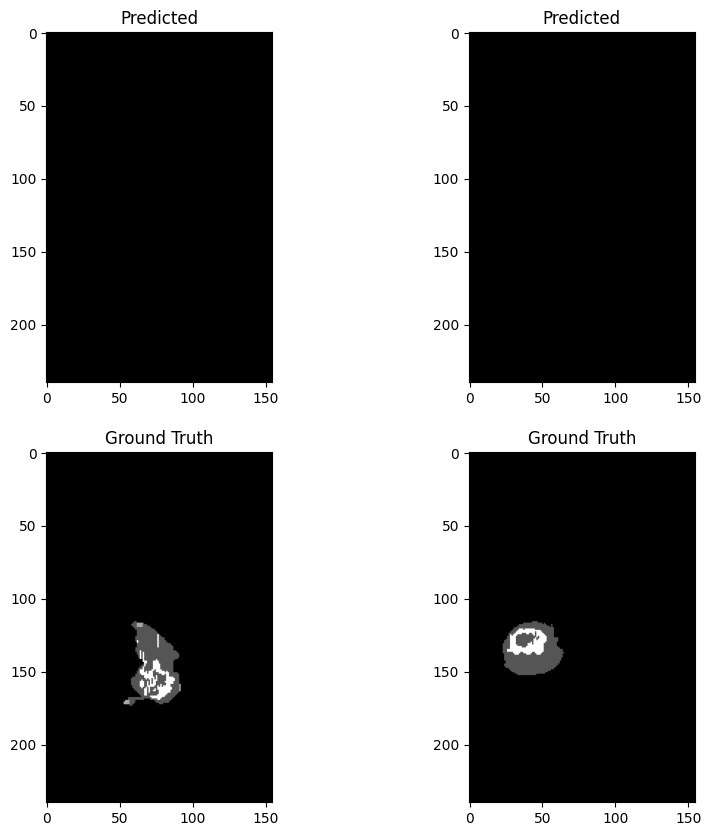

100%|██████████| 156/156 [08:26<00:00,  3.25s/it]



Average Training Loss: 0.35133807356349933

Average Training DSC: [0.86596396 0.46322688 0.75718292 0.00260711]
Average Training ASSD: [ 40.13558598 194.31187042  87.89978251 308.02475202]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


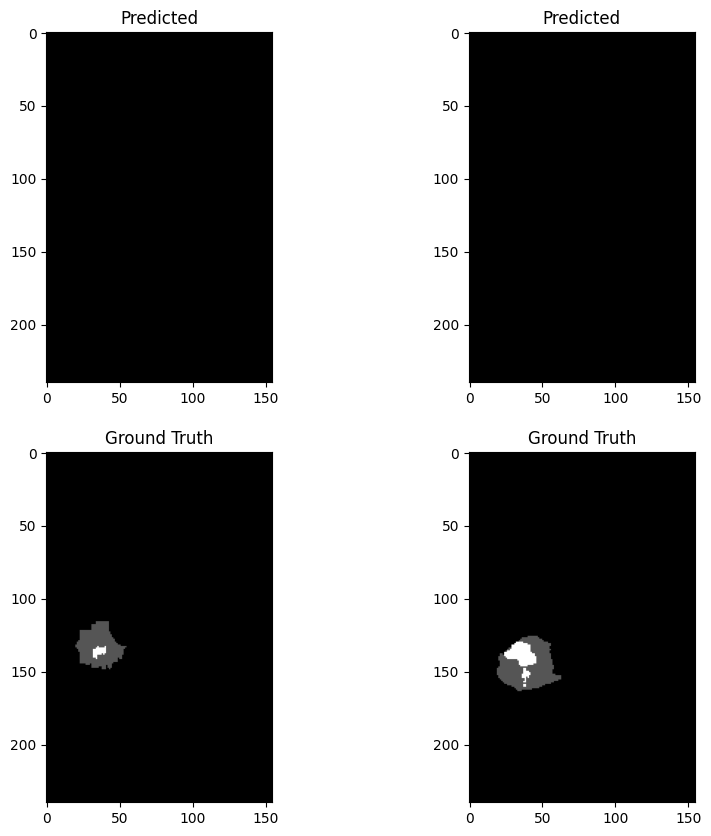

100%|██████████| 39/39 [01:58<00:00,  3.03s/it]


Average Validation Loss: 0.10638960355367416

Average Validation DSC: [0.98527265 0.44940476 0.74839744 0.        ]
Average Validation ASSD: [  3.63387267 199.31547619  91.08012821 362.        ]
Epoch 2/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


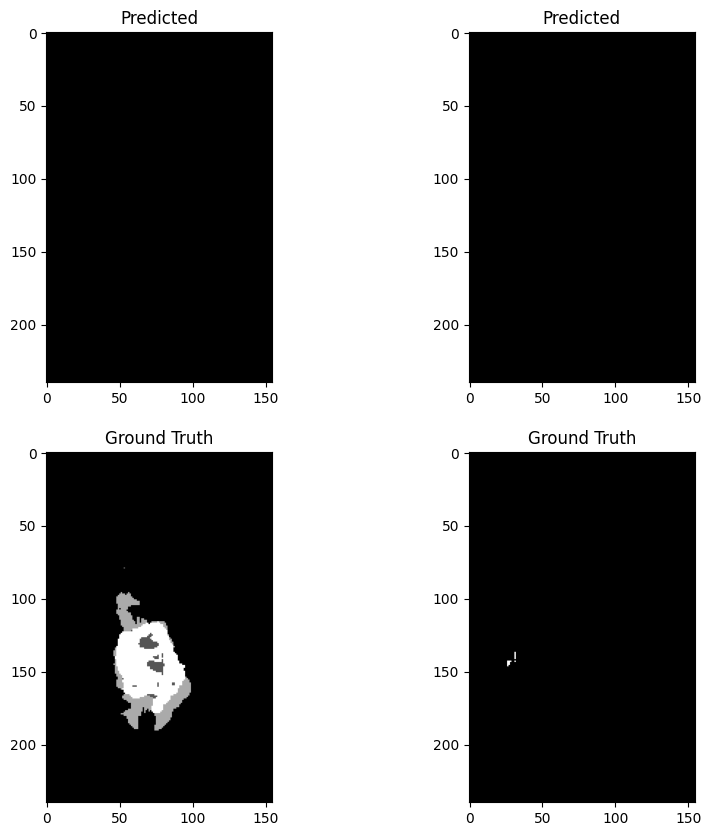

100%|██████████| 156/156 [08:46<00:00,  3.37s/it]



Average Training Loss: 0.08989684620442298

Average Training DSC: [0.98751221 0.46031306 0.75718292 0.13081438]
Average Training ASSD: [  2.40649676 193.18117782  87.89978251 223.03843435]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


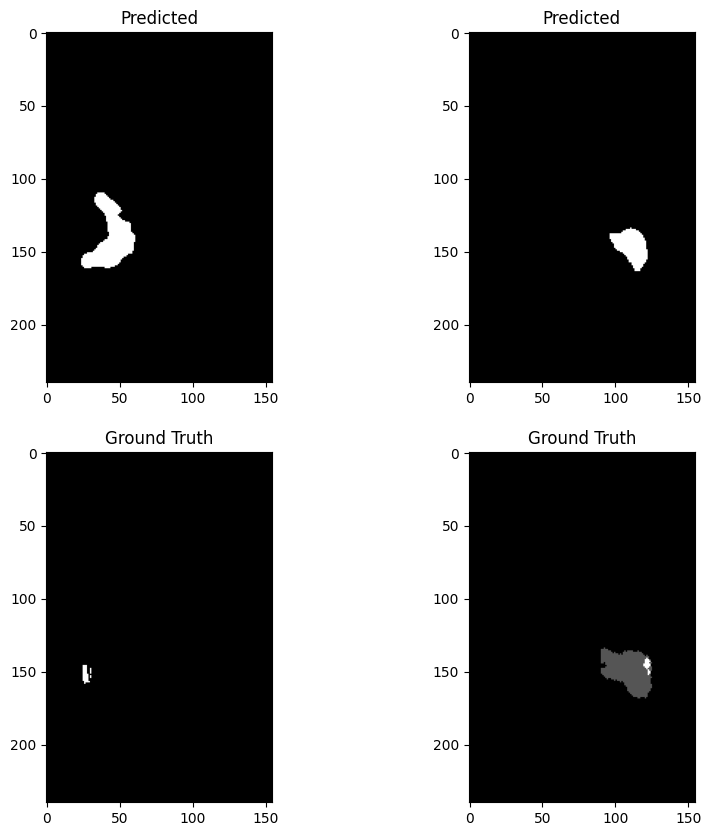

100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


Average Validation Loss: 0.0767809350330096

Average Validation DSC: [0.99175529 0.24172862 0.74862637 0.37856921]
Average Validation ASSD: [  0.92400359 158.48700958  90.99725275  32.9702189 ]
Epoch 3/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


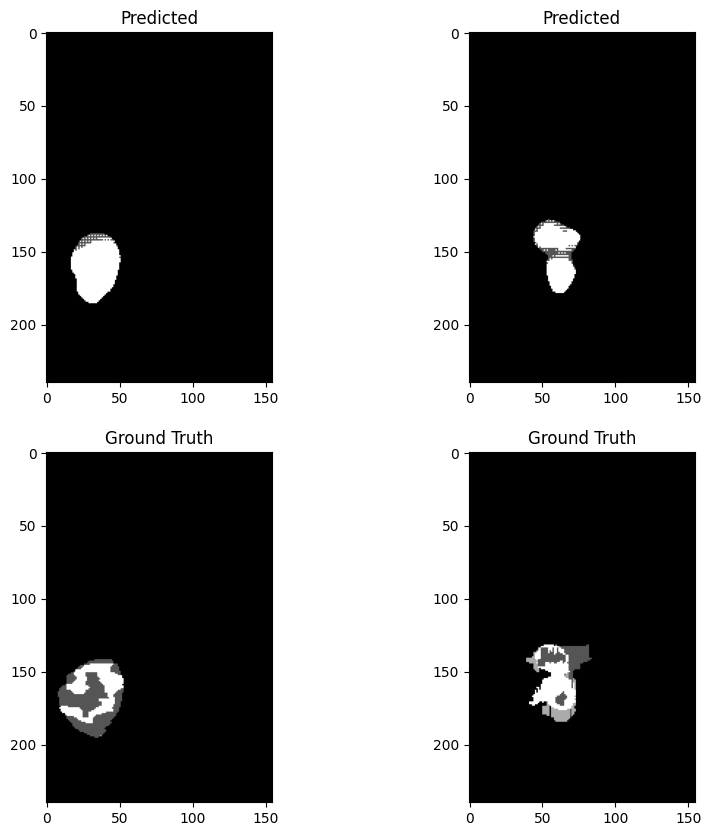

100%|██████████| 156/156 [09:25<00:00,  3.62s/it]



Average Training Loss: 0.06485796977694218

Average Training DSC: [0.99271002 0.41147379 0.75744048 0.31607481]
Average Training ASSD: [  0.87020699 138.31317356  87.80654762  71.7479779 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


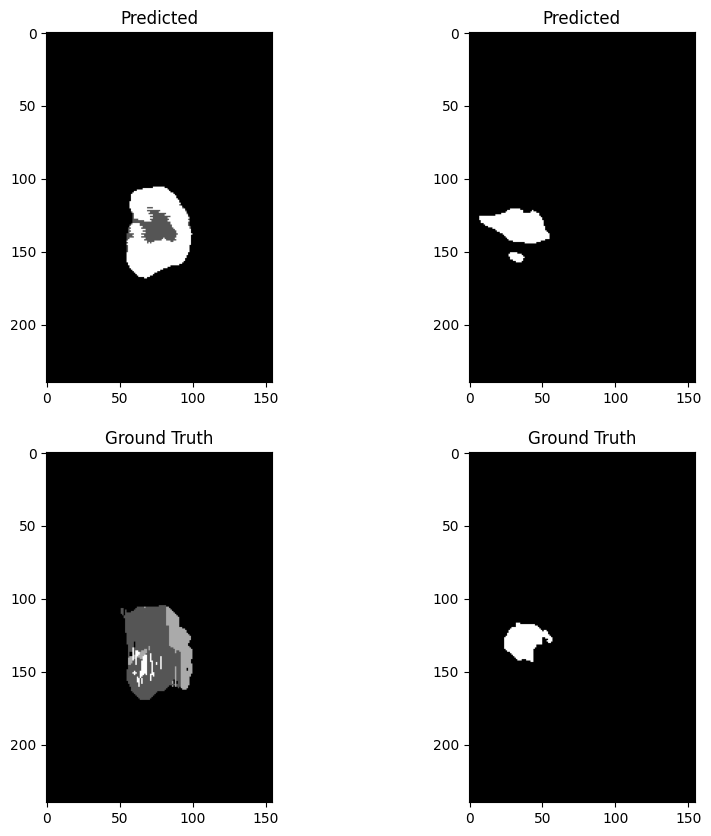

100%|██████████| 39/39 [02:10<00:00,  3.35s/it]


Average Validation Loss: 0.05803871364929737

Average Validation DSC: [0.99396134 0.44441878 0.7485119  0.32317576]
Average Validation ASSD: [  0.78051925 147.62141135  91.03869048  77.55800365]
Epoch 4/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


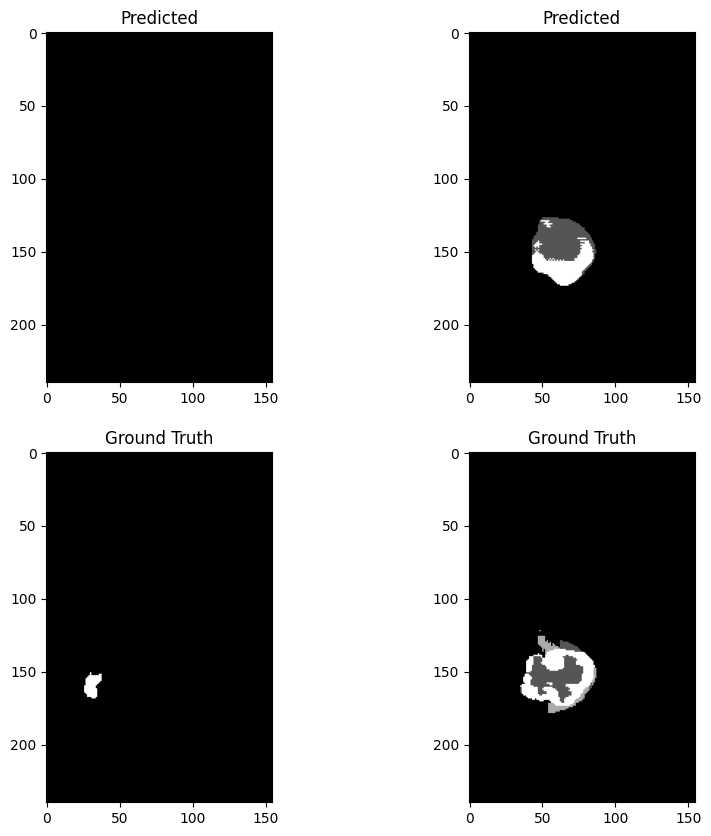

100%|██████████| 156/156 [09:23<00:00,  3.62s/it]



Average Training Loss: 0.05616345380743345

Average Training DSC: [0.9942535  0.47511525 0.75744048 0.33912609]
Average Training ASSD: [  0.67077083 134.84851017  87.80654762  69.61733128]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


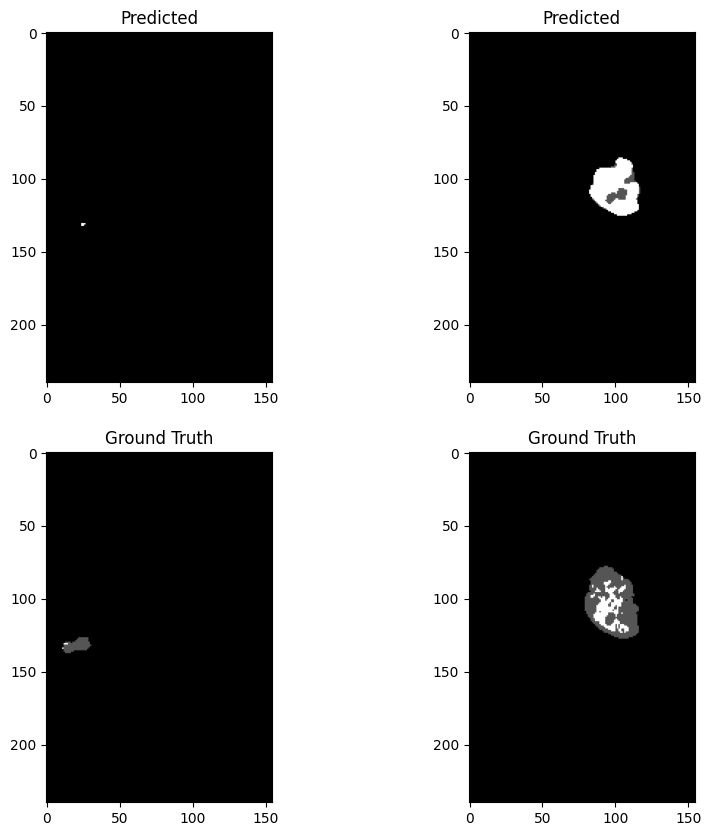

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.05325287341689452

Average Validation DSC: [0.99510751 0.44951295 0.74862637 0.36823025]
Average Validation ASSD: [  0.57069872 130.01047024  90.99725275  59.3306737 ]
Epoch 5/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


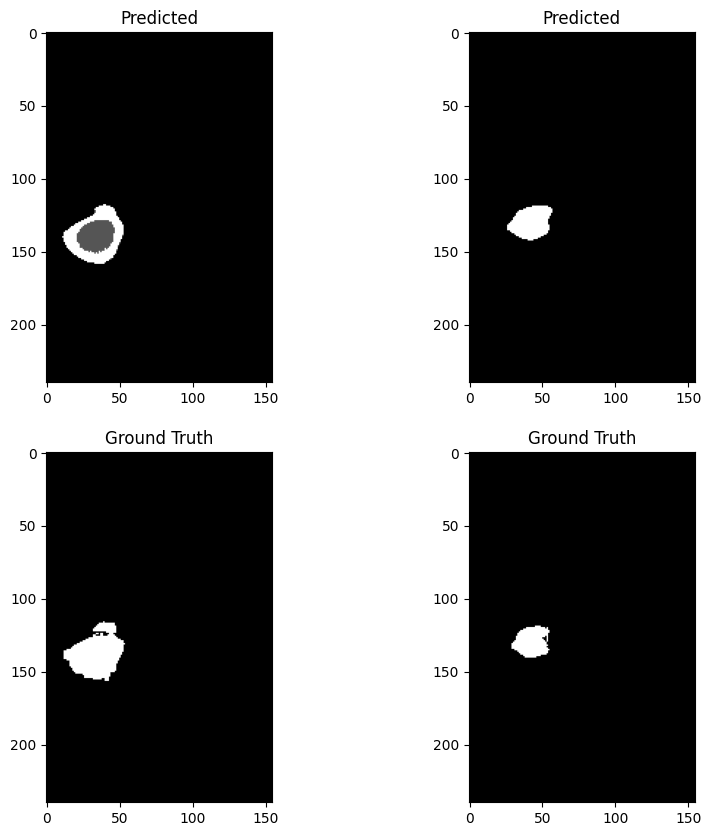

100%|██████████| 156/156 [09:23<00:00,  3.61s/it]



Average Training Loss: 0.05119748962804293

Average Training DSC: [0.99513842 0.44977282 0.75666781 0.36899275]
Average Training ASSD: [  0.55655332 124.51881765  88.08625229  59.99215789]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


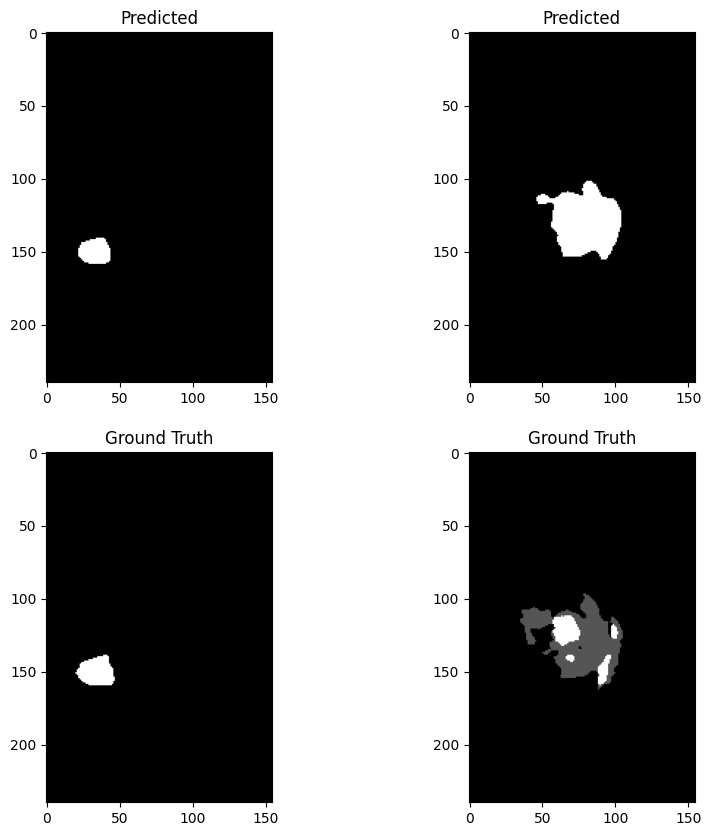

100%|██████████| 39/39 [02:12<00:00,  3.40s/it]


Average Validation Loss: 0.05035058924785027

Average Validation DSC: [0.99527981 0.43617186 0.74828297 0.39658966]
Average Validation ASSD: [  0.53965157 132.34328385  91.12156593  49.60358598]
Epoch 6/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


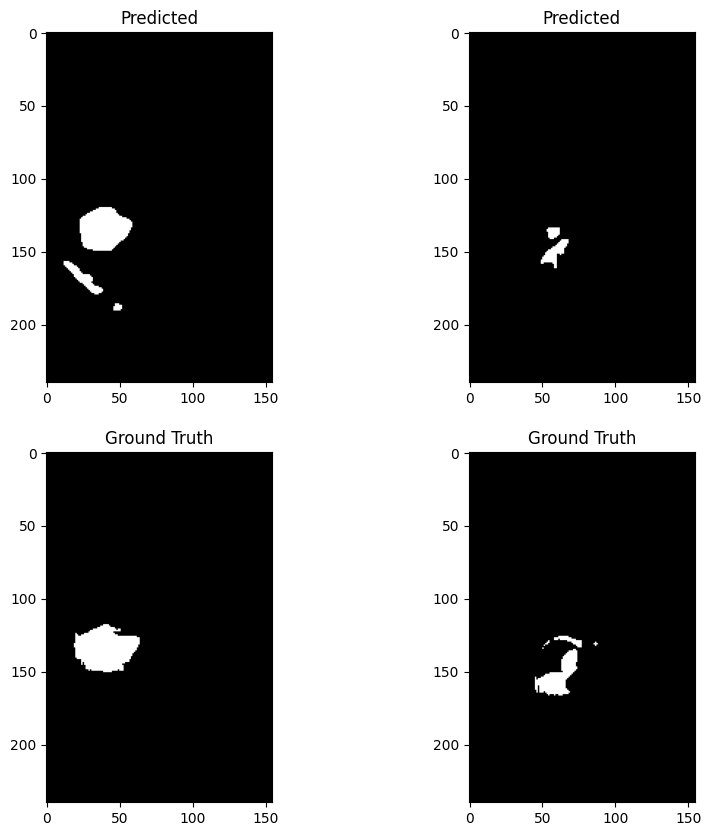

100%|██████████| 156/156 [09:30<00:00,  3.65s/it]



Average Training Loss: 0.04788560593405213

Average Training DSC: [0.995663   0.444247   0.75795559 0.3712613 ]
Average Training ASSD: [  0.49388034 115.26443452  87.62007784  56.65263294]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


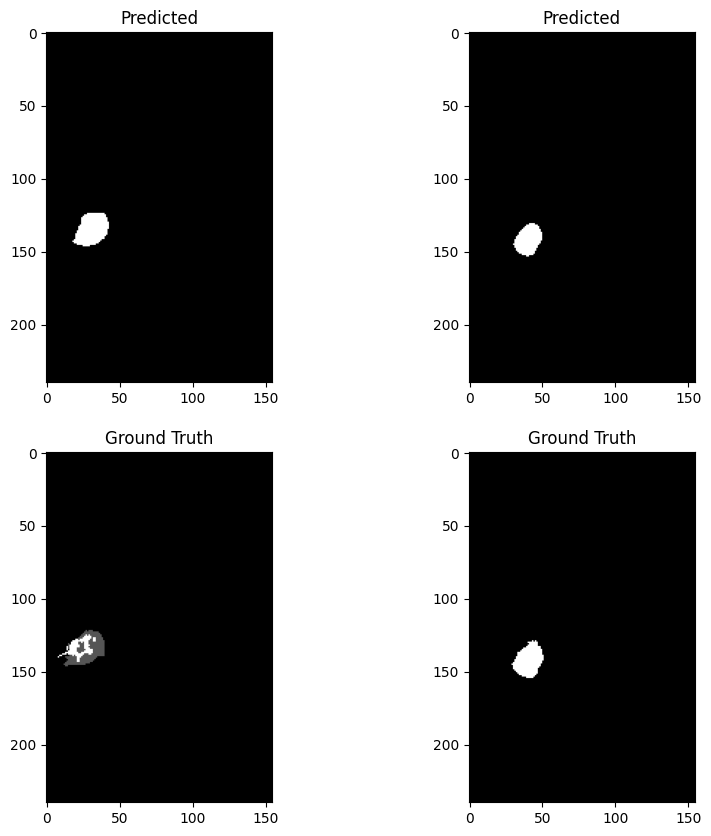

100%|██████████| 39/39 [02:11<00:00,  3.37s/it]


Average Validation Loss: 0.046590594813609734

Average Validation DSC: [0.99577812 0.43909095 0.74782509 0.41313593]
Average Validation ASSD: [  0.49167483 130.19976245  91.28731685  49.50968434]
Epoch 7/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


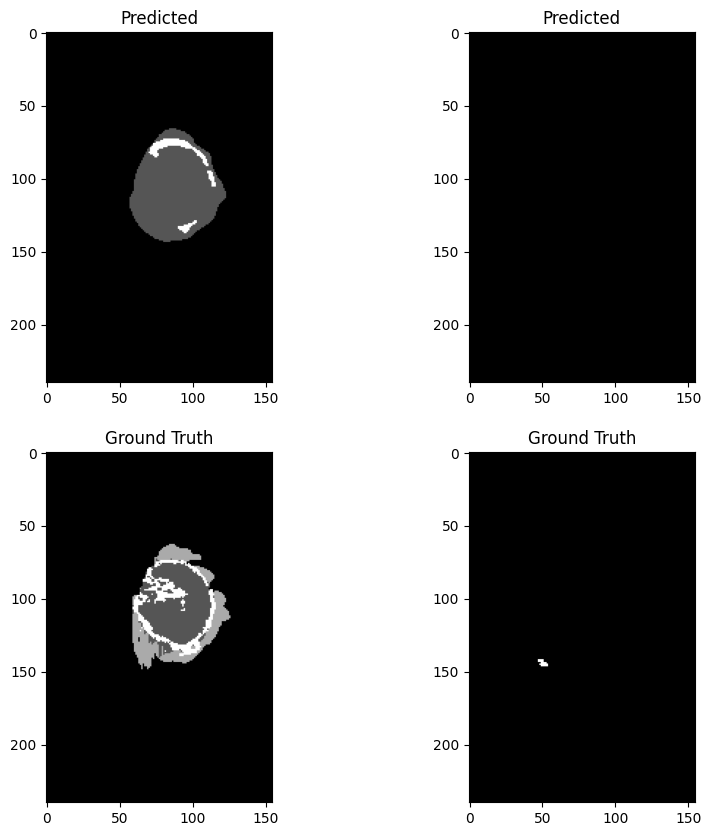

100%|██████████| 156/156 [09:27<00:00,  3.63s/it]



Average Training Loss: 0.04462619947317319

Average Training DSC: [0.99619125 0.45754327 0.75718292 0.38863225]
Average Training ASSD: [  0.43233326 108.89599264  87.89978251  55.86827177]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


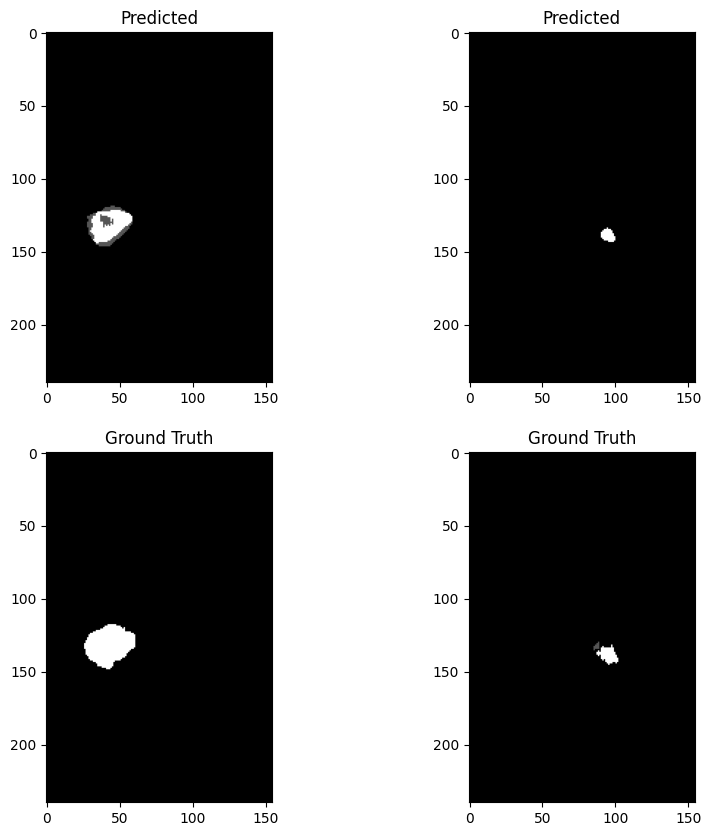

100%|██████████| 39/39 [02:08<00:00,  3.29s/it]


Average Validation Loss: 0.044037095056130335

Average Validation DSC: [0.99622546 0.48704256 0.74839744 0.36663683]
Average Validation ASSD: [  0.40860154 108.48815551  91.08012821  62.83891208]
Epoch 8/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


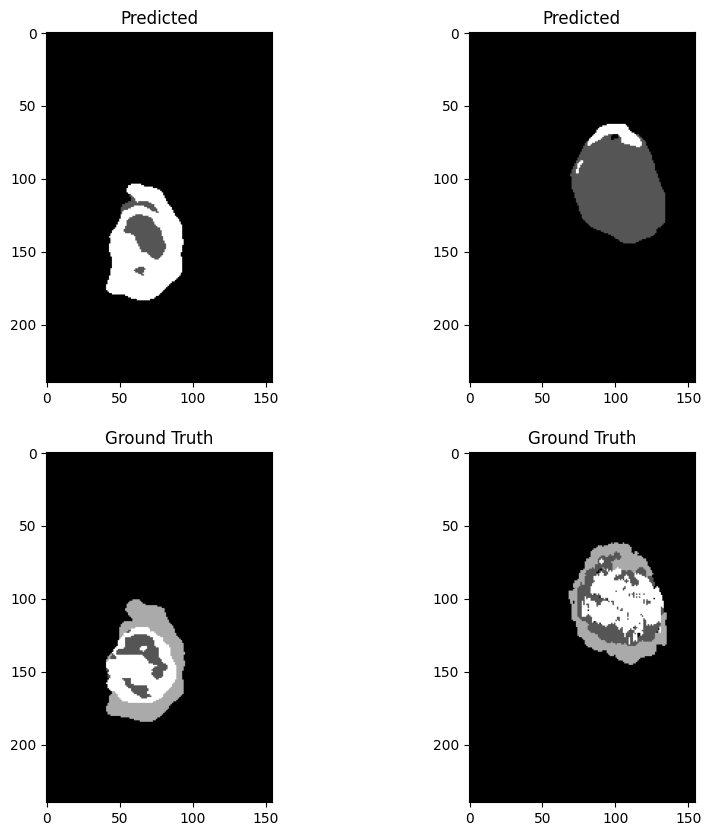

100%|██████████| 156/156 [09:28<00:00,  3.64s/it]



Average Training Loss: 0.04234083115051572

Average Training DSC: [0.9964976  0.48582622 0.73720039 0.39777939]
Average Training ASSD: [  0.39398148 105.88200291  83.95989591  54.51230307]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


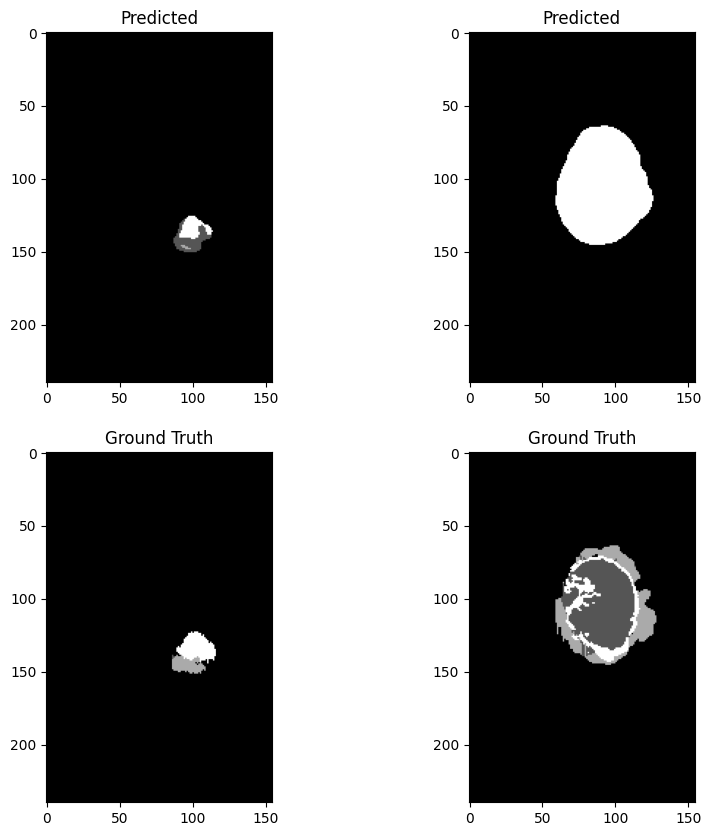

100%|██████████| 39/39 [02:14<00:00,  3.45s/it]


Average Validation Loss: 0.04372098850898254

Average Validation DSC: [0.99671362 0.46696893 0.62577762 0.29455224]
Average Validation ASSD: [  0.36329167 114.62102556  97.7764449   92.60409287]
Epoch 9/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


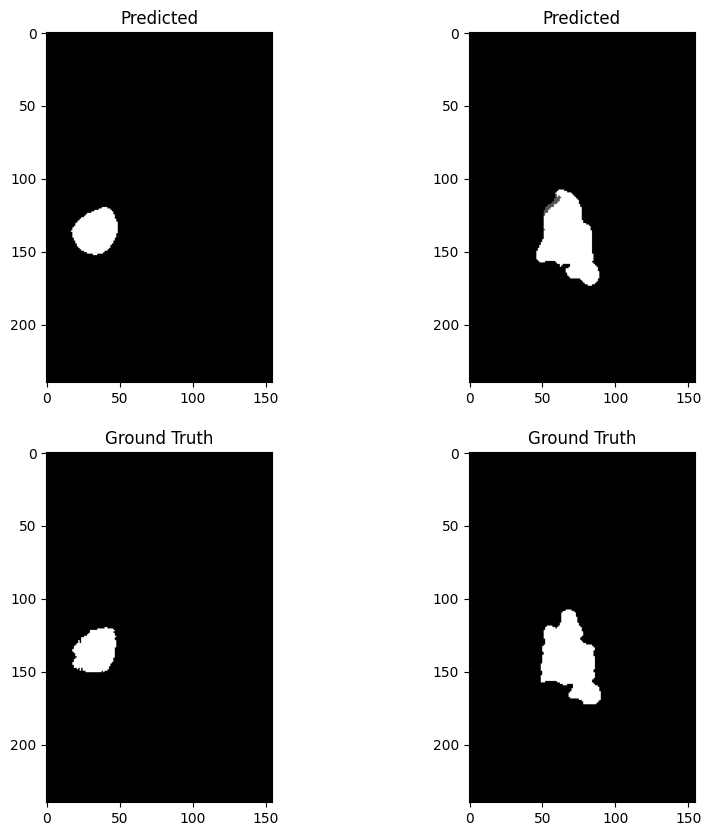

100%|██████████| 156/156 [09:25<00:00,  3.63s/it]



Average Training Loss: 0.039582861038163684

Average Training DSC: [0.99671562 0.49957135 0.65915454 0.41239974]
Average Training ASSD: [  0.36513291 100.28059764  85.76246577  52.21814526]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


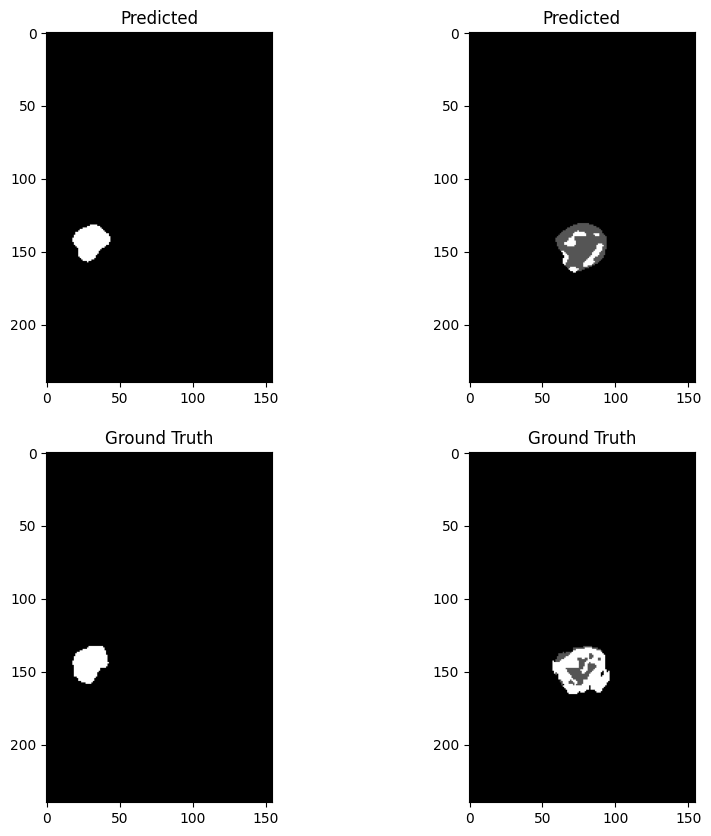

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.03953934737887138

Average Validation DSC: [0.99684115 0.49154929 0.63711725 0.44751167]
Average Validation ASSD: [  0.33704653 103.81676572  91.69291851  33.3427373 ]
Epoch 10/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


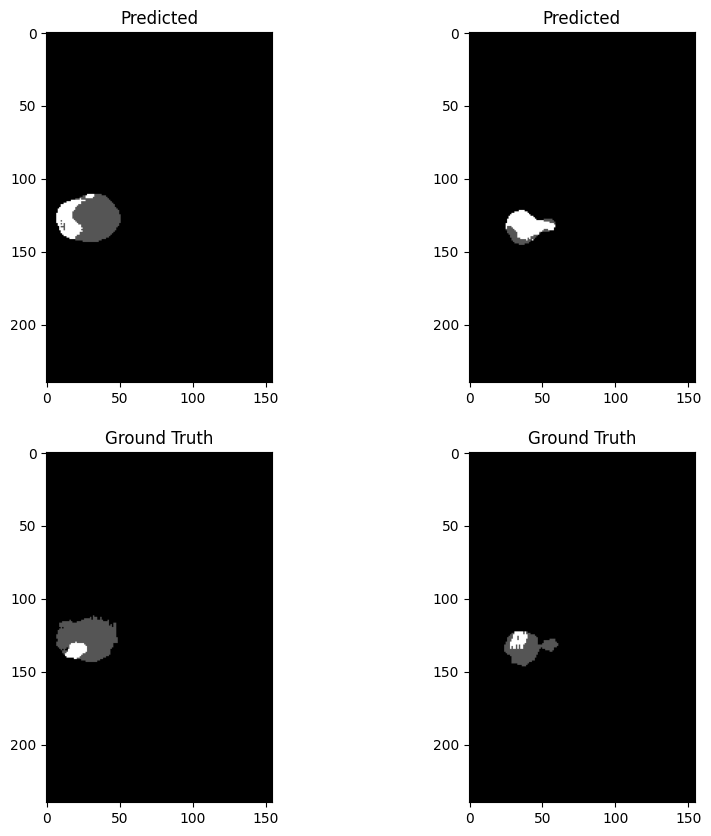

100%|██████████| 156/156 [09:38<00:00,  3.71s/it]



Average Training Loss: 0.037556387698994234

Average Training DSC: [0.99674201 0.52308131 0.63728573 0.43847379]
Average Training ASSD: [ 0.36237093 93.56675132 91.8507832  47.34598202]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


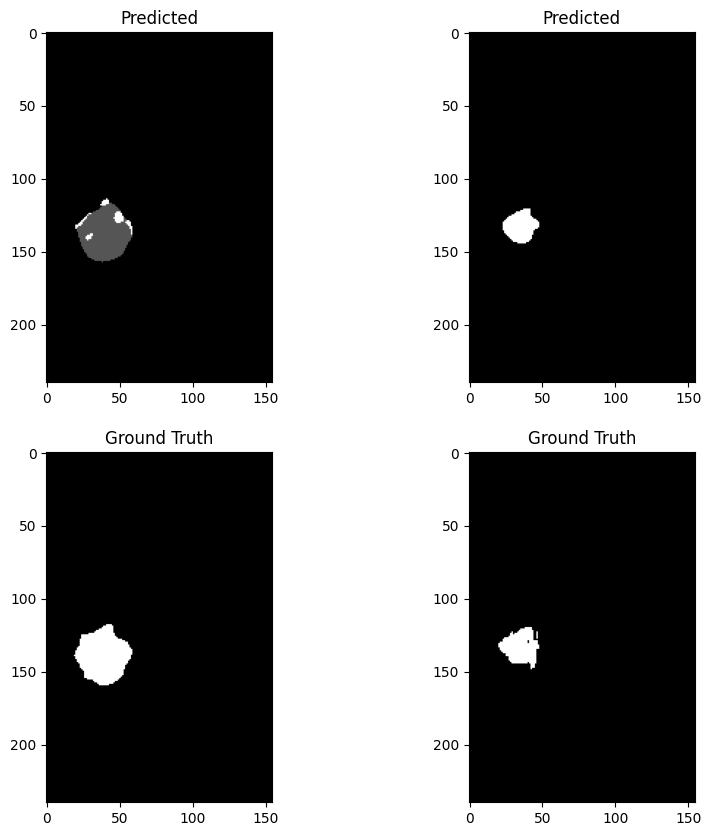

100%|██████████| 39/39 [02:14<00:00,  3.46s/it]


Average Validation Loss: 0.03545259507611776

Average Validation DSC: [0.99693315 0.56270363 0.65047694 0.44536795]
Average Validation ASSD: [ 0.31731702 85.45648273 86.57611602 39.36427328]
Epoch 11/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


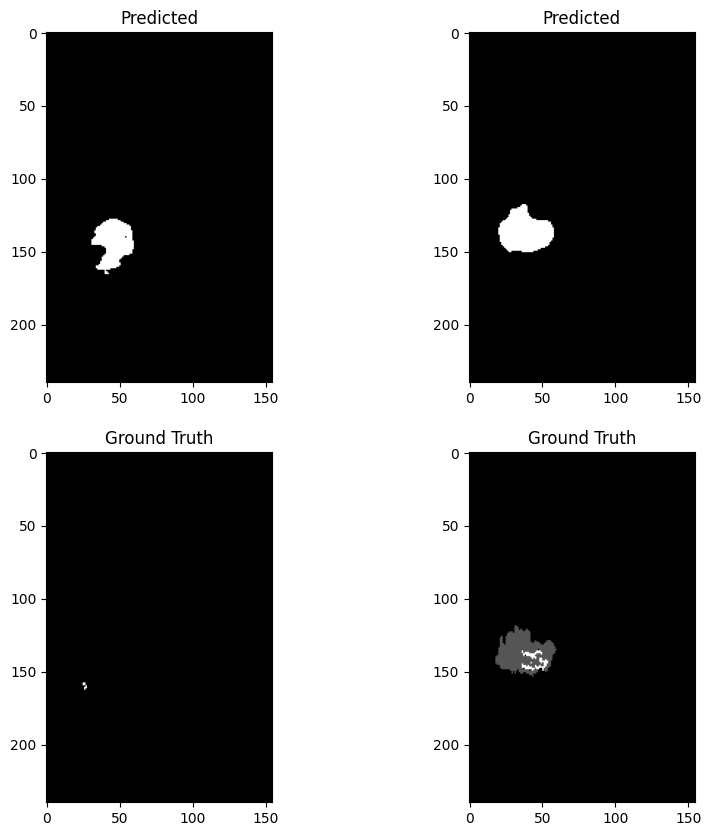

100%|██████████| 156/156 [09:33<00:00,  3.68s/it]



Average Training Loss: 0.03355496180936312

Average Training DSC: [0.99703579 0.57178966 0.70731078 0.46140593]
Average Training ASSD: [ 0.32924178 83.21873236 71.37265623 44.49820412]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


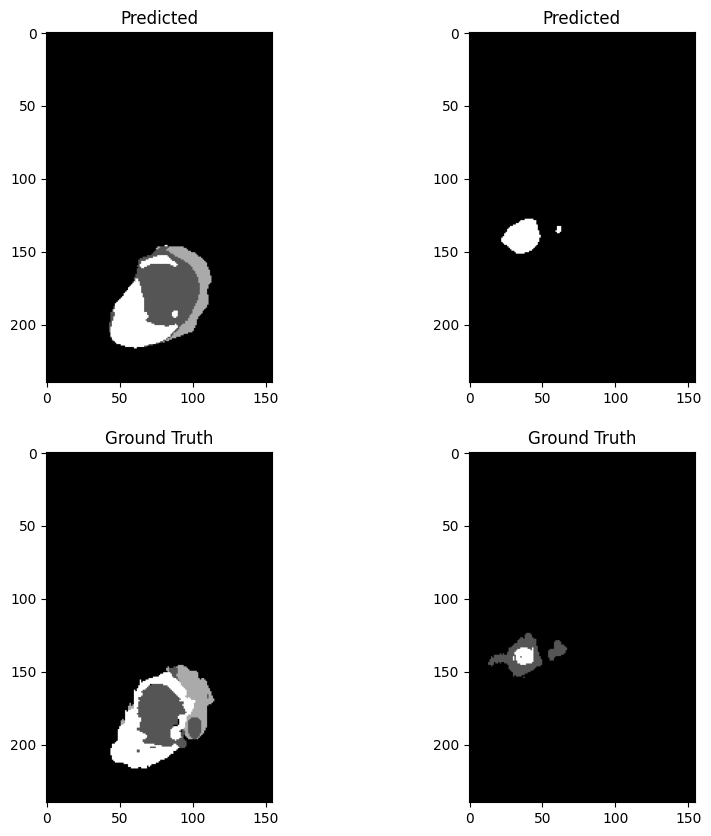

100%|██████████| 39/39 [02:11<00:00,  3.37s/it]


Average Validation Loss: 0.0337740986679609

Average Validation DSC: [0.99705042 0.55478349 0.65394249 0.42704707]
Average Validation ASSD: [ 0.3102382  86.44366658 87.78379705 55.26762944]
Epoch 12/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


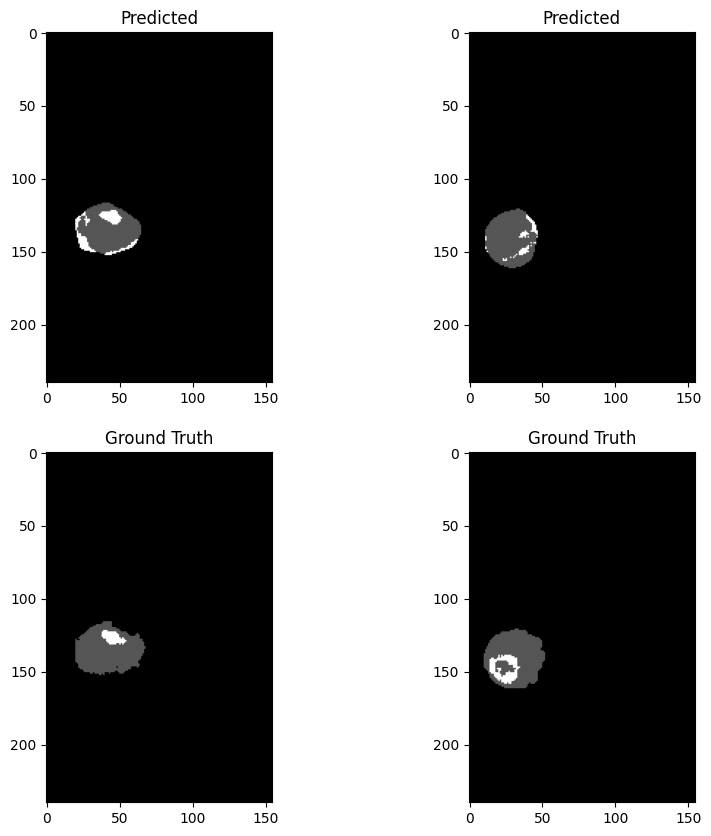

100%|██████████| 156/156 [09:35<00:00,  3.69s/it]



Average Training Loss: 0.030262273736298084

Average Training DSC: [0.9971681  0.61819863 0.77164286 0.47617424]
Average Training ASSD: [ 0.31469127 73.04684965 52.49428328 43.55052367]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


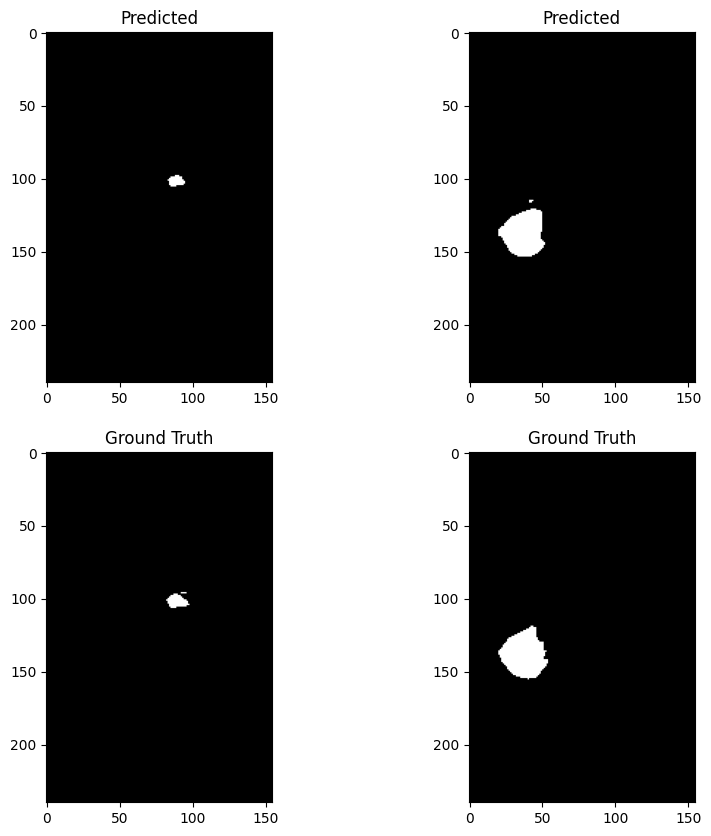

100%|██████████| 39/39 [02:16<00:00,  3.50s/it]


Average Validation Loss: 0.030848017774331264

Average Validation DSC: [0.99694908 0.60754054 0.78711221 0.51421451]
Average Validation ASSD: [ 0.3360992  69.70097847 46.28840766 38.18016218]
Epoch 13/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


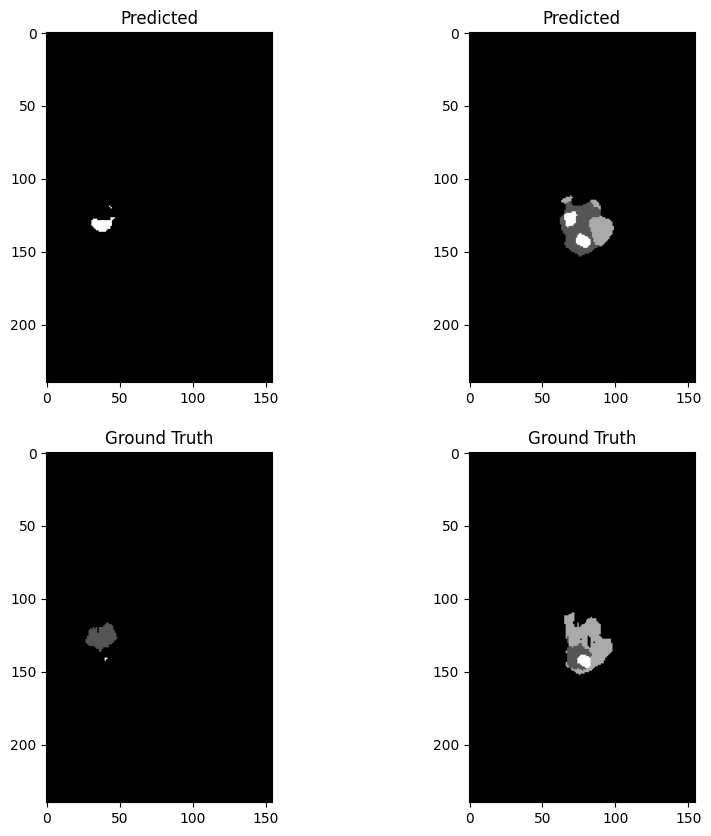

100%|██████████| 156/156 [09:36<00:00,  3.69s/it]



Average Training Loss: 0.027838556203418054

Average Training DSC: [0.99723209 0.66202358 0.79811263 0.49507021]
Average Training ASSD: [ 0.29722137 62.98143265 45.75899726 45.98852774]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


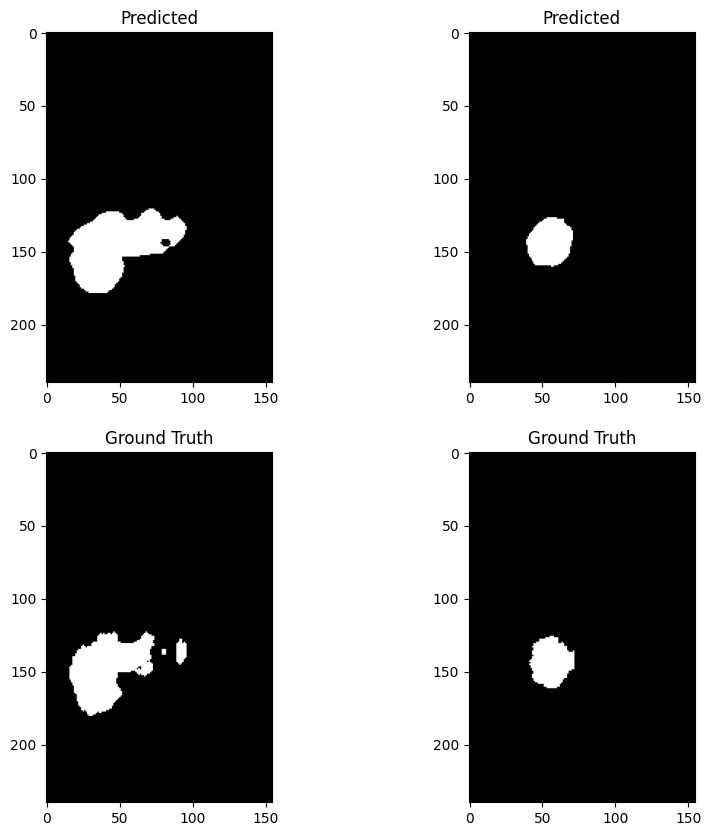

100%|██████████| 39/39 [02:12<00:00,  3.40s/it]


Average Validation Loss: 0.035879648935336336

Average Validation DSC: [0.99646769 0.57947041 0.73246141 0.46929414]
Average Validation ASSD: [ 0.35771064 86.36729259 65.93420831 26.37107169]
Epoch 14/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


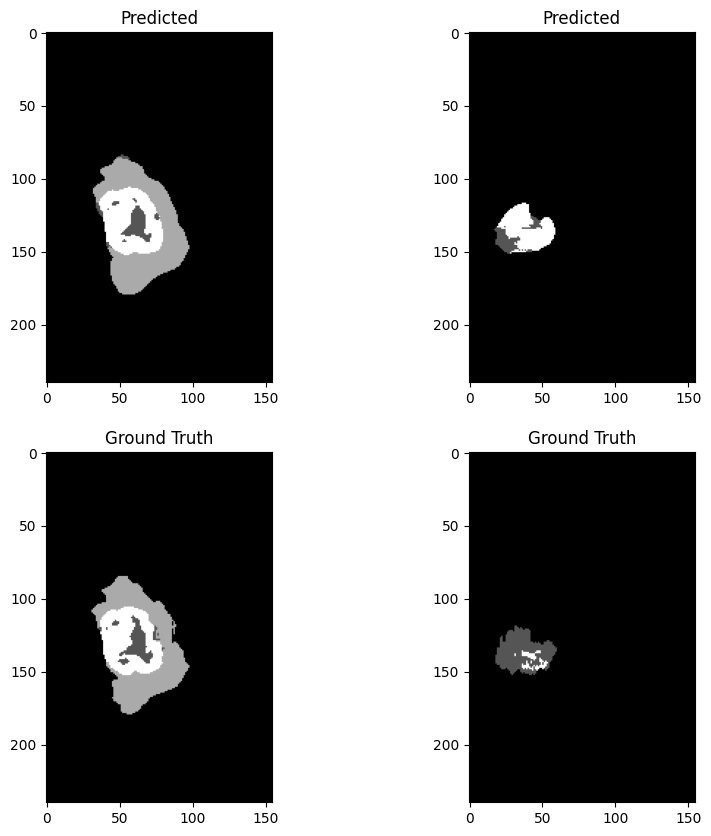

100%|██████████| 156/156 [09:31<00:00,  3.66s/it]



Average Training Loss: 0.024817237534966223

Average Training DSC: [0.997458   0.70142682 0.82408863 0.51645068]
Average Training ASSD: [ 0.27750338 53.58392139 40.18235694 49.28691348]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


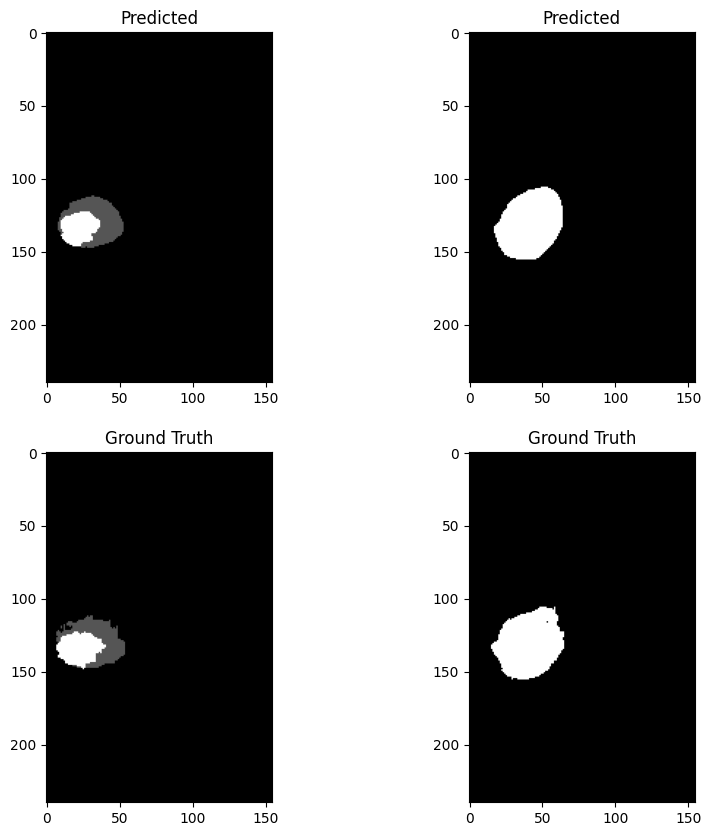

100%|██████████| 39/39 [02:13<00:00,  3.42s/it]


Average Validation Loss: 0.02535205265172781

Average Validation DSC: [0.99741251 0.70187164 0.8458343  0.55379961]
Average Validation ASSD: [ 0.26501897 52.23699014 33.14874582 34.42011045]
Epoch 15/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


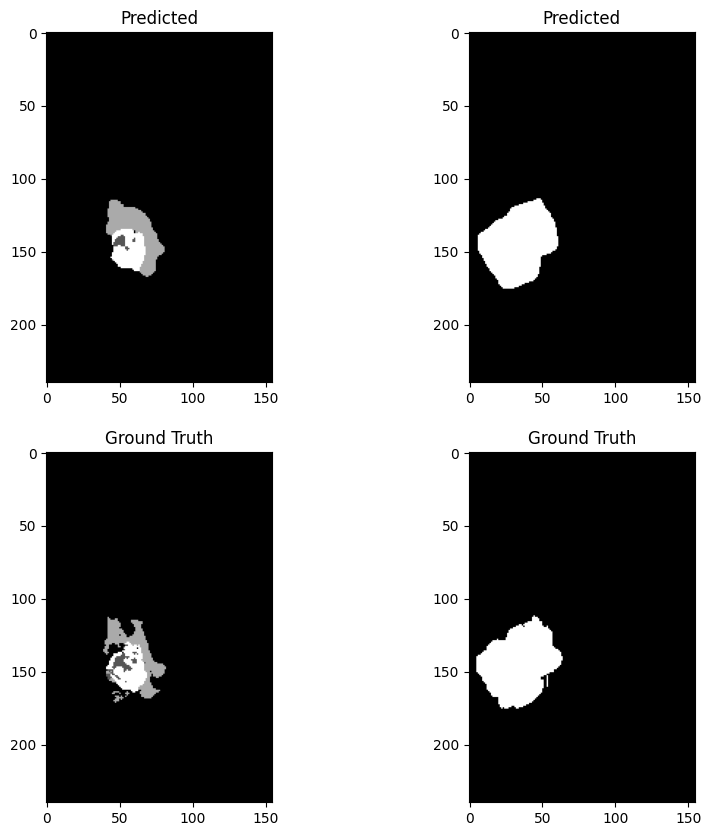

100%|██████████| 156/156 [09:29<00:00,  3.65s/it]



Average Training Loss: 0.021600814852624748

Average Training DSC: [0.99769508 0.74976537 0.85584045 0.54783593]
Average Training ASSD: [ 0.24464166 41.39433275 30.45306158 50.25619218]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


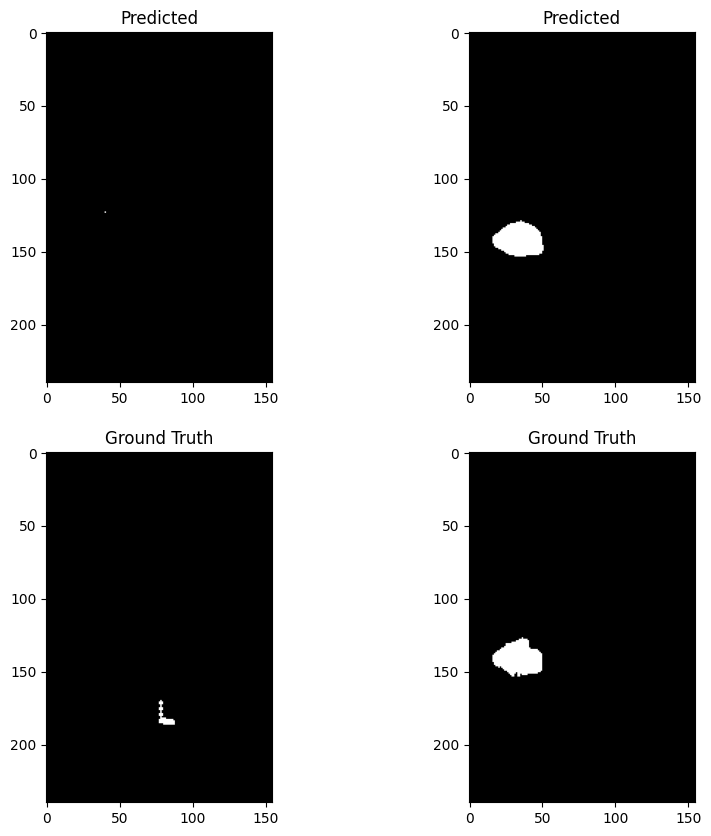

100%|██████████| 39/39 [02:08<00:00,  3.29s/it]


Average Validation Loss: 0.023698400276211593

Average Validation DSC: [0.9975094  0.65224433 0.8324225  0.53484336]
Average Validation ASSD: [ 0.24628446 76.02767547 39.08552311 42.54319612]
Epoch 16/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


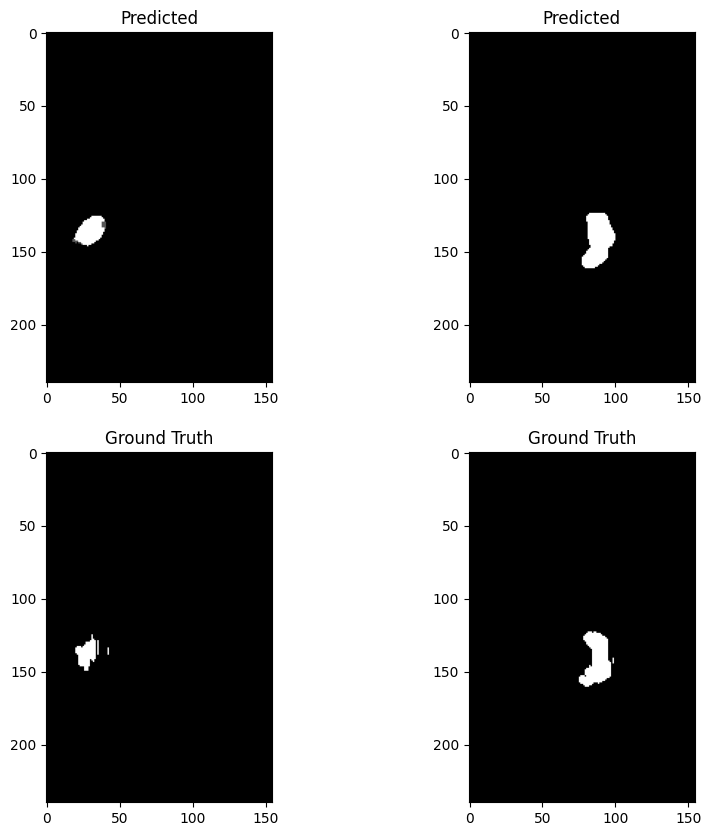

100%|██████████| 156/156 [09:39<00:00,  3.71s/it]



Average Training Loss: 0.020528272624151446

Average Training DSC: [0.99778304 0.75691924 0.85783488 0.56021143]
Average Training ASSD: [ 0.23349048 40.68565247 31.43821252 50.31382538]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


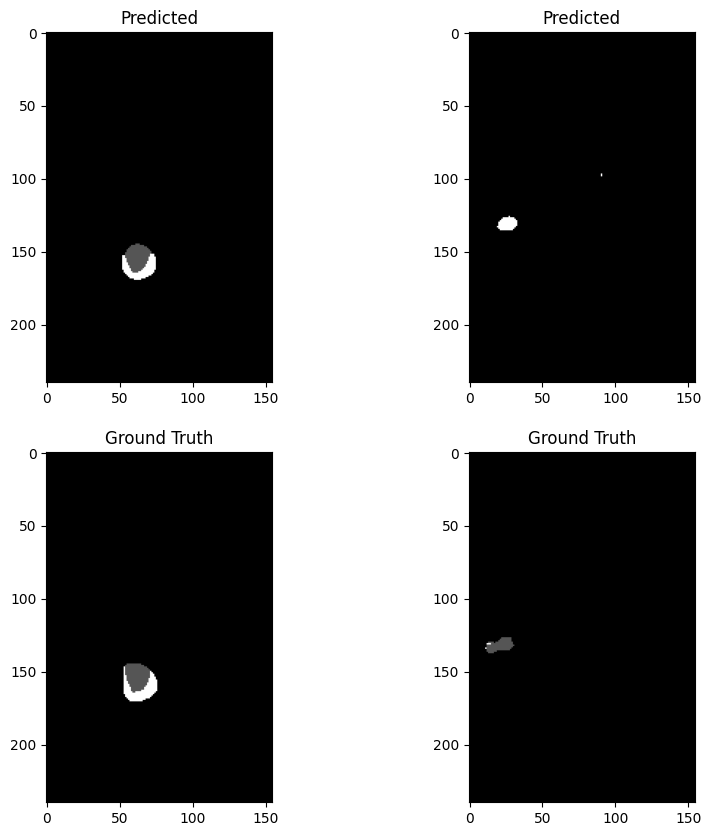

100%|██████████| 39/39 [02:14<00:00,  3.45s/it]


Average Validation Loss: 0.021652939275671274

Average Validation DSC: [0.99774981 0.74251157 0.86932662 0.56942372]
Average Validation ASSD: [ 0.23690569 45.33222979 26.48952388 40.12792841]
Epoch 17/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


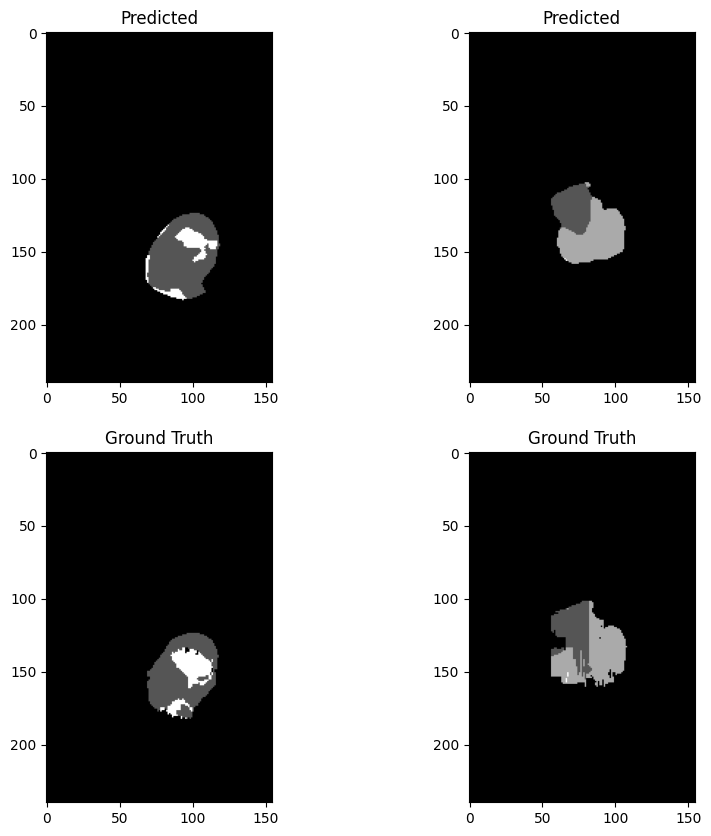

100%|██████████| 156/156 [09:47<00:00,  3.77s/it]



Average Training Loss: 0.01923883018585352

Average Training DSC: [0.99788969 0.77022341 0.86963714 0.57523747]
Average Training ASSD: [ 0.22508502 38.33483691 27.8332016  49.48049375]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


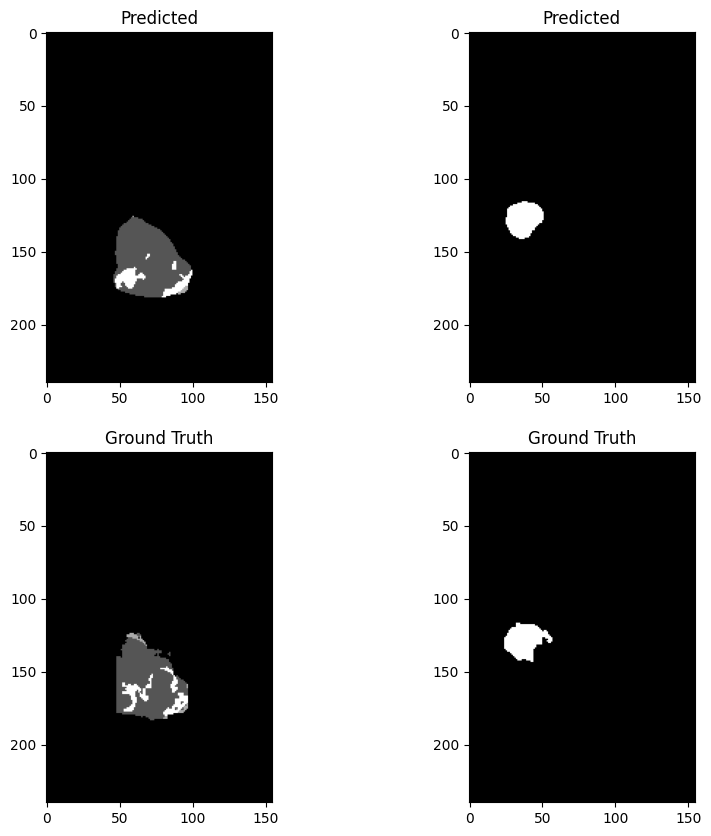

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.021644623663562994

Average Validation DSC: [0.99765063 0.76086864 0.82689857 0.58065313]
Average Validation ASSD: [ 0.25101274 36.88982035 37.36899957 41.92693432]
Epoch 18/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


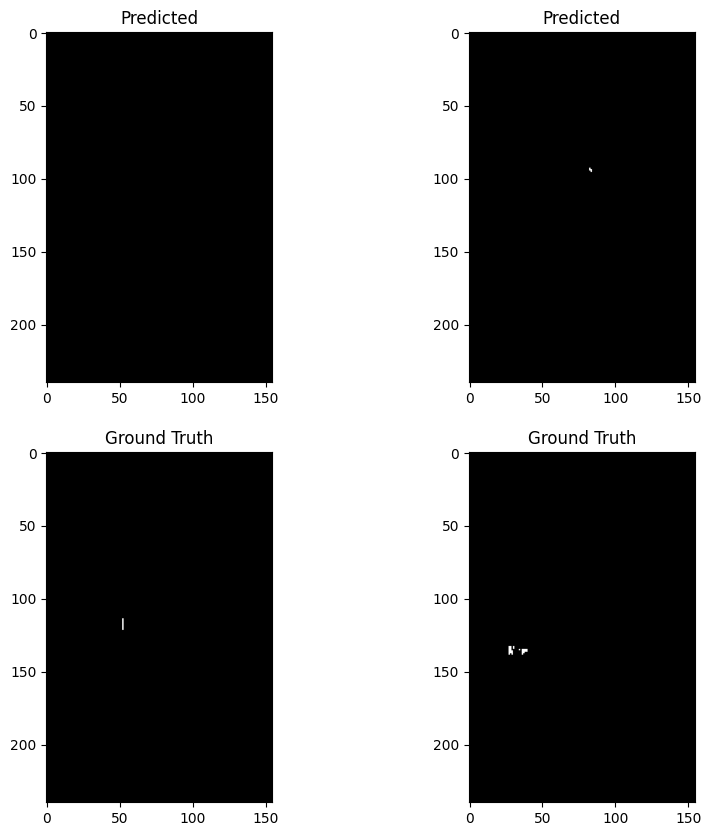

100%|██████████| 156/156 [09:23<00:00,  3.61s/it]



Average Training Loss: 0.018470000738325793

Average Training DSC: [0.99793939 0.7902687  0.86802638 0.58467006]
Average Training ASSD: [ 0.21345172 32.61693333 27.16010482 49.63923618]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


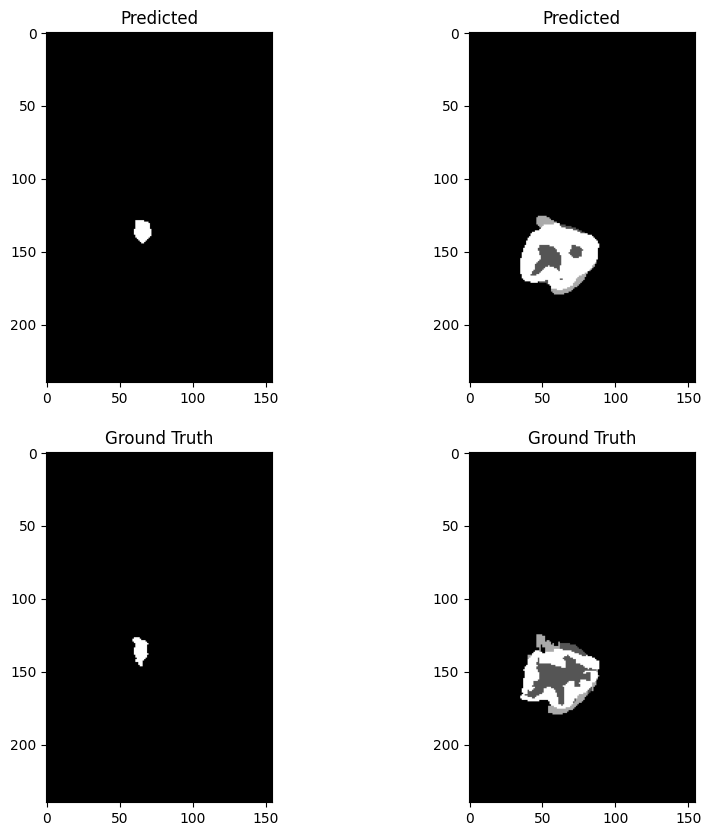

100%|██████████| 39/39 [02:12<00:00,  3.39s/it]


Average Validation Loss: 0.021422593185725886

Average Validation DSC: [0.99783602 0.72206699 0.8707739  0.60296393]
Average Validation ASSD: [ 0.21918901 48.97686499 24.49252544 32.712521  ]
Epoch 19/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


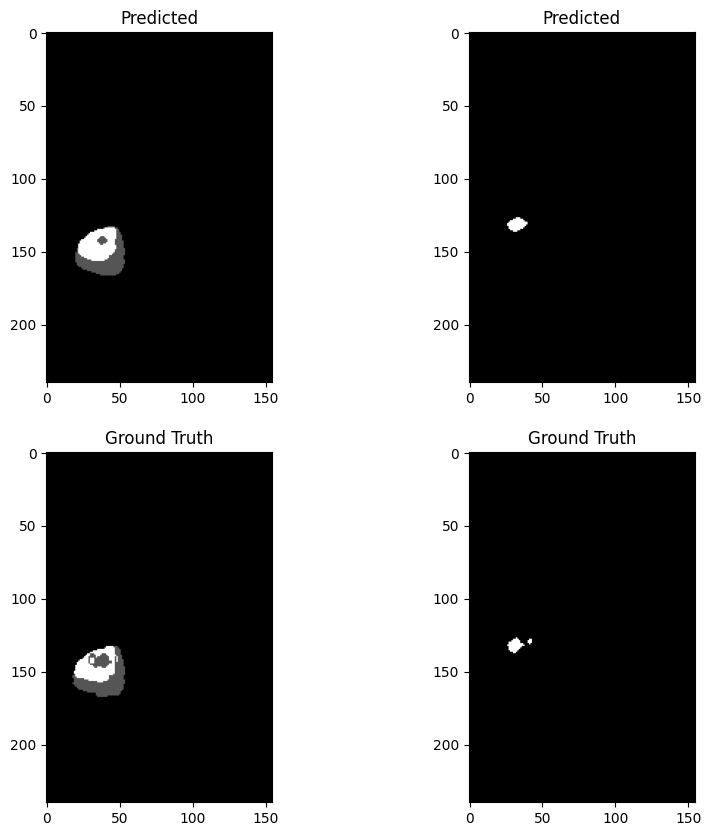

100%|██████████| 156/156 [09:27<00:00,  3.64s/it]



Average Training Loss: 0.017273399214714002

Average Training DSC: [0.99805814 0.80716399 0.88337515 0.60011382]
Average Training ASSD: [ 0.19964824 28.41520341 22.57936949 48.88424581]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


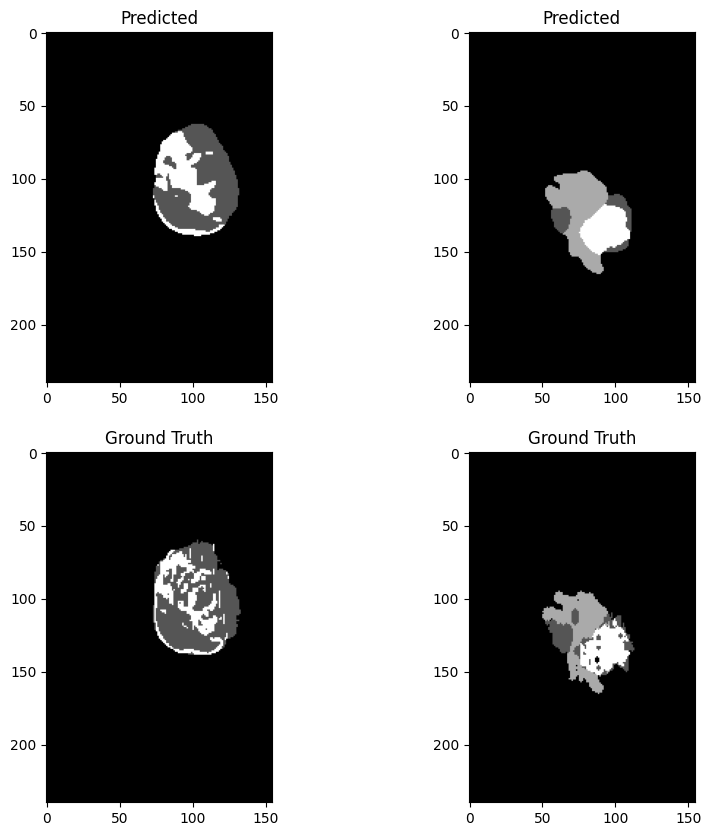

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.019062616623556003

Average Validation DSC: [0.99796111 0.79024241 0.87535677 0.62244557]
Average Validation ASSD: [ 0.19945506 33.19727298 26.34001513 30.49431567]
Epoch 20/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


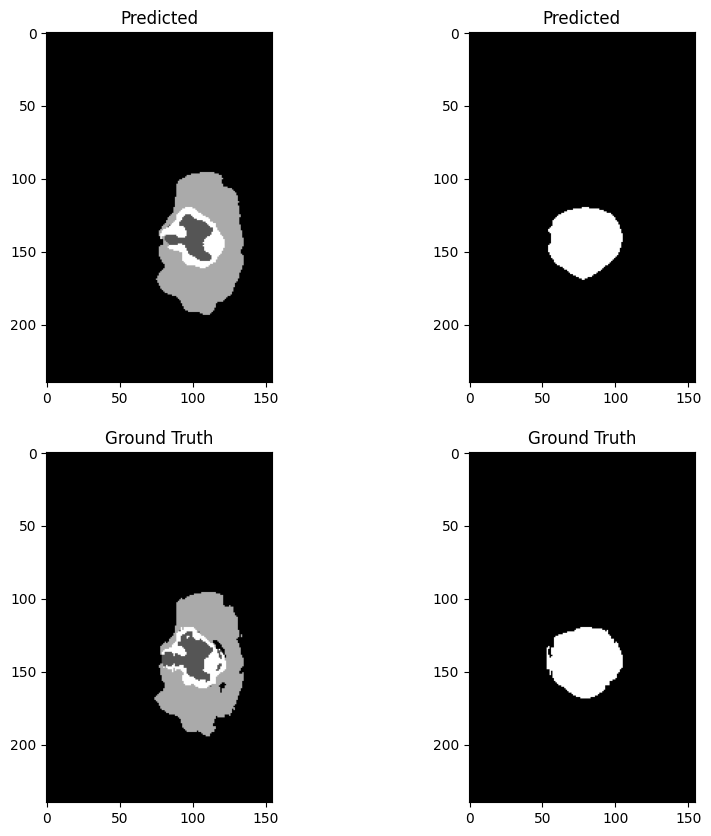

100%|██████████| 156/156 [09:30<00:00,  3.65s/it]



Average Training Loss: 0.016730938805267215

Average Training DSC: [0.99810533 0.81339264 0.88476305 0.60953968]
Average Training ASSD: [ 0.19619215 27.43676336 22.48334632 48.2526729 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


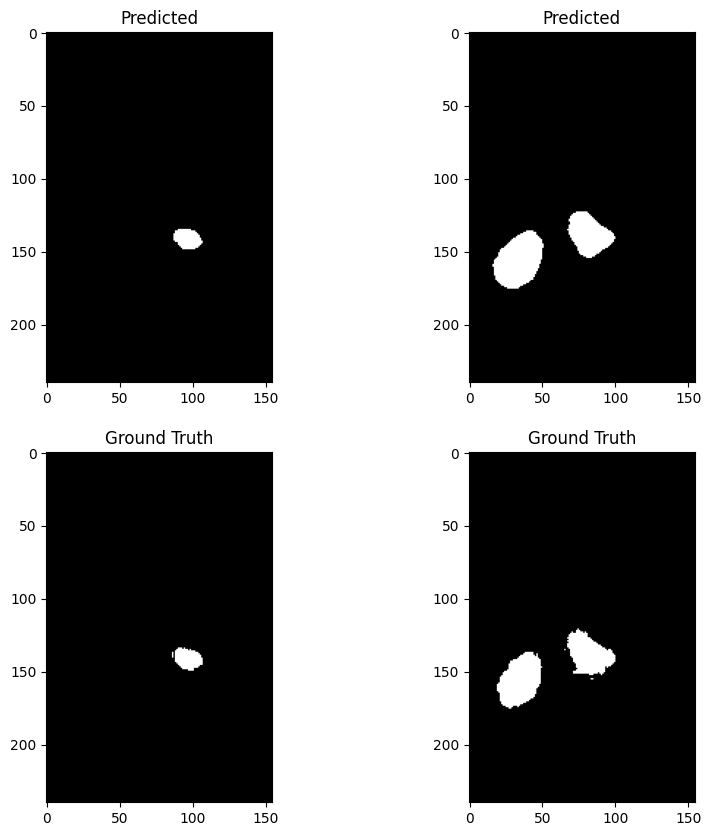

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.018817383987017166

Average Validation DSC: [0.9979083  0.79073433 0.86409651 0.61925831]
Average Validation ASSD: [ 0.20101614 34.89119589 27.61928259 31.47902161]
Epoch 21/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


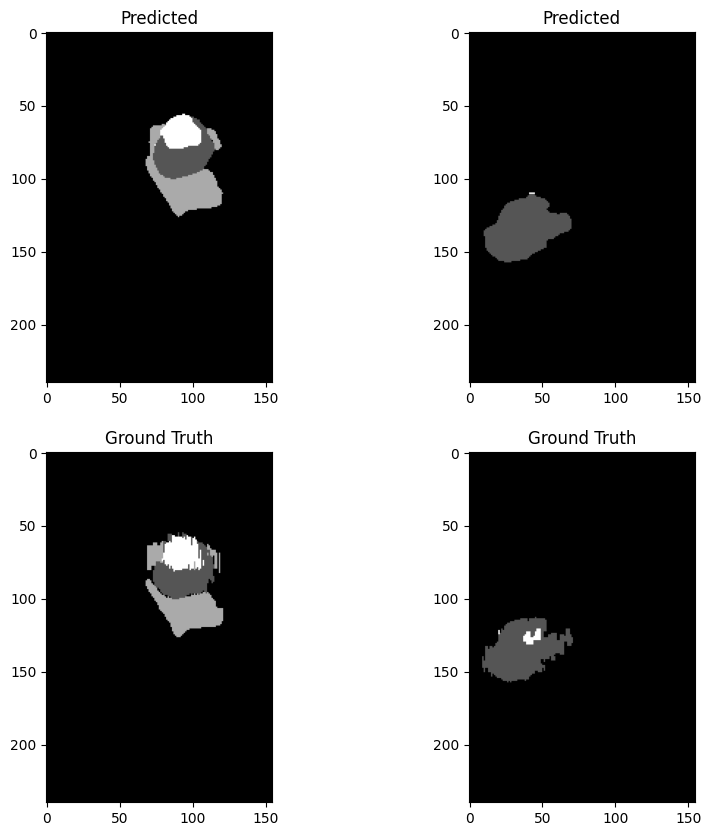

100%|██████████| 156/156 [09:12<00:00,  3.54s/it]



Average Training Loss: 0.015641036150881495

Average Training DSC: [0.99818678 0.82574392 0.89516072 0.6249147 ]
Average Training ASSD: [ 0.18798677 25.45795132 19.32408975 45.08672584]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


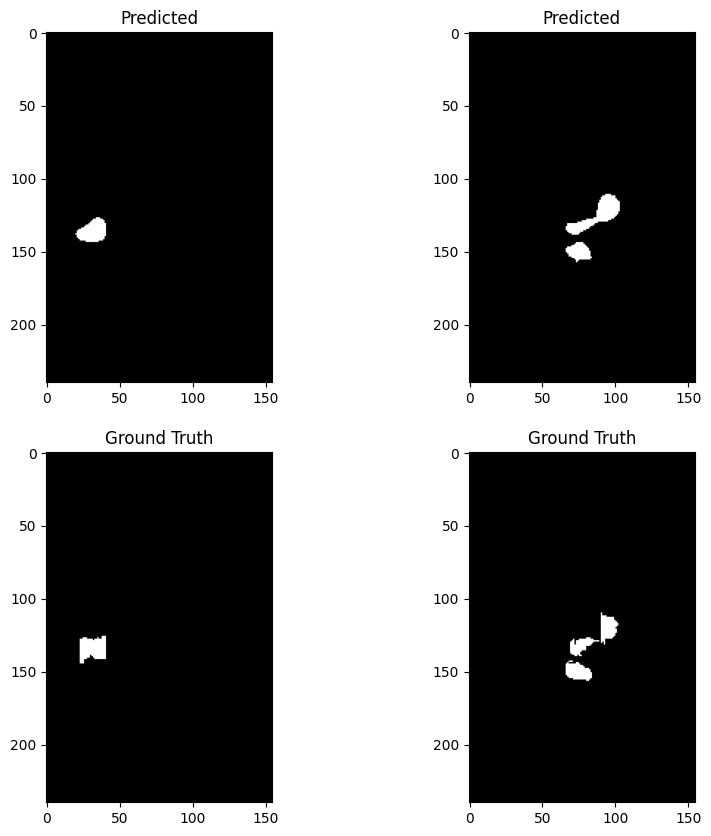

100%|██████████| 39/39 [02:09<00:00,  3.32s/it]


Average Validation Loss: 0.01875146397222311

Average Validation DSC: [0.99796168 0.76712305 0.87954001 0.63895229]
Average Validation ASSD: [ 0.20959059 39.51342984 24.88460536 30.84964911]
Epoch 22/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


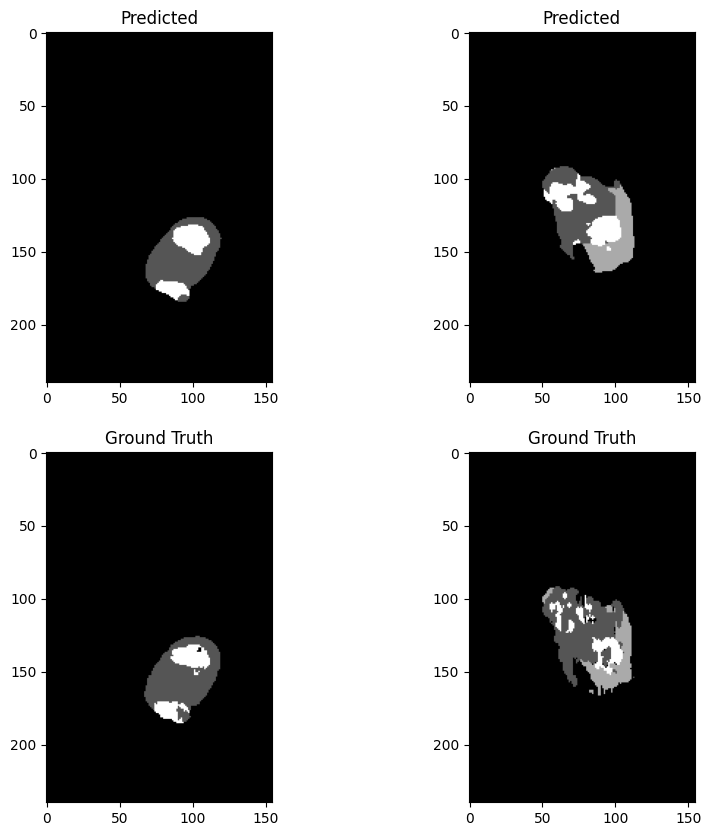

100%|██████████| 156/156 [09:06<00:00,  3.50s/it]



Average Training Loss: 0.015162259286556106

Average Training DSC: [0.99822418 0.83376985 0.89861004 0.63208642]
Average Training ASSD: [ 0.18226835 23.28722946 19.13941466 45.43846493]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


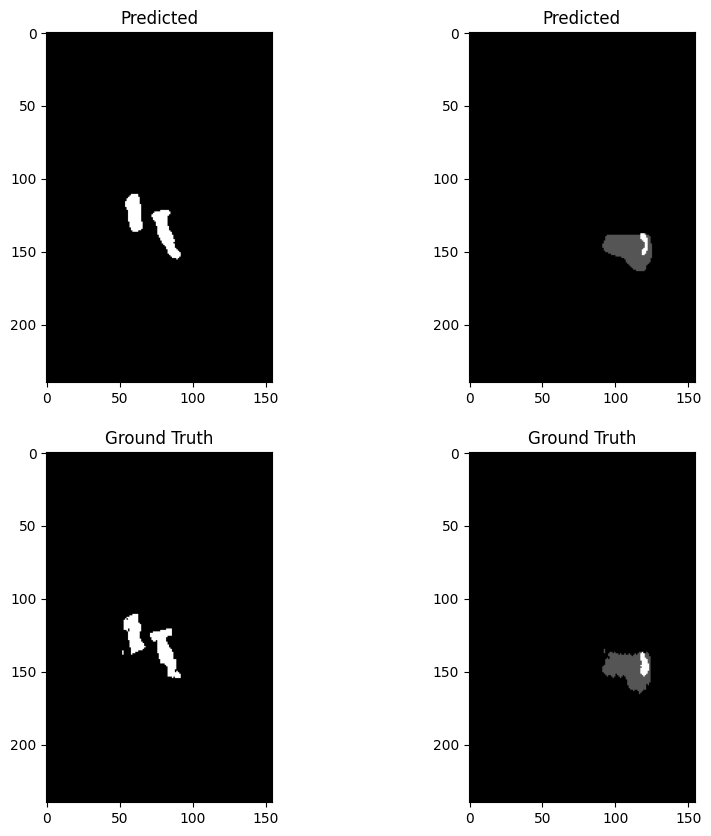

100%|██████████| 39/39 [02:12<00:00,  3.39s/it]


Average Validation Loss: 0.018104920068230383

Average Validation DSC: [0.99805338 0.81886078 0.88538503 0.64828885]
Average Validation ASSD: [ 0.19187061 24.9797504  22.55503895 27.7781269 ]
Epoch 23/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


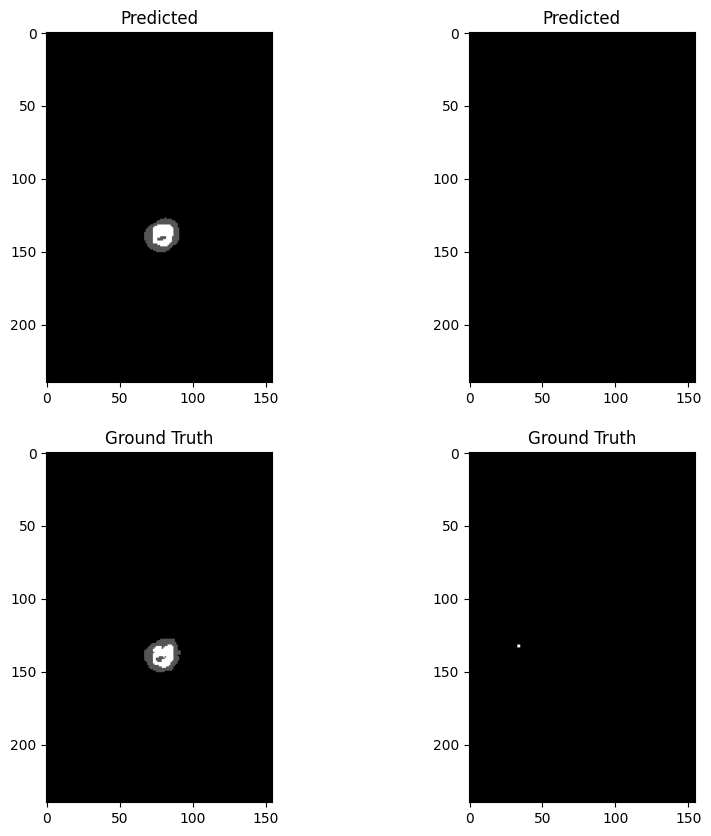

100%|██████████| 156/156 [09:10<00:00,  3.53s/it]



Average Training Loss: 0.014922667479811188

Average Training DSC: [0.99825875 0.83925959 0.89764434 0.63537172]
Average Training ASSD: [ 0.176263   22.41088336 18.92469634 46.3737271 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


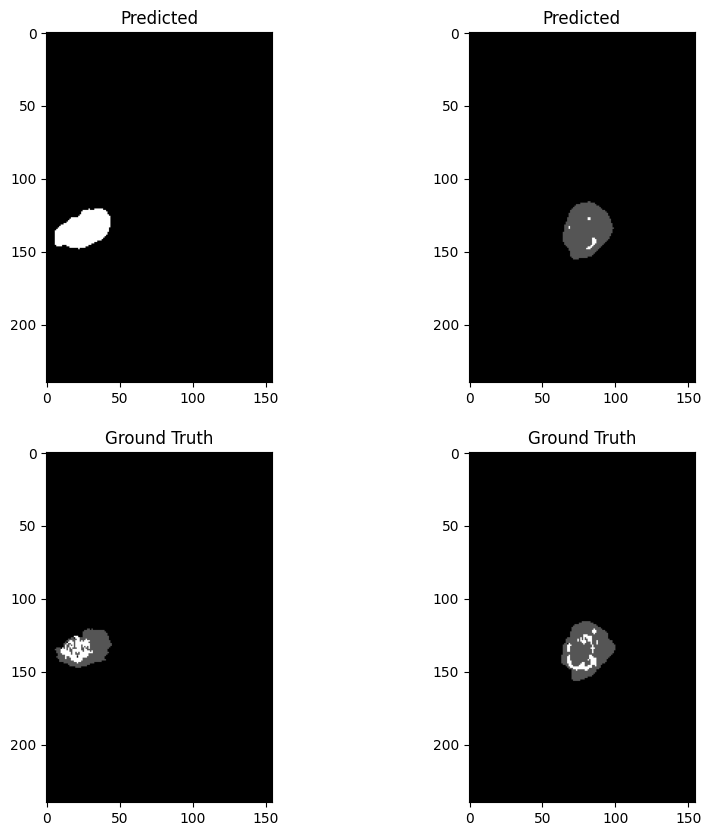

100%|██████████| 39/39 [02:10<00:00,  3.35s/it]


Average Validation Loss: 0.017860168901582558

Average Validation DSC: [0.99815012 0.77249765 0.88828201 0.5866028 ]
Average Validation ASSD: [ 0.19562992 44.09773983 22.42888515 52.88313362]
Epoch 24/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


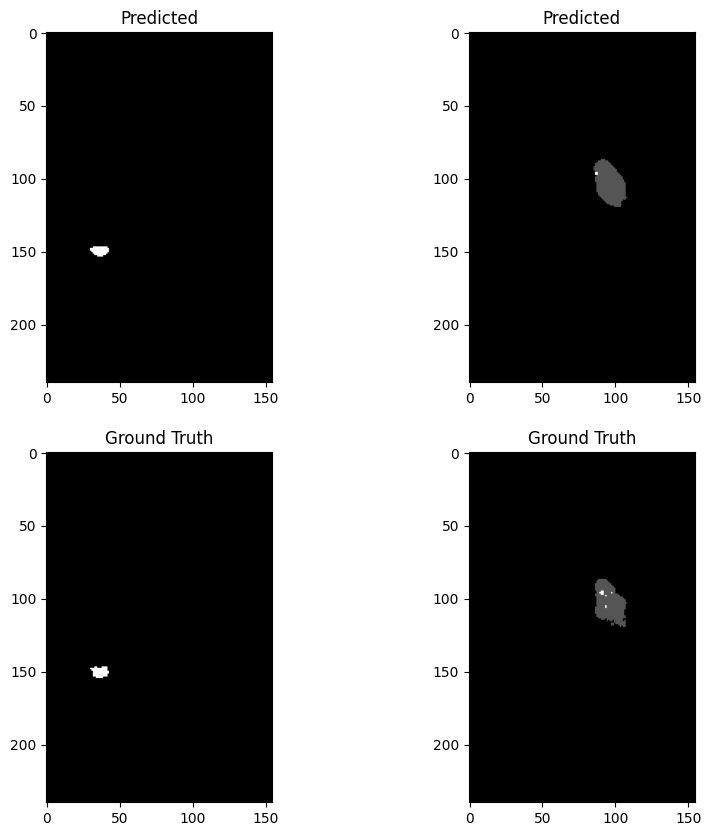

100%|██████████| 156/156 [09:12<00:00,  3.54s/it]



Average Training Loss: 0.013767299773649145

Average Training DSC: [0.99840649 0.8497096  0.90807125 0.64838824]
Average Training ASSD: [ 0.16172919 19.99423448 16.82999275 45.90772195]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


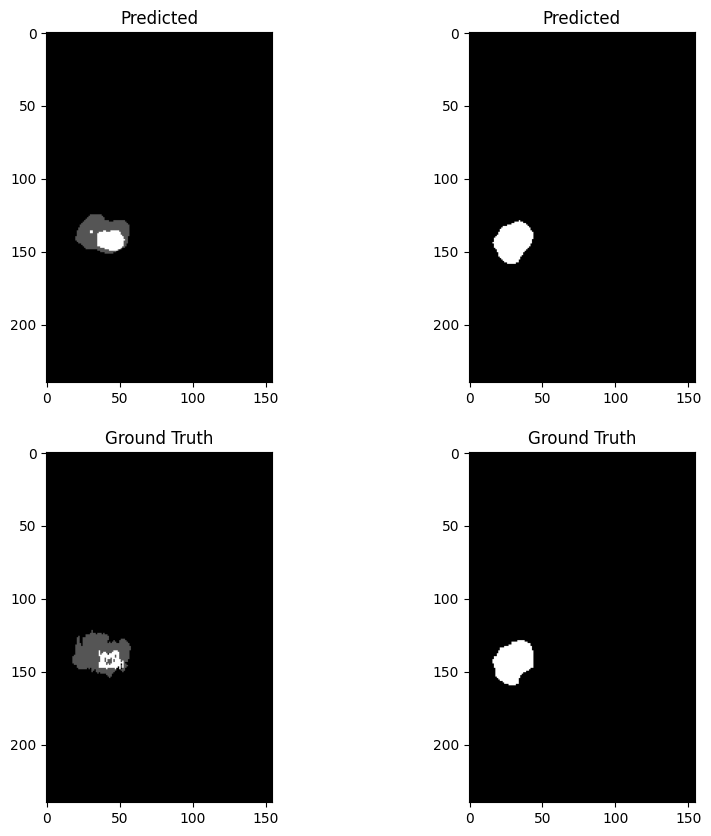

100%|██████████| 39/39 [02:10<00:00,  3.35s/it]


Average Validation Loss: 0.018418925885970775

Average Validation DSC: [0.99797229 0.81593767 0.88864756 0.64410359]
Average Validation ASSD: [ 0.22386149 23.52897733 20.46771146 40.56775185]
Epoch 25/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


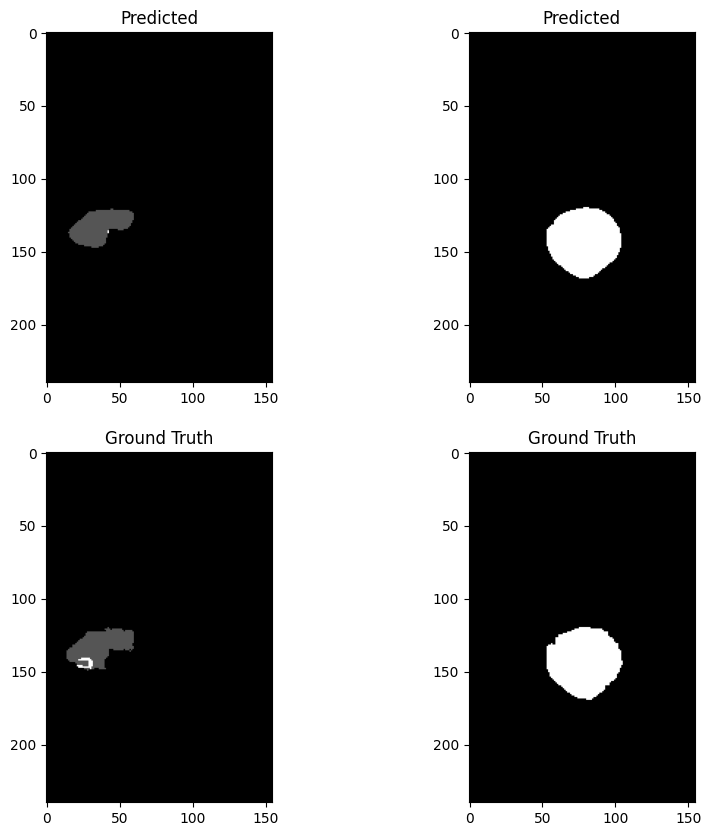

100%|██████████| 156/156 [09:25<00:00,  3.63s/it]



Average Training Loss: 0.013263888728733245

Average Training DSC: [0.9984585  0.85453478 0.90773841 0.66138868]
Average Training ASSD: [ 0.15423071 18.91271778 16.19813367 43.8097857 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


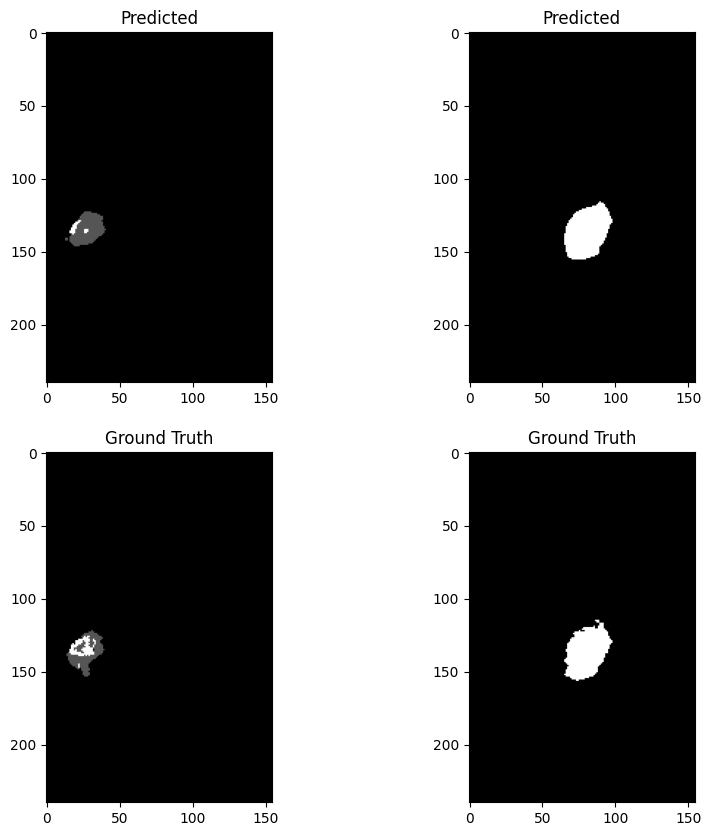

100%|██████████| 39/39 [02:20<00:00,  3.61s/it]


Average Validation Loss: 0.0174829865543124

Average Validation DSC: [0.9981581  0.82102951 0.8992779  0.6069069 ]
Average Validation ASSD: [ 0.1759585  27.88087294 18.71760281 43.96308622]
Epoch 26/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


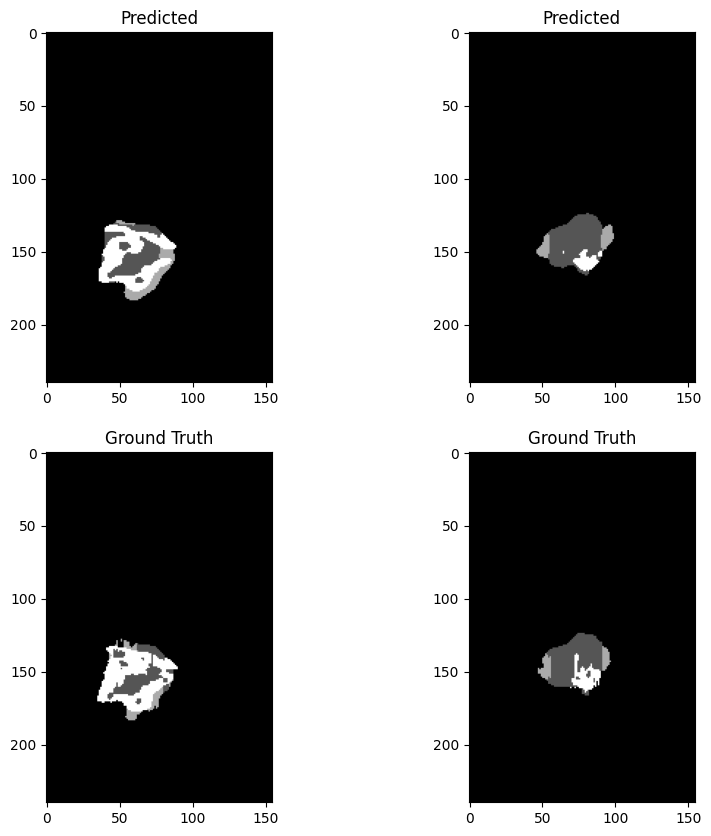

100%|██████████| 156/156 [09:53<00:00,  3.81s/it]



Average Training Loss: 0.013083204835987626

Average Training DSC: [0.99845917 0.85884156 0.90989232 0.66136497]
Average Training ASSD: [ 0.15224441 17.64546154 15.99413471 43.65168504]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


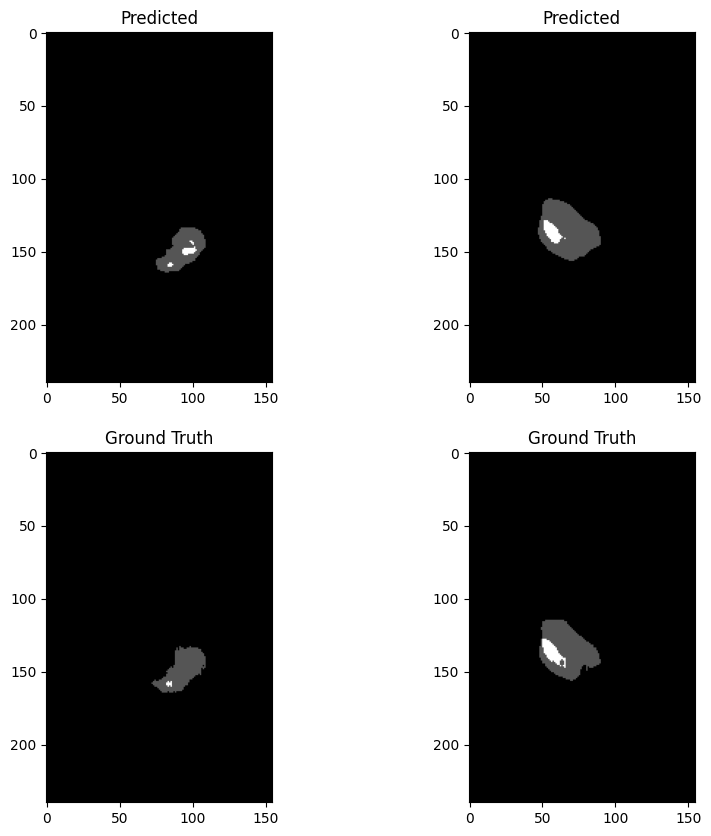

100%|██████████| 39/39 [02:22<00:00,  3.66s/it]


Average Validation Loss: 0.01641693661132684

Average Validation DSC: [0.99820881 0.81983473 0.88866079 0.65762521]
Average Validation ASSD: [ 0.18025563 27.82541322 21.61730573 35.71517842]
Epoch 27/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


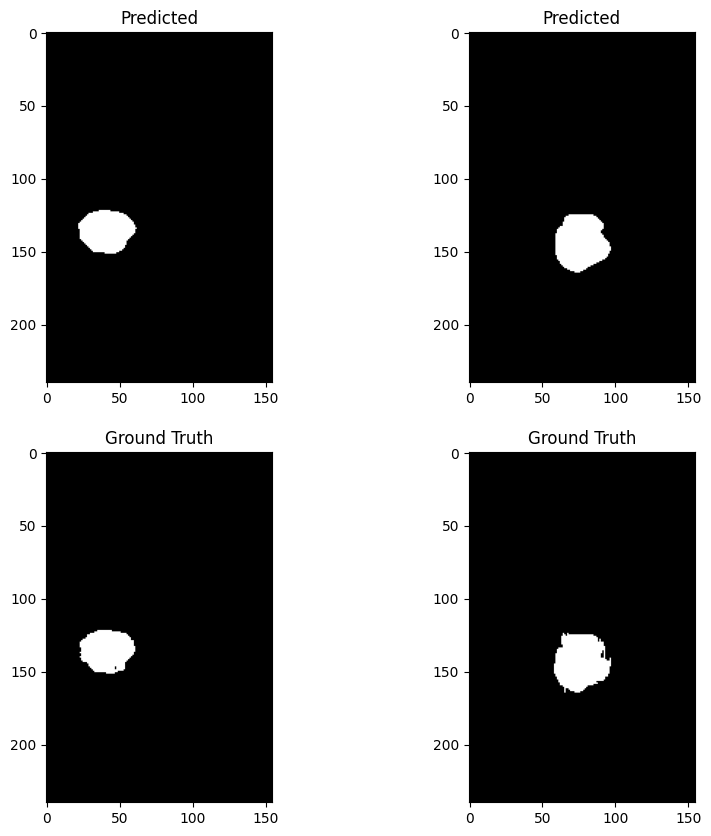

100%|██████████| 156/156 [09:42<00:00,  3.74s/it]



Average Training Loss: 0.012555618042078538

Average Training DSC: [0.99851299 0.86803741 0.91117262 0.67557086]
Average Training ASSD: [ 0.14848956 16.42331187 15.86897848 43.180576  ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


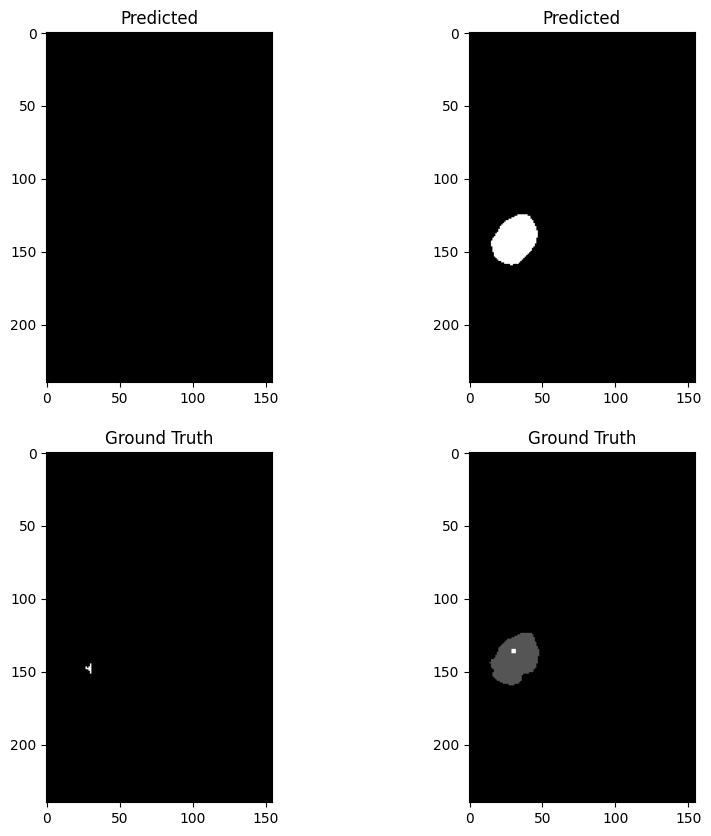

100%|██████████| 39/39 [02:14<00:00,  3.46s/it]


Average Validation Loss: 0.016111936730643112

Average Validation DSC: [0.99827929 0.83208919 0.90071722 0.64307403]
Average Validation ASSD: [ 0.17254955 26.56872172 18.70830246 44.50952105]
Epoch 28/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


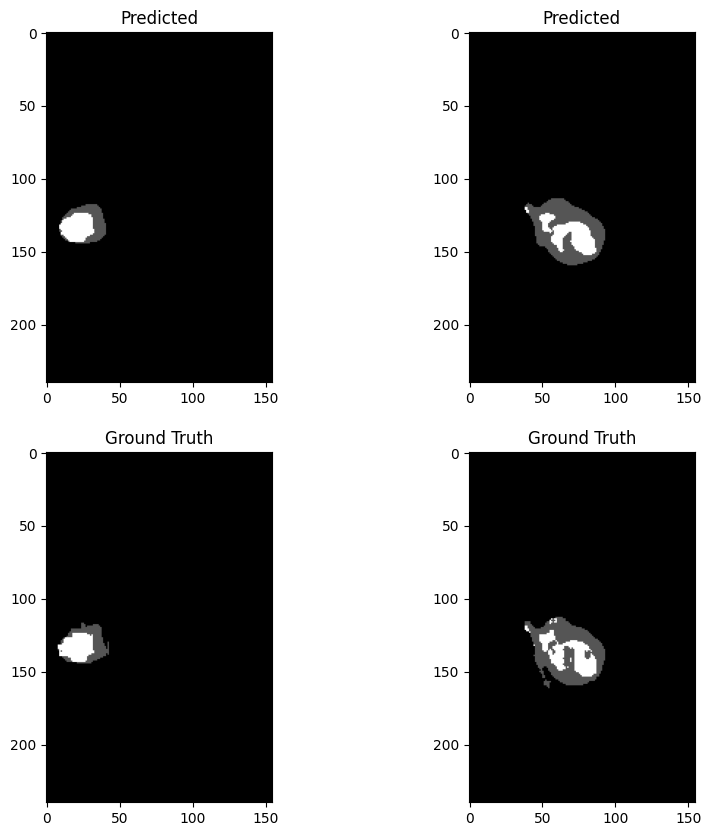

100%|██████████| 156/156 [09:33<00:00,  3.68s/it]



Average Training Loss: 0.013073943955346178

Average Training DSC: [0.99849819 0.86039152 0.90759469 0.6740337 ]
Average Training ASSD: [ 0.15001412 18.27538029 16.5678794  40.68771867]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


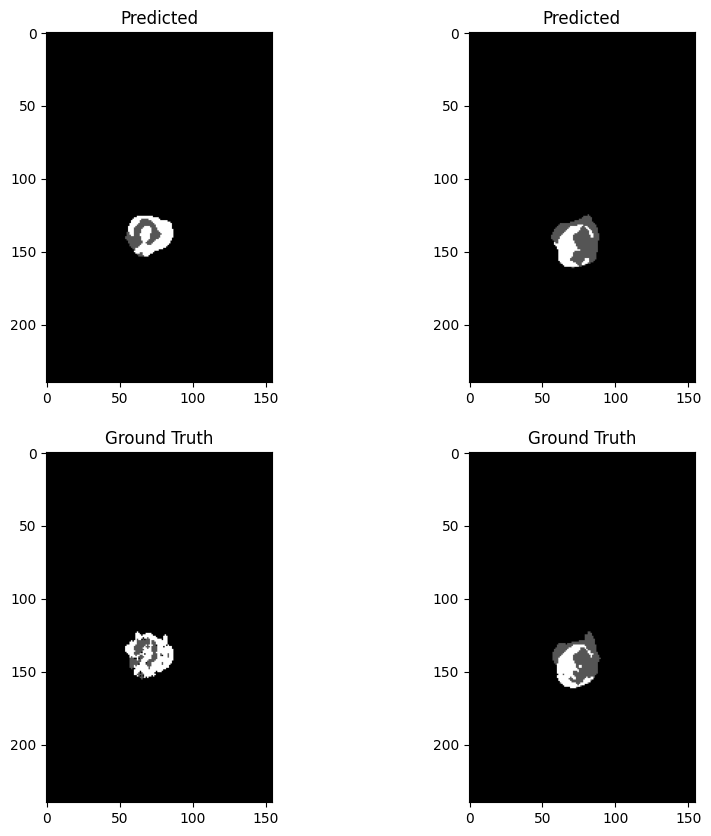

100%|██████████| 39/39 [02:20<00:00,  3.59s/it]


Average Validation Loss: 0.015585504424495574

Average Validation DSC: [0.99827802 0.83594639 0.90052823 0.66471823]
Average Validation ASSD: [ 0.17489781 24.8495544  17.60822231 40.0128903 ]
Epoch 29/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


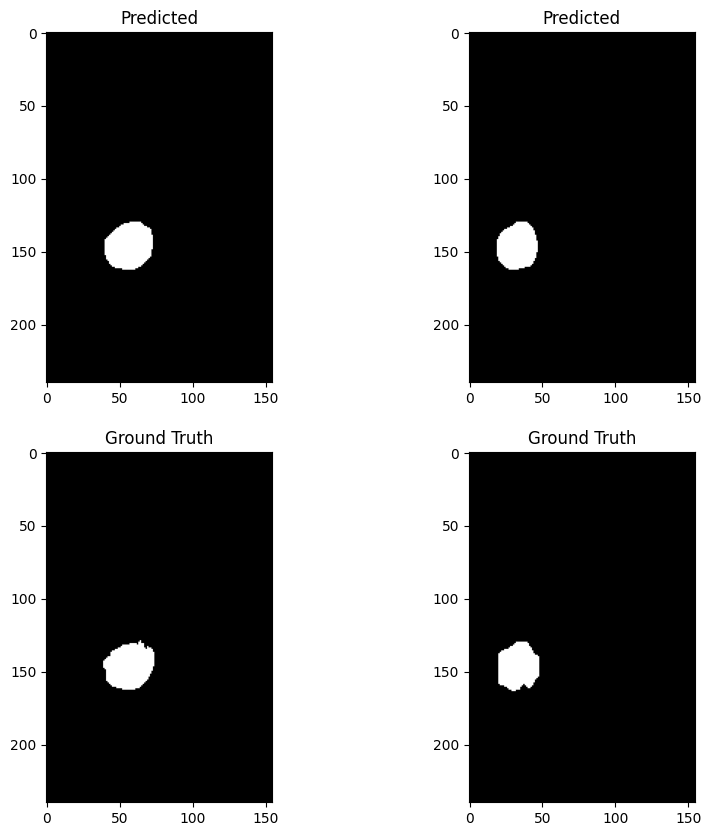

100%|██████████| 156/156 [09:52<00:00,  3.80s/it]



Average Training Loss: 0.011949063466790203

Average Training DSC: [0.99860799 0.87475645 0.91715351 0.68811259]
Average Training ASSD: [ 0.134933   15.82087271 13.61030704 40.1777648 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


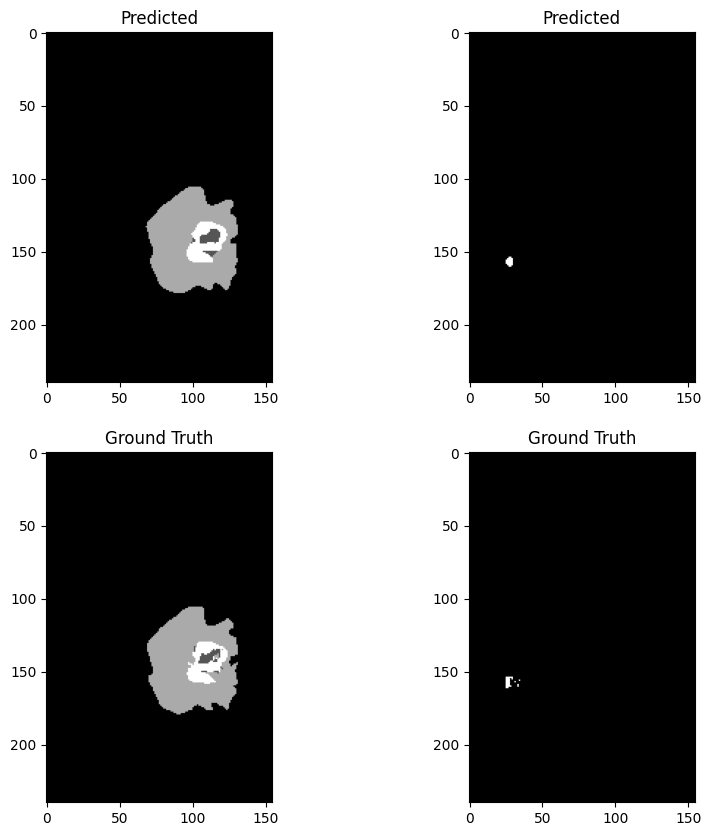

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.01532307938218881

Average Validation DSC: [0.99842338 0.83147978 0.89791676 0.64860128]
Average Validation ASSD: [ 0.15257311 26.69509625 19.33054129 45.04792653]
Epoch 30/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


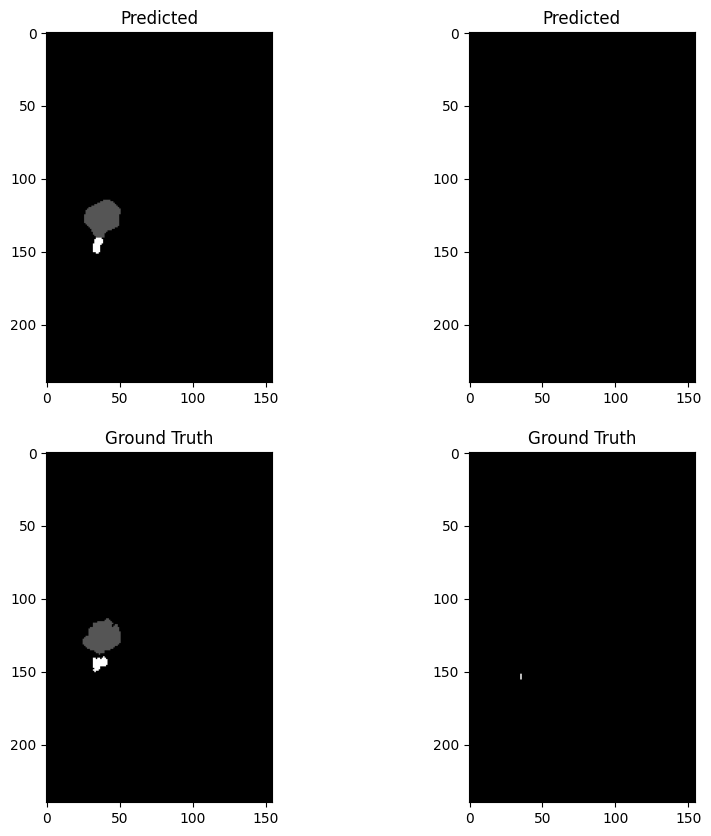

100%|██████████| 156/156 [09:38<00:00,  3.71s/it]



Average Training Loss: 0.012196387292650074

Average Training DSC: [0.99859316 0.86801303 0.91820718 0.68144053]
Average Training ASSD: [ 0.13805041 15.97895541 13.297401   40.4957763 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


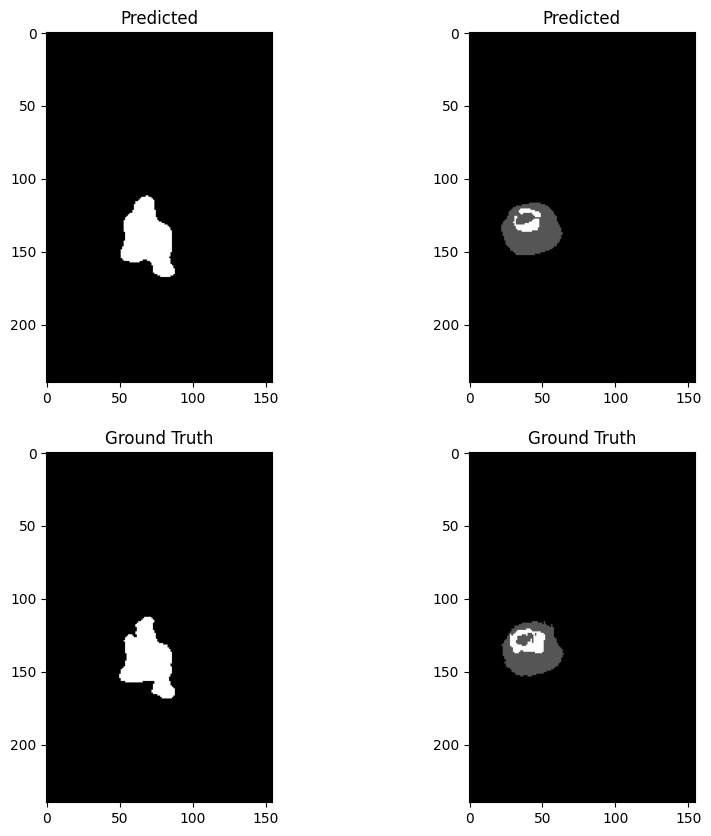

100%|██████████| 39/39 [02:24<00:00,  3.71s/it]


Average Validation Loss: 0.014388398530009465

Average Validation DSC: [0.99842986 0.83885146 0.90941921 0.67924651]
Average Validation ASSD: [ 0.14929547 27.65923258 15.18719619 32.96805985]
Epoch 31/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


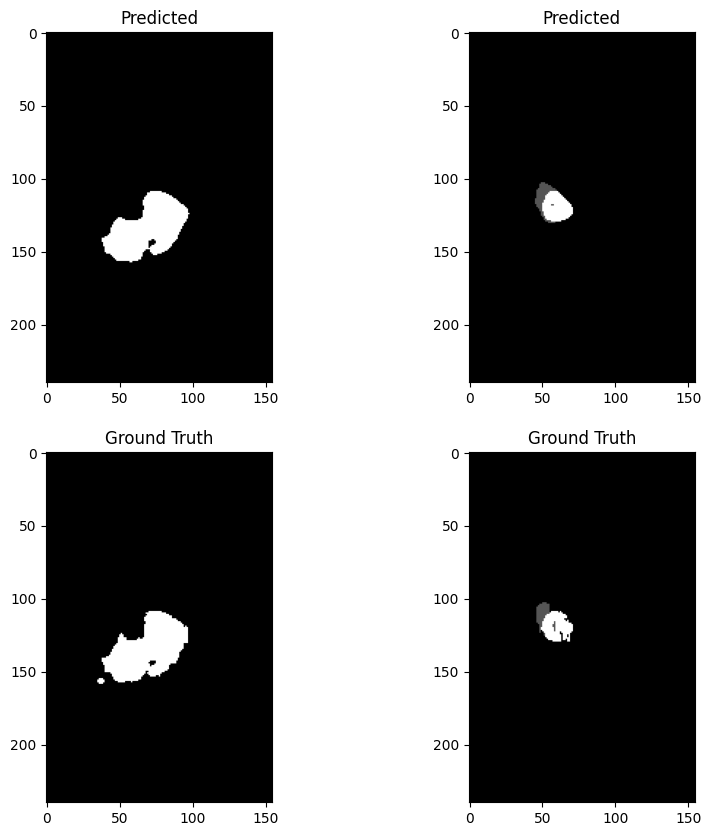

100%|██████████| 156/156 [09:48<00:00,  3.77s/it]



Average Training Loss: 0.011467077467853252

Average Training DSC: [0.99864767 0.88197568 0.91669577 0.69334139]
Average Training ASSD: [ 0.13266687 13.25014912 13.34185036 39.87975845]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


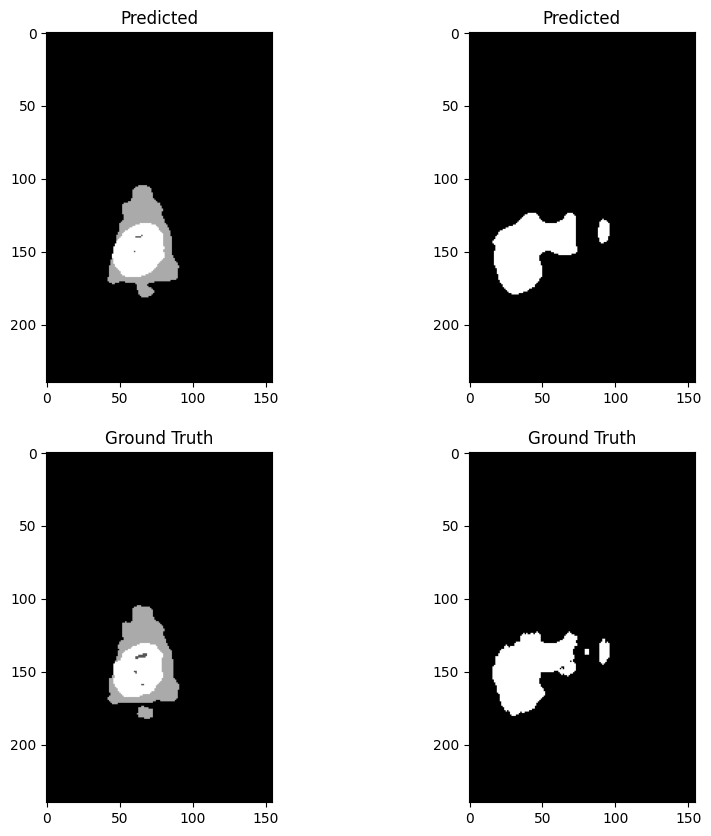

100%|██████████| 39/39 [02:20<00:00,  3.59s/it]


Average Validation Loss: 0.014759868932649111

Average Validation DSC: [0.99843141 0.8483467  0.90545222 0.68311498]
Average Validation ASSD: [ 0.15865231 23.53116497 16.35098672 36.72235815]
Epoch 32/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


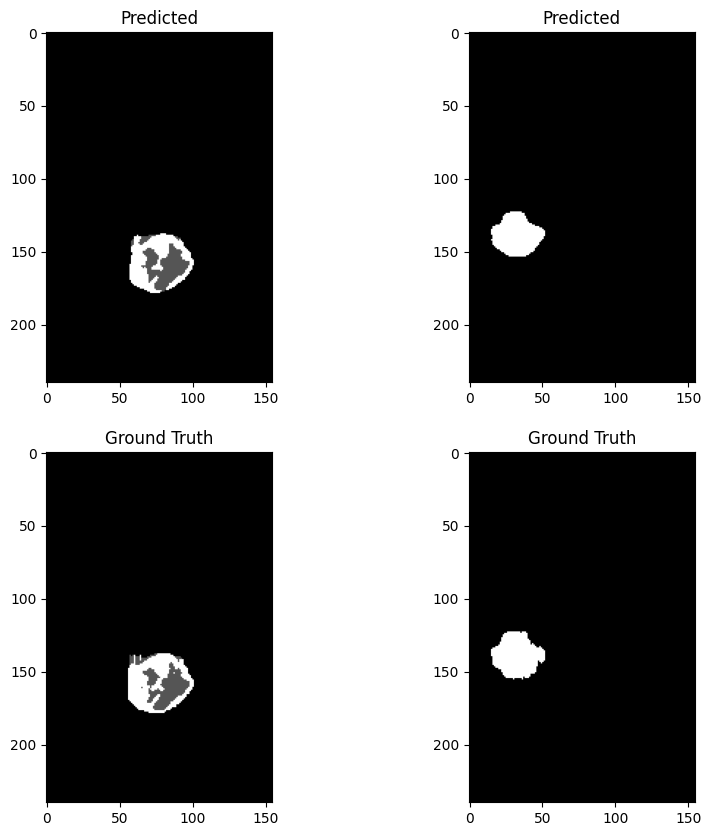

100%|██████████| 156/156 [09:42<00:00,  3.74s/it]



Average Training Loss: 0.01318963626339936

Average Training DSC: [0.99846145 0.85404671 0.90640696 0.67406223]
Average Training ASSD: [ 0.15880704 20.72550013 16.22380688 41.22372984]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


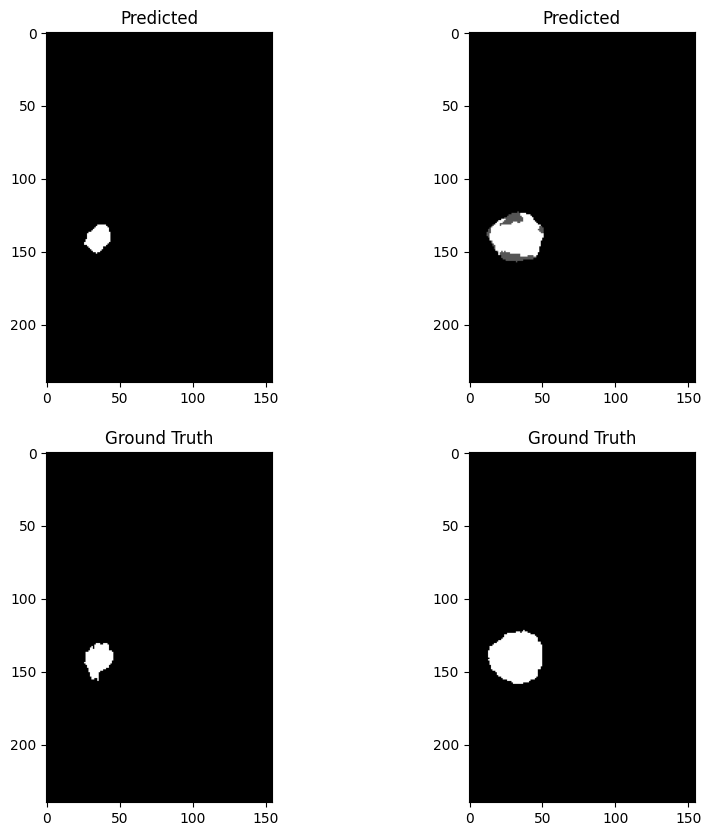

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.015102245009098297

Average Validation DSC: [0.99837205 0.81702836 0.89542935 0.66186519]
Average Validation ASSD: [ 0.16883287 34.29454605 19.79888985 44.9335979 ]
Epoch 33/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


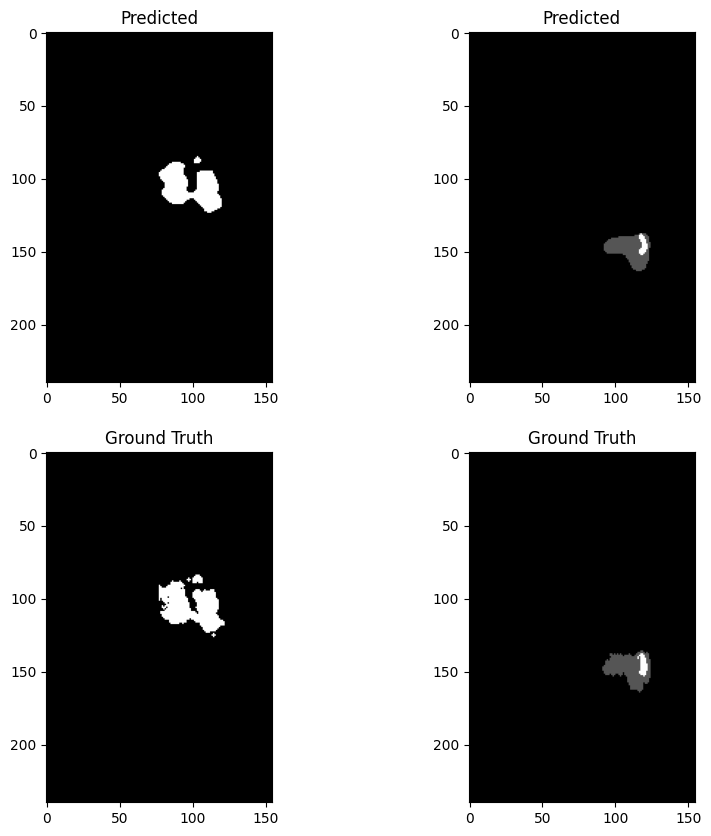

100%|██████████| 156/156 [09:34<00:00,  3.68s/it]



Average Training Loss: 0.01169326604427531

Average Training DSC: [0.99862363 0.87577039 0.91349436 0.69267065]
Average Training ASSD: [ 0.13521093 15.73038619 14.26953364 39.82438205]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


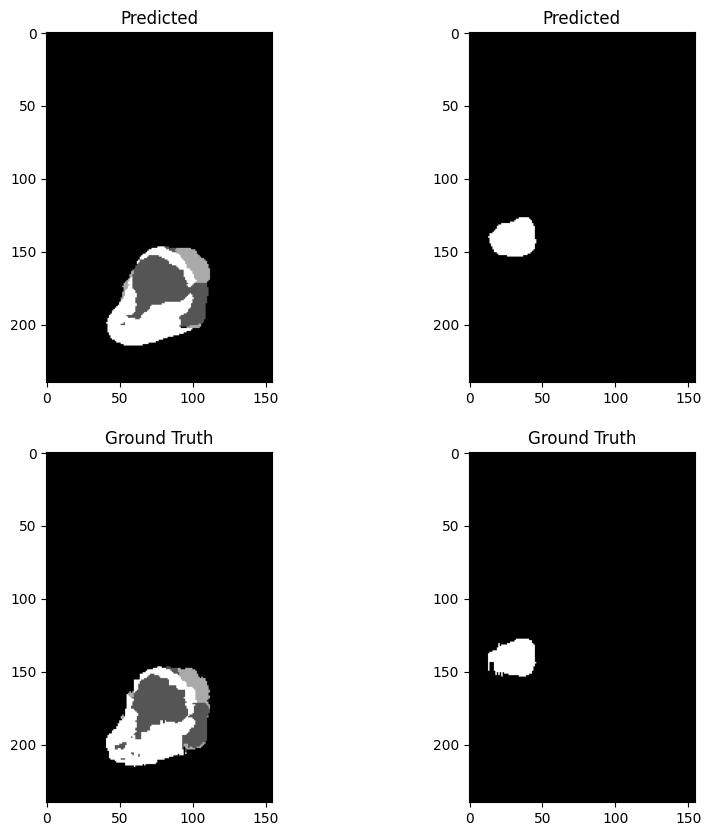

100%|██████████| 39/39 [02:21<00:00,  3.63s/it]


Average Validation Loss: 0.014085907954722643

Average Validation DSC: [0.99851928 0.86321617 0.9105223  0.70751352]
Average Validation ASSD: [ 0.14355096 18.91689114 16.89717098 28.91607146]
Epoch 34/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


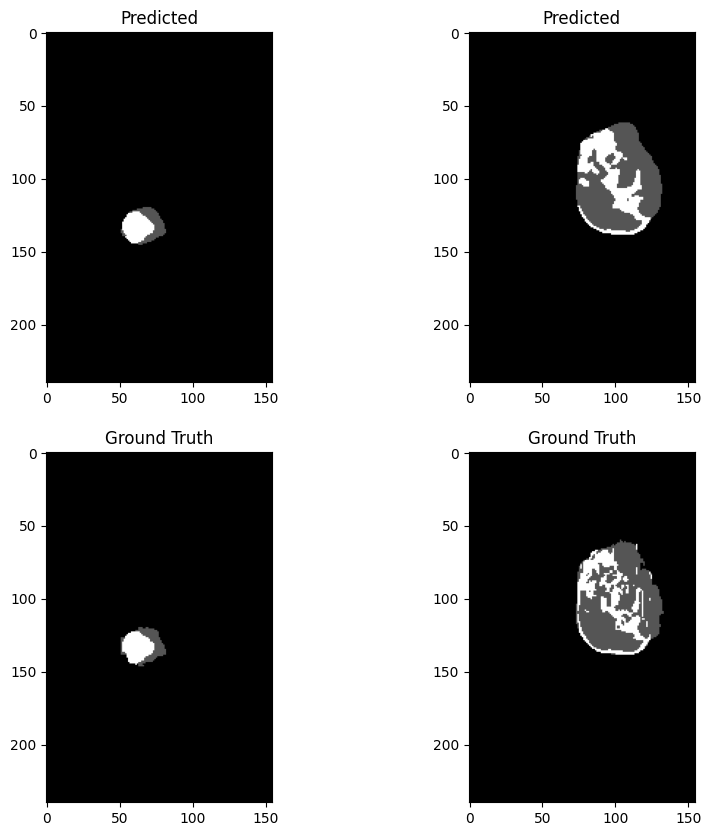

100%|██████████| 156/156 [09:45<00:00,  3.75s/it]



Average Training Loss: 0.010443925597848227

Average Training DSC: [0.99877778 0.89493265 0.92287598 0.71082535]
Average Training ASSD: [ 0.11978115 10.65951777 12.68374426 39.19001902]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


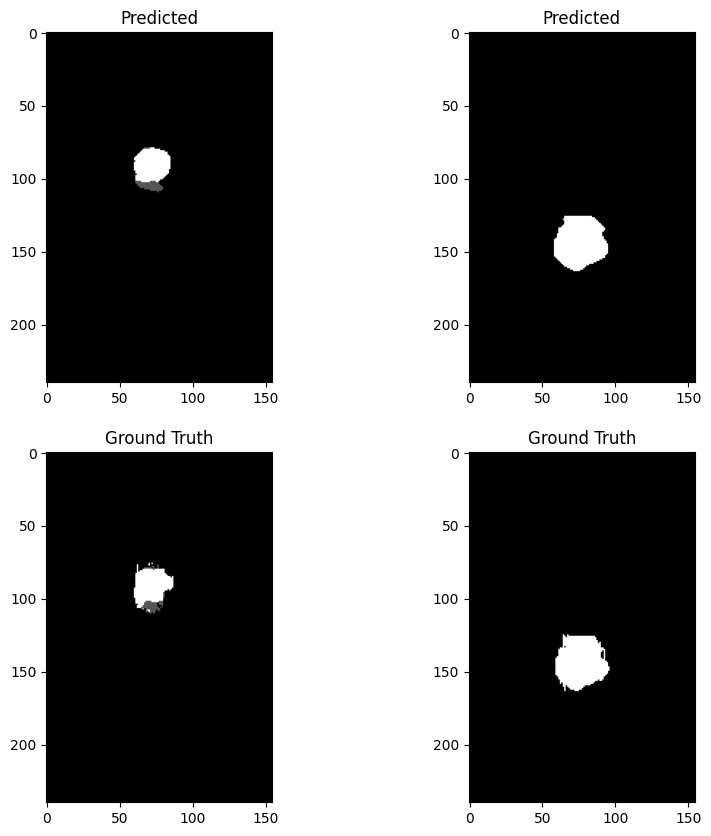

100%|██████████| 39/39 [02:17<00:00,  3.54s/it]


Average Validation Loss: 0.013838541395484637

Average Validation DSC: [0.99852931 0.86191573 0.91264756 0.70198141]
Average Validation ASSD: [ 0.1391206  20.32581044 14.23110248 31.51631267]
Epoch 35/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


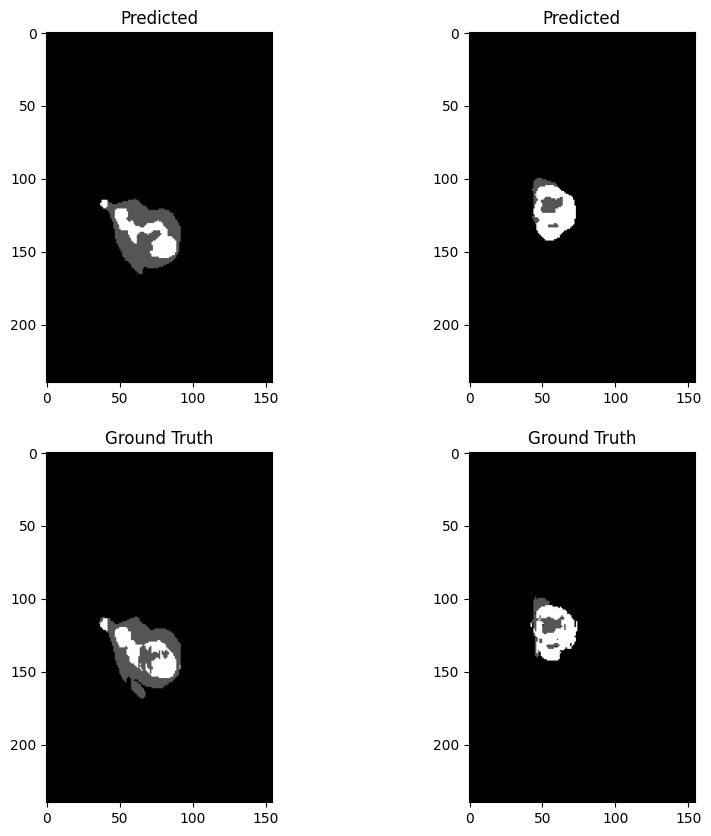

100%|██████████| 156/156 [09:52<00:00,  3.80s/it]



Average Training Loss: 0.010704496266463628

Average Training DSC: [0.99873013 0.89118362 0.91835292 0.71083684]
Average Training ASSD: [ 0.12277727 12.25651953 13.70914092 37.80359846]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


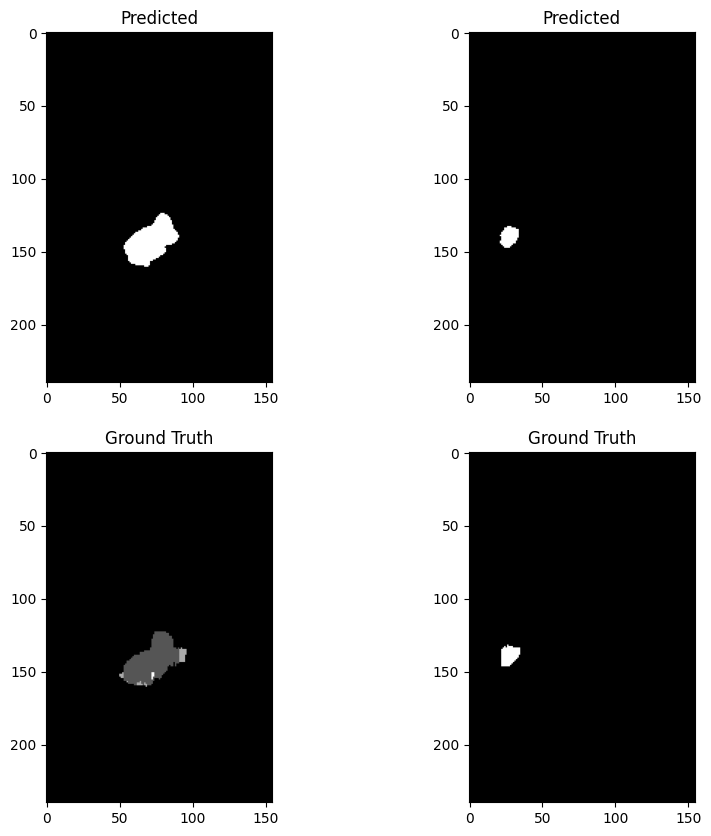

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.01433029269369749

Average Validation DSC: [0.99850955 0.8594145  0.90965359 0.69922426]
Average Validation ASSD: [ 0.1461147  19.15975546 16.3135947  33.64211405]
Epoch 36/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


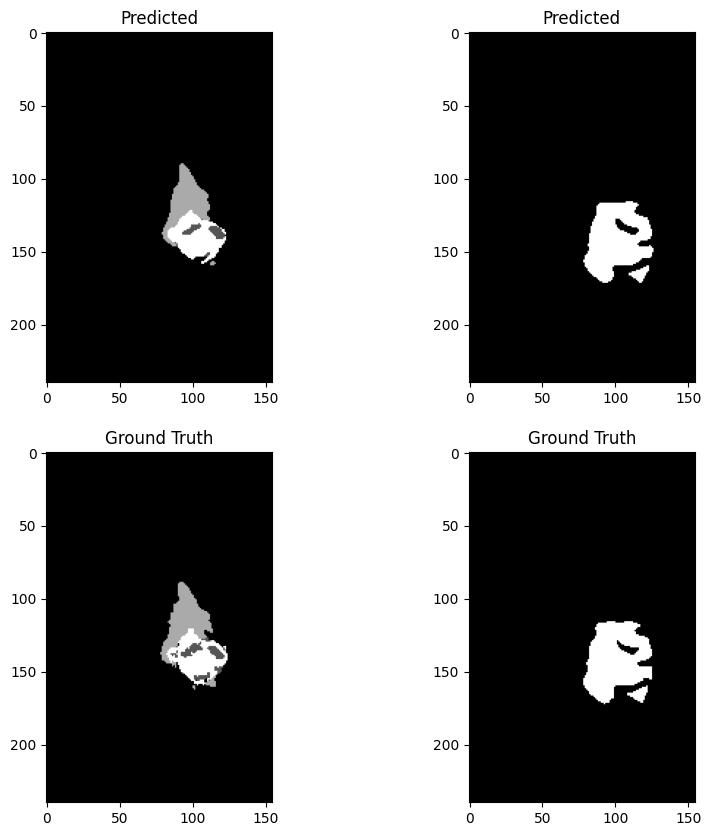

100%|██████████| 156/156 [09:55<00:00,  3.82s/it]



Average Training Loss: 0.010221950453109084

Average Training DSC: [0.99881518 0.89631522 0.92362985 0.71769239]
Average Training ASSD: [ 0.11501557 10.72300178 11.42521212 39.12563346]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


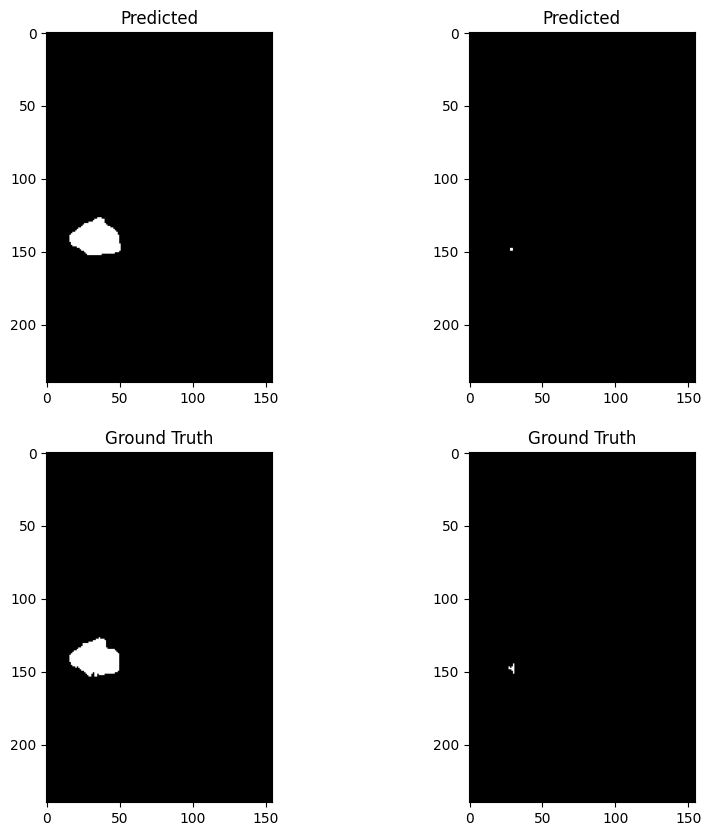

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.014558600166287178

Average Validation DSC: [0.99850574 0.81895582 0.90976511 0.70517503]
Average Validation ASSD: [ 0.14332076 30.99972384 15.56861267 29.19928257]
Epoch 37/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


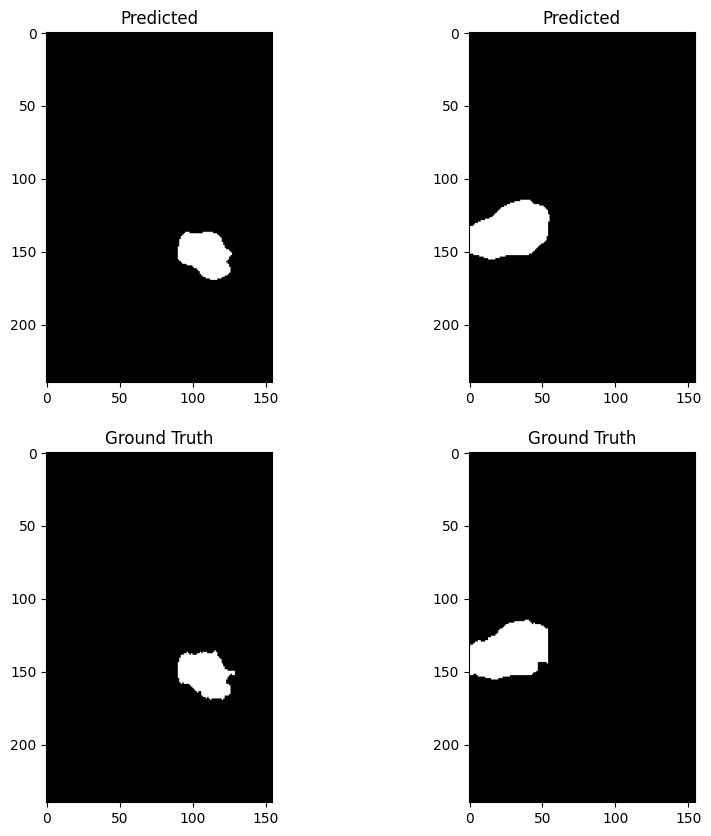

100%|██████████| 156/156 [09:45<00:00,  3.75s/it]



Average Training Loss: 0.009790662067154279

Average Training DSC: [0.9988383  0.90219932 0.92842798 0.72281022]
Average Training ASSD: [ 0.11217886 10.04532891 10.56605501 38.32570191]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


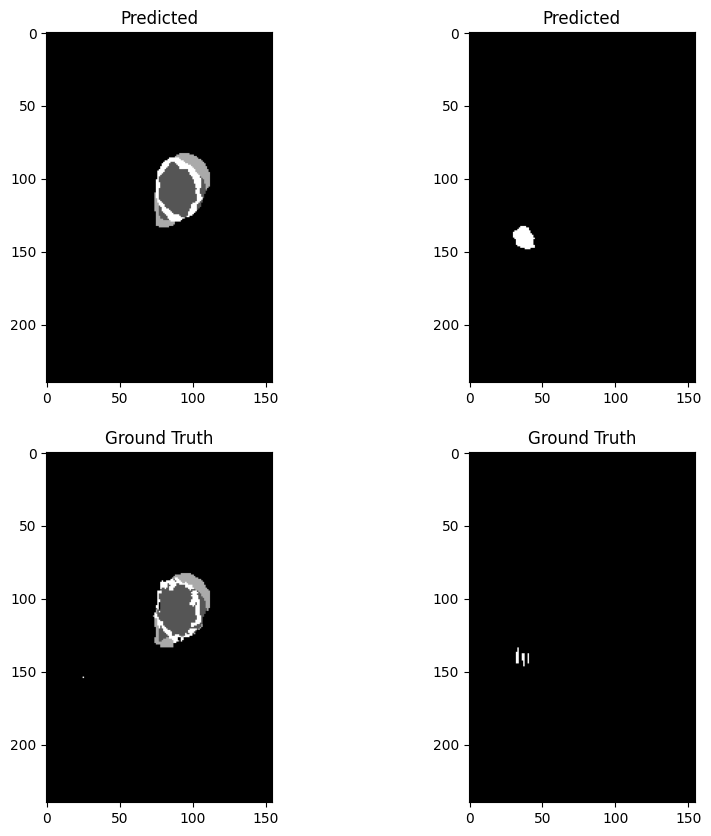

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.014022464266954323

Average Validation DSC: [0.99856147 0.86970036 0.91477097 0.71835848]
Average Validation ASSD: [ 0.13294823 18.03204273 15.13065153 23.730079  ]
Epoch 38/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


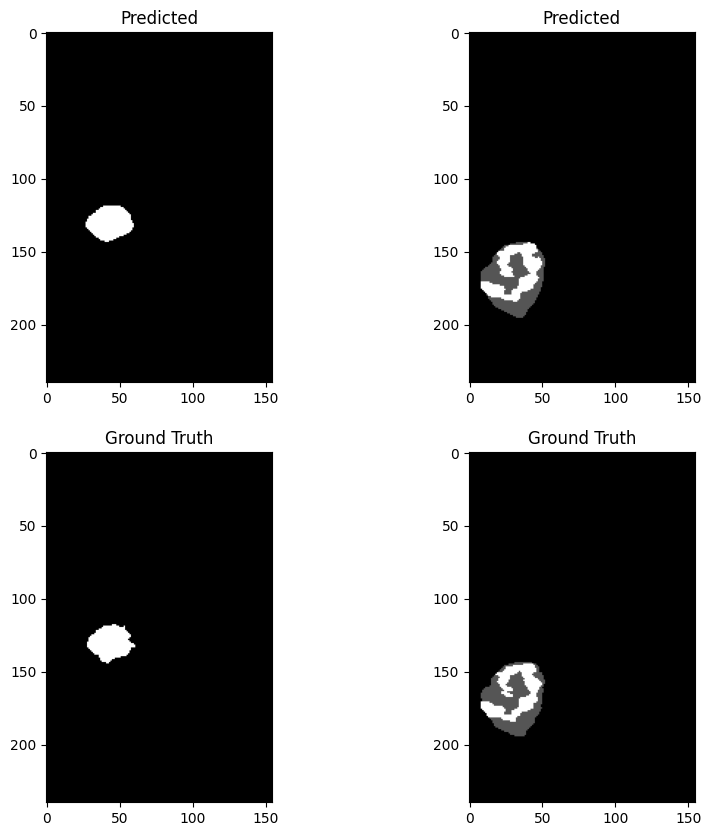

100%|██████████| 156/156 [09:31<00:00,  3.66s/it]



Average Training Loss: 0.009875924084693767

Average Training DSC: [0.99882385 0.90182152 0.92621298 0.72612973]
Average Training ASSD: [ 0.11293907  9.75823453 11.01023493 37.0329036 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


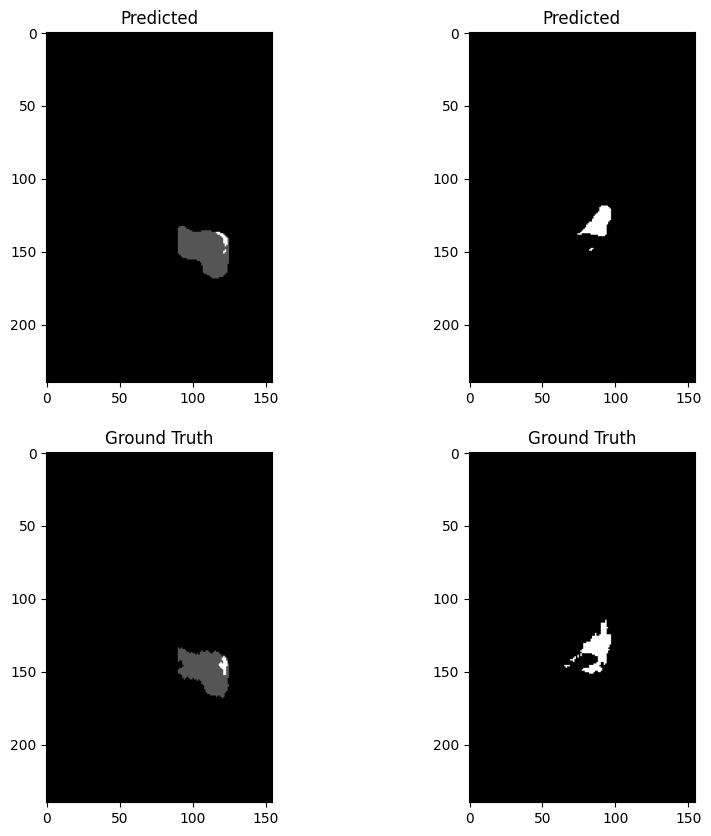

100%|██████████| 39/39 [02:11<00:00,  3.38s/it]


Average Validation Loss: 0.01390732810474359

Average Validation DSC: [0.99856153 0.85385261 0.91183991 0.69529779]
Average Validation ASSD: [ 0.14131849 24.14223646 13.15033674 33.25259754]
Epoch 39/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


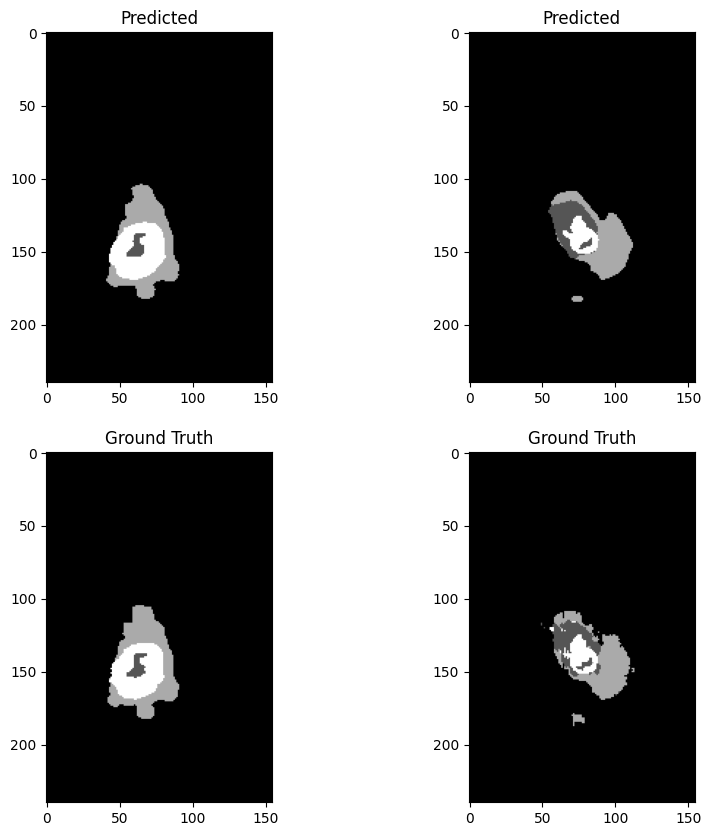

100%|██████████| 156/156 [09:46<00:00,  3.76s/it]



Average Training Loss: 0.011275566421831265

Average Training DSC: [0.99871258 0.88128089 0.91666245 0.71027827]
Average Training ASSD: [ 0.12587291 15.09045033 13.85381381 36.0217772 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


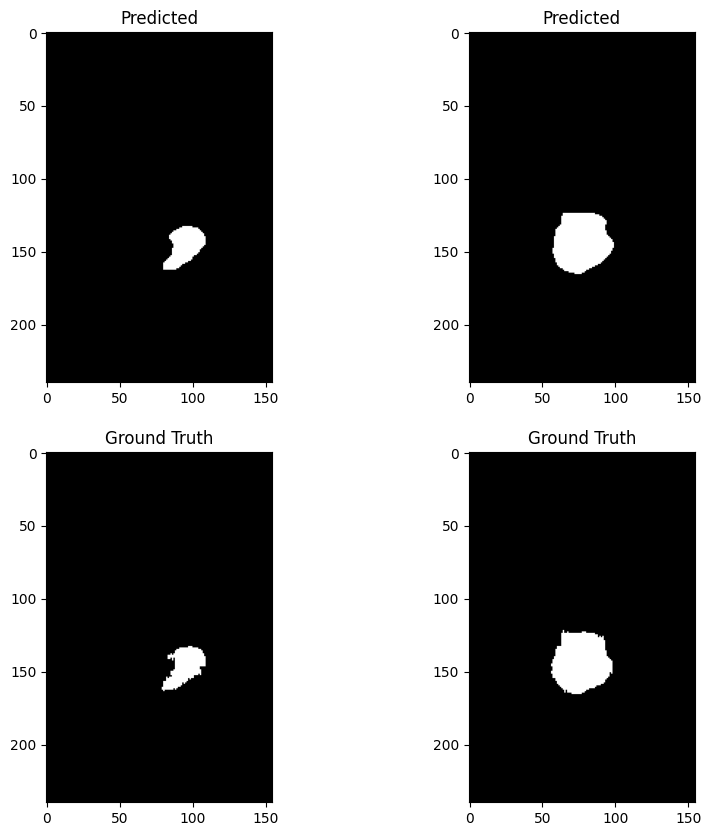

100%|██████████| 39/39 [02:21<00:00,  3.64s/it]


Average Validation Loss: 0.013967731836228034

Average Validation DSC: [0.99854744 0.86418242 0.91231388 0.68087859]
Average Validation ASSD: [ 0.15502522 21.46033617 15.08156669 46.2987415 ]
Epoch 40/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


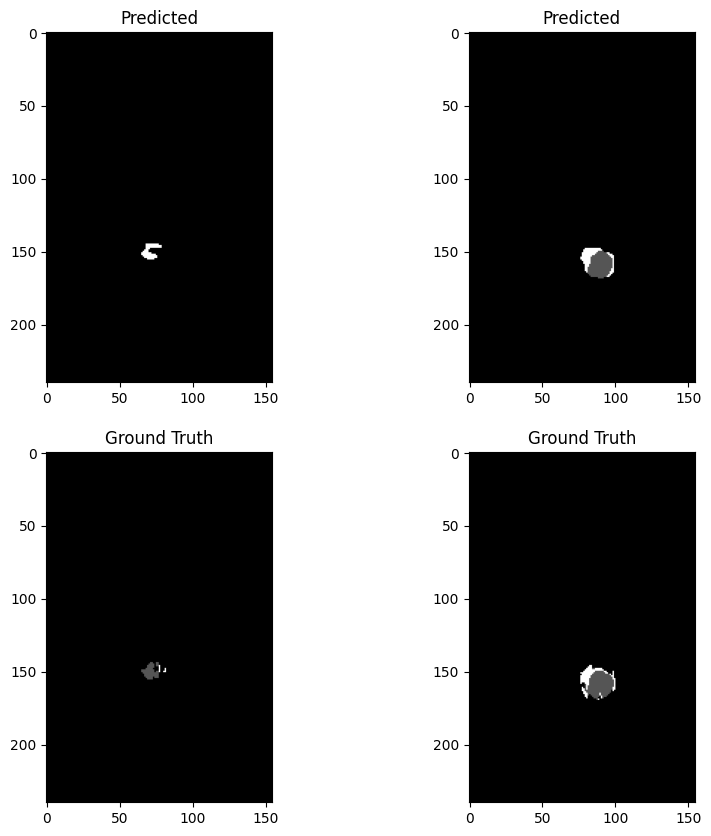

100%|██████████| 156/156 [09:41<00:00,  3.72s/it]



Average Training Loss: 0.00969875347502052

Average Training DSC: [0.99888155 0.9039925  0.92641446 0.7264102 ]
Average Training ASSD: [ 0.10741759 10.07887411 11.67718625 37.25292754]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


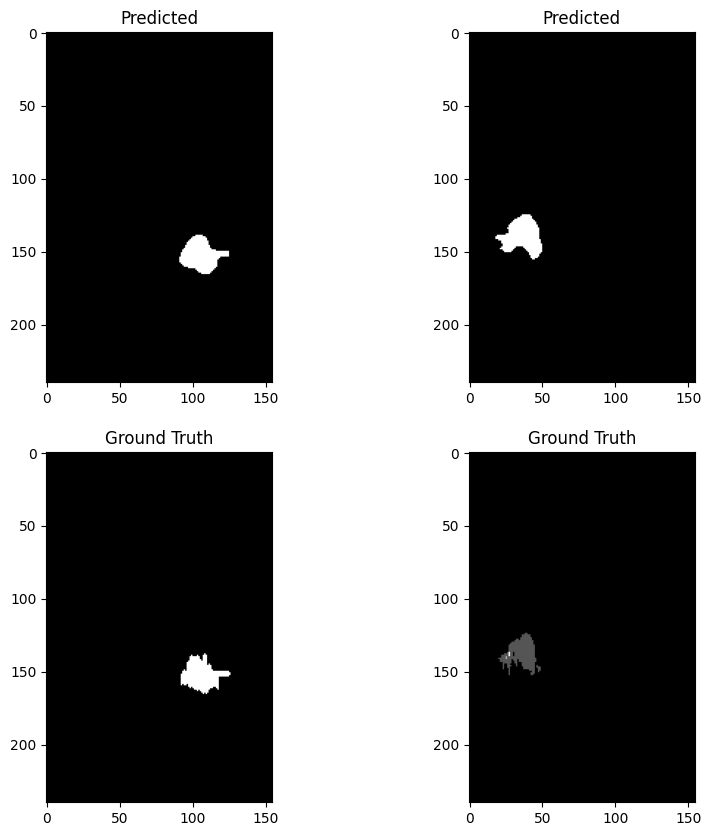

100%|██████████| 39/39 [02:14<00:00,  3.44s/it]


Average Validation Loss: 0.013266314621059557

Average Validation DSC: [0.99862106 0.87101312 0.91290095 0.72125467]
Average Validation ASSD: [ 0.13067889 18.57038558 15.65919292 32.22923713]
Epoch 41/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


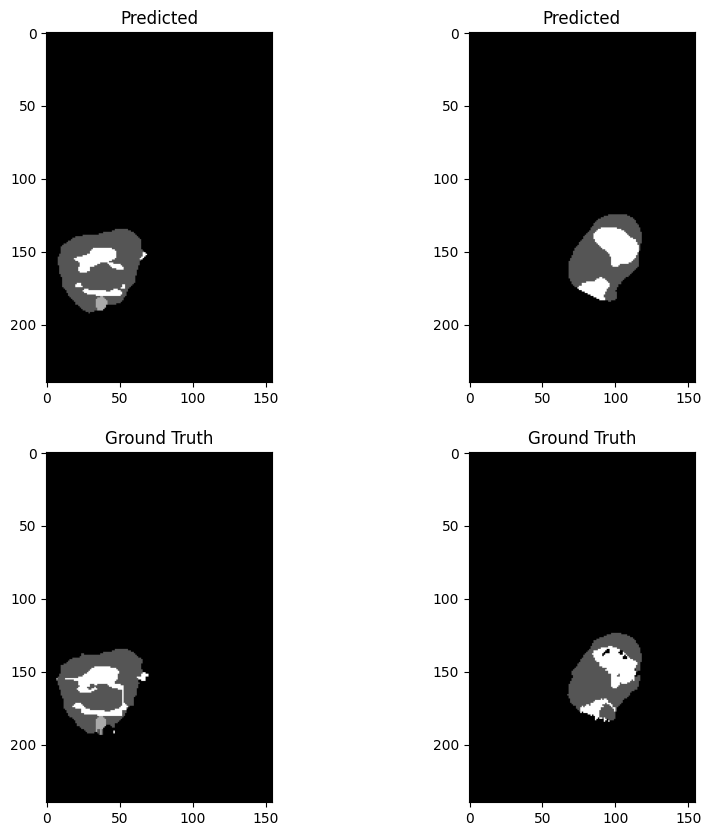

100%|██████████| 156/156 [09:37<00:00,  3.70s/it]



Average Training Loss: 0.010125702193293434

Average Training DSC: [0.99883084 0.8905491  0.92256621 0.72434811]
Average Training ASSD: [ 0.11777045 13.46827923 12.17290101 36.34107505]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


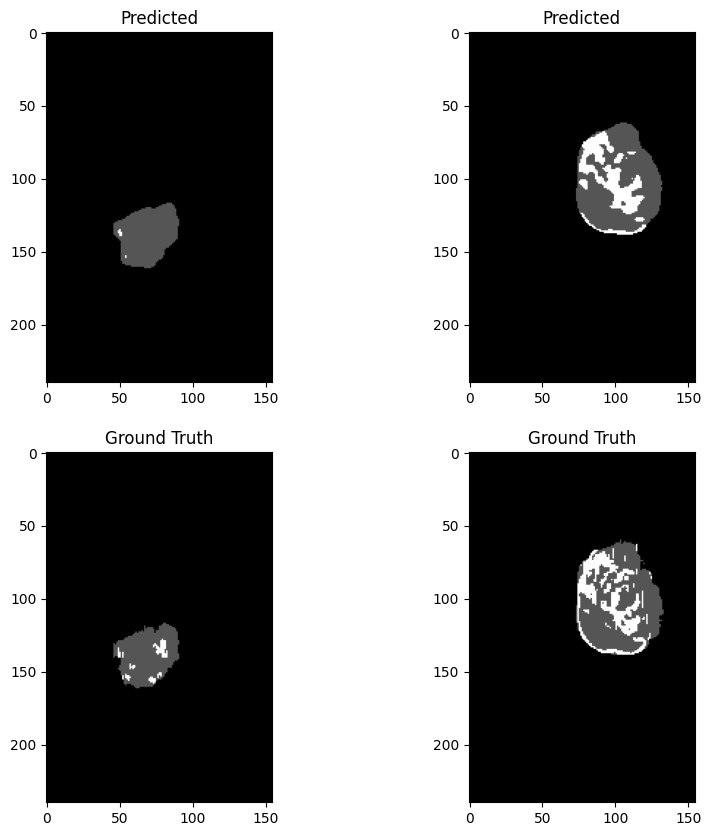

100%|██████████| 39/39 [02:15<00:00,  3.47s/it]


Average Validation Loss: 0.013776723247690078

Average Validation DSC: [0.9985559  0.85614884 0.89845001 0.70287275]
Average Validation ASSD: [ 0.14038002 24.36496979 17.88907929 31.05526029]
Epoch 42/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


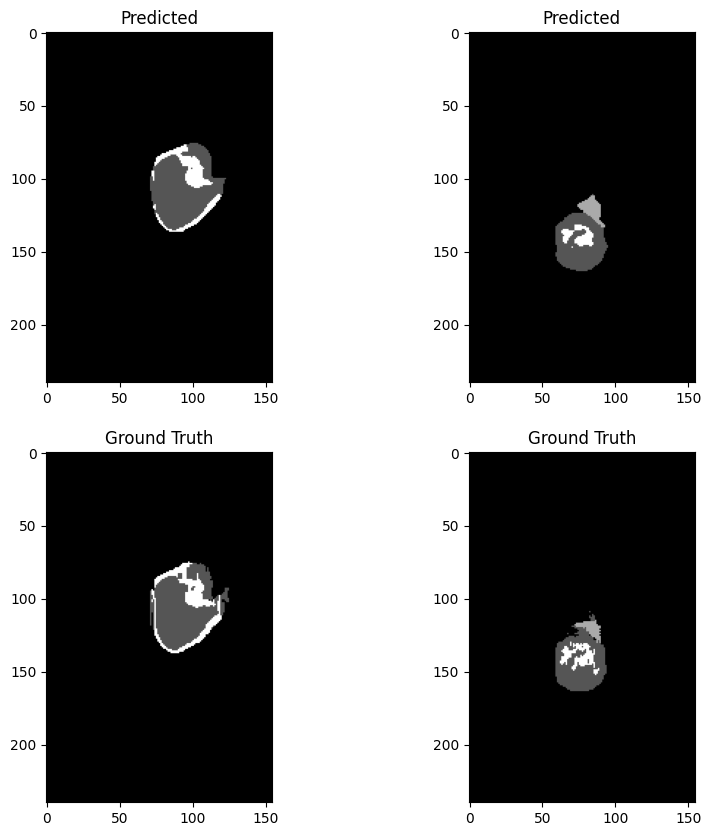

100%|██████████| 156/156 [09:51<00:00,  3.79s/it]



Average Training Loss: 0.009680078132078052

Average Training DSC: [0.9988906  0.90050666 0.92666726 0.72660436]
Average Training ASSD: [ 0.10857901 10.57248982 12.10261223 36.31167416]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


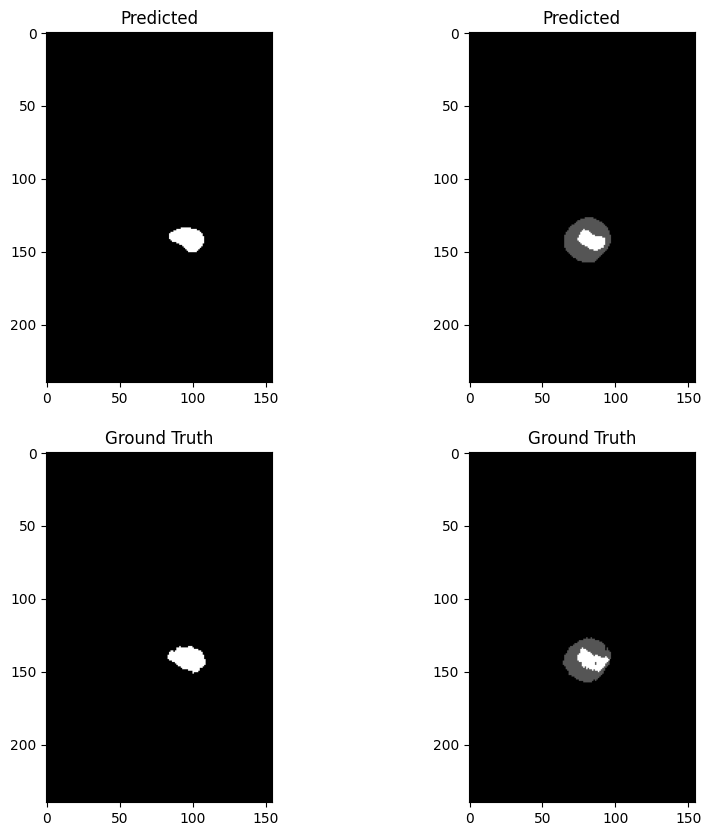

100%|██████████| 39/39 [02:19<00:00,  3.58s/it]


Average Validation Loss: 0.013084613610632144

Average Validation DSC: [0.99867779 0.86114575 0.91427613 0.7074418 ]
Average Validation ASSD: [ 0.13074273 23.14748556 15.67769099 41.94933432]
Epoch 43/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


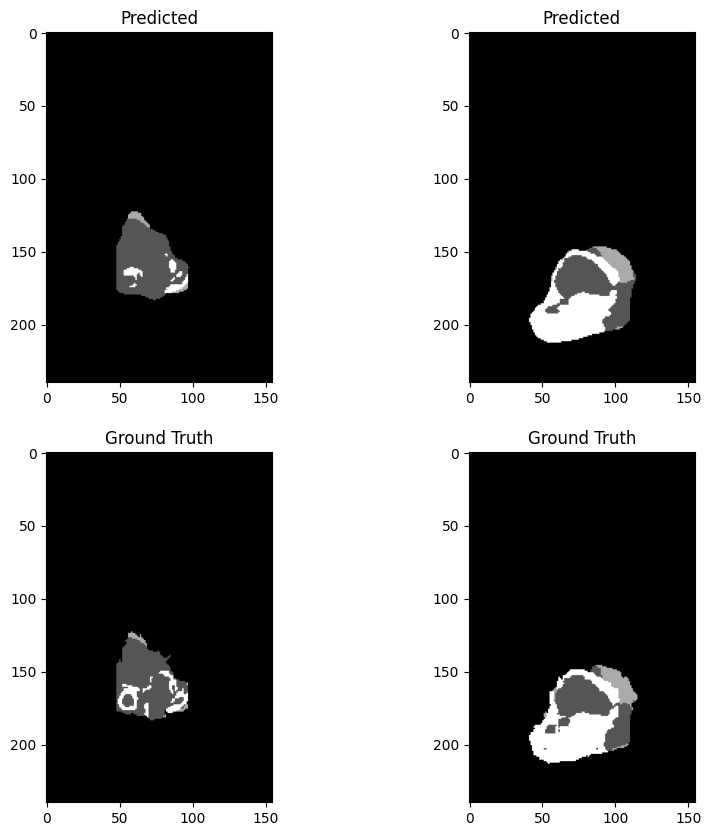

100%|██████████| 156/156 [09:47<00:00,  3.77s/it]



Average Training Loss: 0.008892506271457443

Average Training DSC: [0.99894914 0.91347151 0.93030613 0.74118698]
Average Training ASSD: [ 0.10027682  7.89389783 10.69009584 37.83909395]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


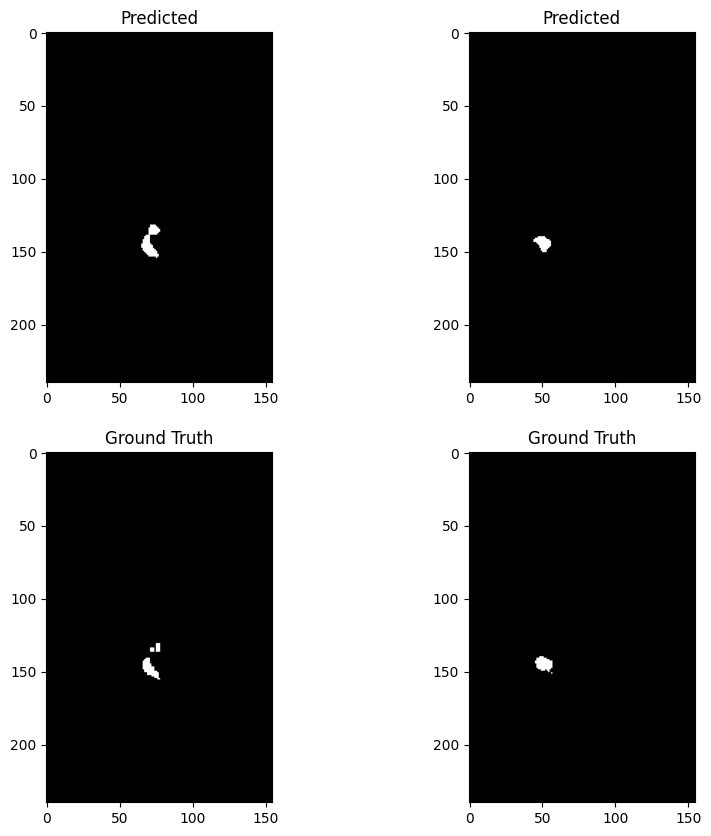

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.013005174469584838

Average Validation DSC: [0.99864738 0.86684069 0.91378758 0.7310594 ]
Average Validation ASSD: [ 0.12565268 21.53044219 13.65379276 27.05302135]
Epoch 44/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


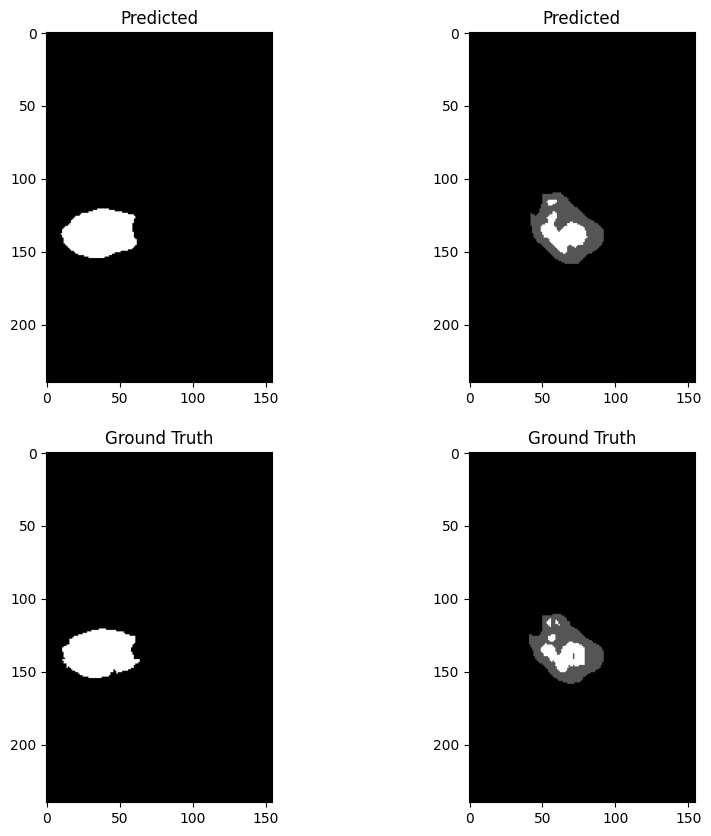

100%|██████████| 156/156 [10:00<00:00,  3.85s/it]



Average Training Loss: 0.008280507638119161

Average Training DSC: [0.99902473 0.92137795 0.9365067  0.75172776]
Average Training ASSD: [ 0.09499472  6.4336934   9.28697504 36.99166017]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


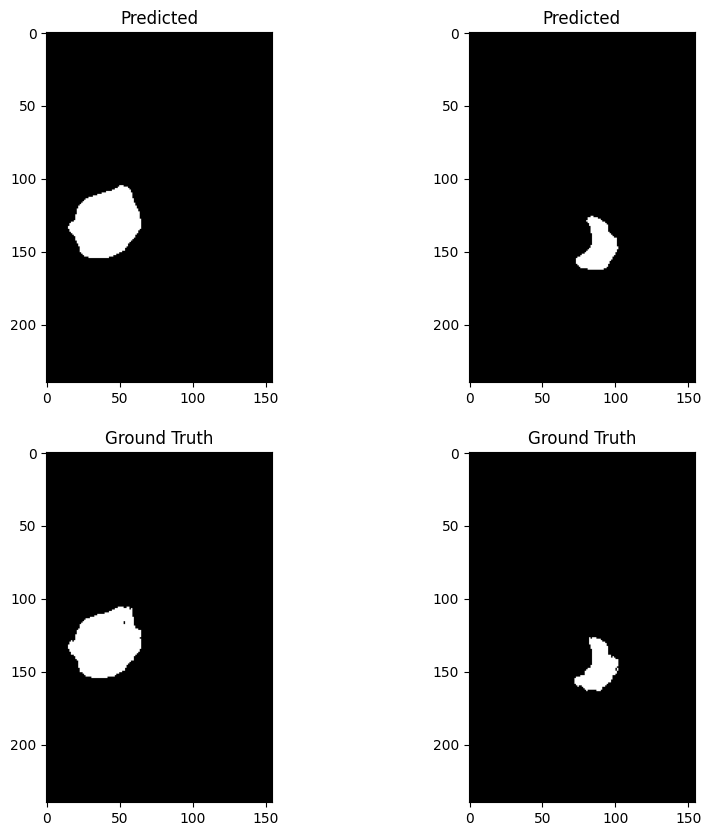

100%|██████████| 39/39 [02:15<00:00,  3.48s/it]


Average Validation Loss: 0.012693708249105092

Average Validation DSC: [0.99877737 0.87946274 0.91781591 0.73993662]
Average Validation ASSD: [ 0.11700121 18.5682826  14.31979588 27.57610459]
Epoch 45/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


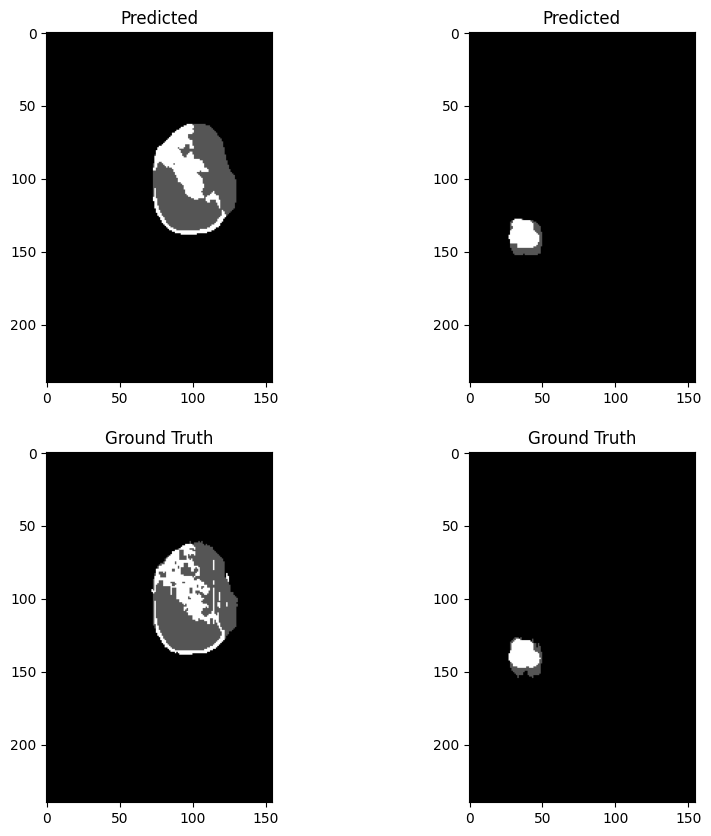

100%|██████████| 156/156 [09:46<00:00,  3.76s/it]



Average Training Loss: 0.00818660841562236

Average Training DSC: [0.99904691 0.92209282 0.93813689 0.75548217]
Average Training ASSD: [ 0.09093788  5.69433633  9.08314262 35.19320457]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


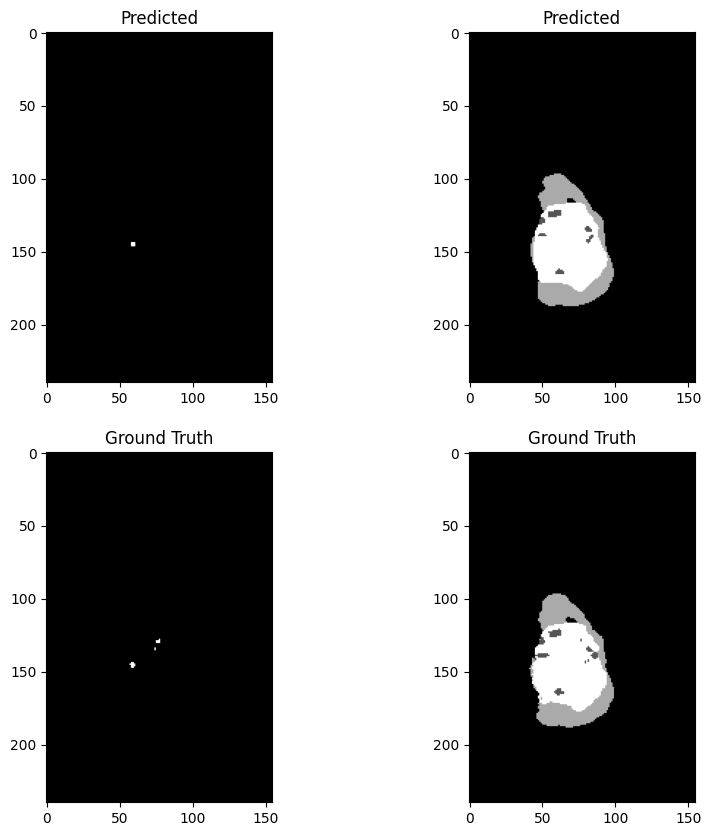

100%|██████████| 39/39 [02:22<00:00,  3.66s/it]


Average Validation Loss: 0.01274002768481389

Average Validation DSC: [0.99880655 0.87705078 0.91829775 0.74467216]
Average Validation ASSD: [ 0.11932423 19.66955961 15.50736983 27.72000112]
Epoch 46/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


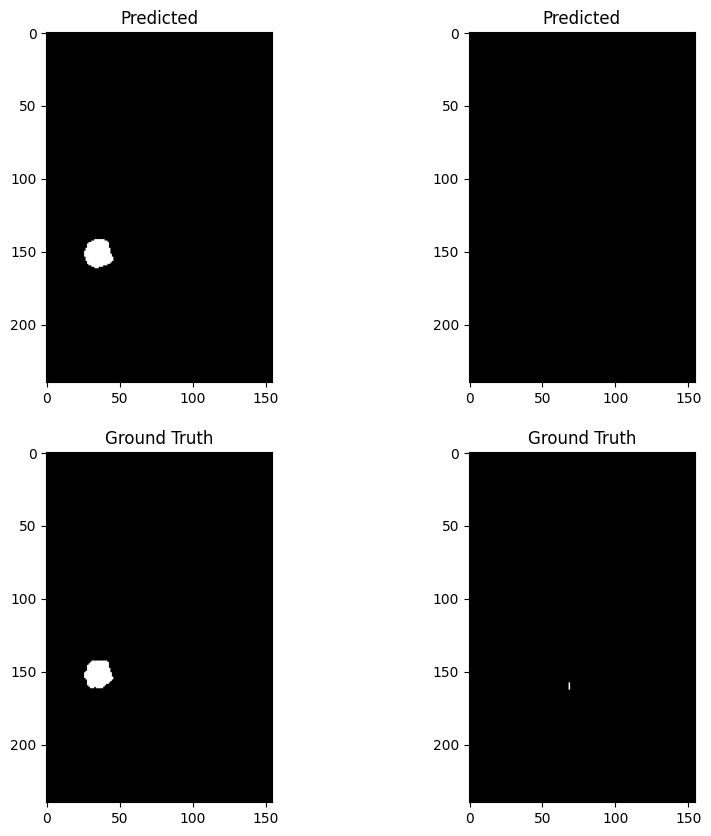

100%|██████████| 156/156 [09:34<00:00,  3.68s/it]



Average Training Loss: 0.008117372853657564

Average Training DSC: [0.99904767 0.92487143 0.93745361 0.75492683]
Average Training ASSD: [ 0.09083515  5.48481583  9.70852453 35.87837502]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


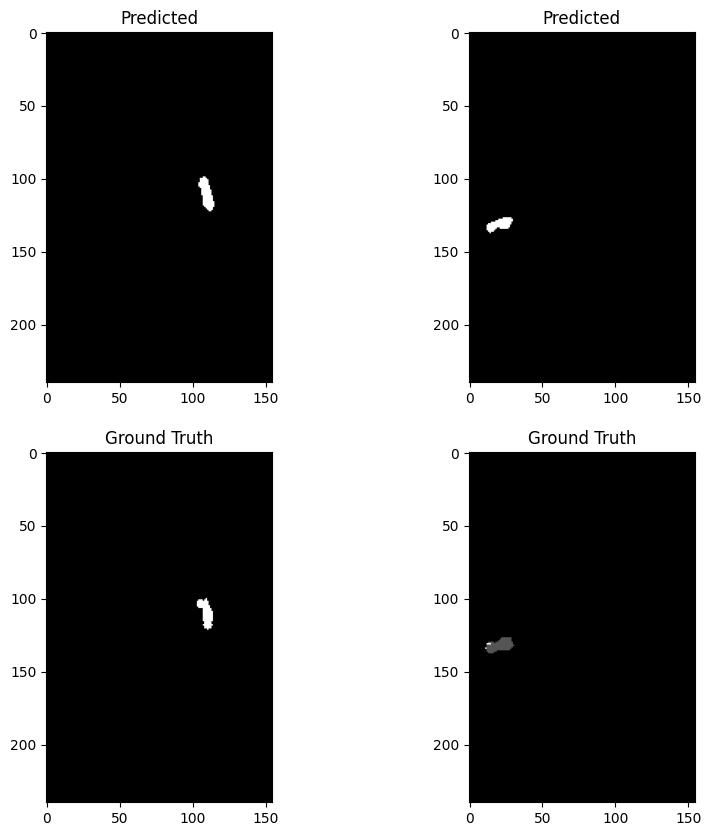

100%|██████████| 39/39 [02:21<00:00,  3.62s/it]


Average Validation Loss: 0.01283456906915093

Average Validation DSC: [0.99883935 0.88206247 0.92290208 0.75245946]
Average Validation ASSD: [ 0.11219512 16.74757492 11.72178081 22.85341342]
Epoch 47/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


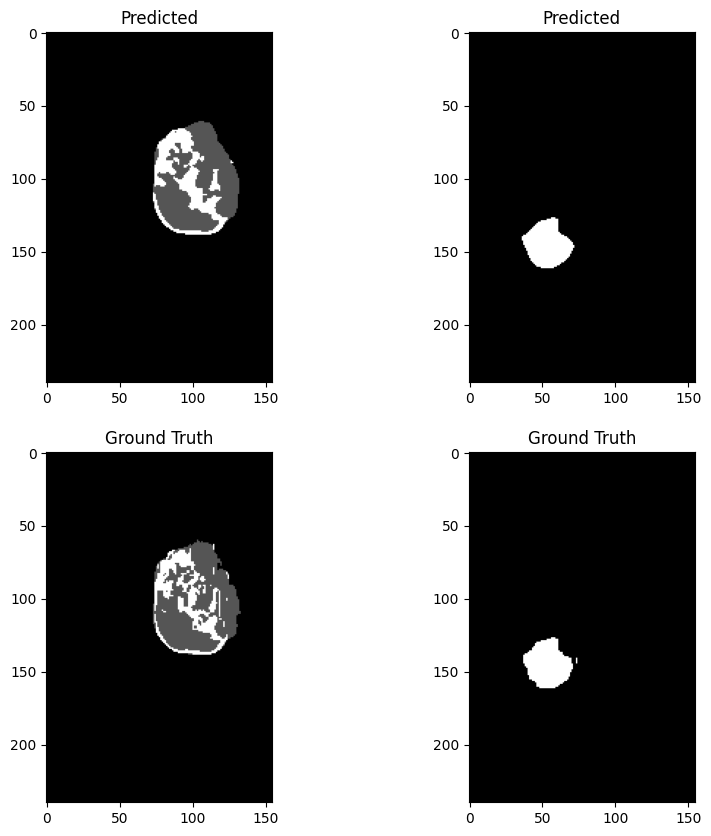

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.008664877258408338

Average Training DSC: [0.99898227 0.91217415 0.93286331 0.75157834]
Average Training ASSD: [ 0.09783881  8.89807957 10.1814638  33.75566598]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


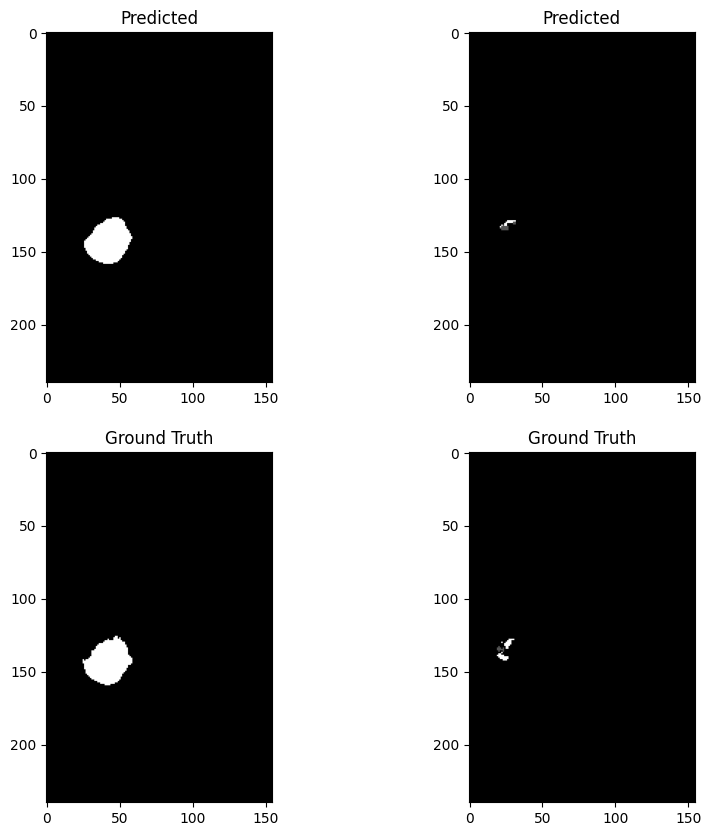

100%|██████████| 39/39 [02:22<00:00,  3.65s/it]


Average Validation Loss: 0.012973156268111406

Average Validation DSC: [0.9986238  0.87317933 0.90688502 0.71798299]
Average Validation ASSD: [ 0.14271772 20.01217149 18.33906322 36.49531134]
Epoch 48/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


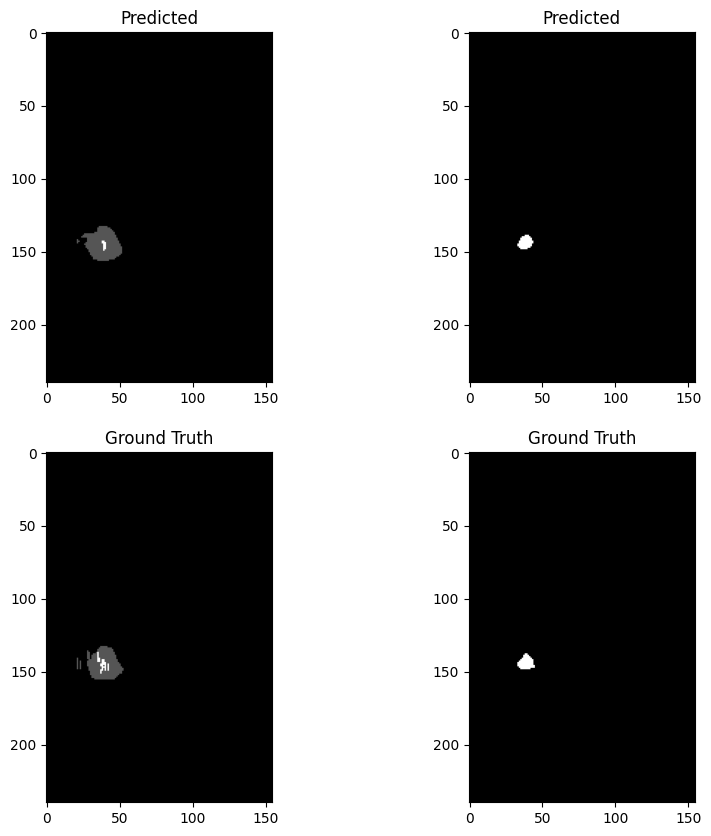

100%|██████████| 156/156 [09:56<00:00,  3.82s/it]



Average Training Loss: 0.008484541032558832

Average Training DSC: [0.99899976 0.9170921  0.93320721 0.75604619]
Average Training ASSD: [ 0.09527797  7.36609224 10.233236   34.67228663]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


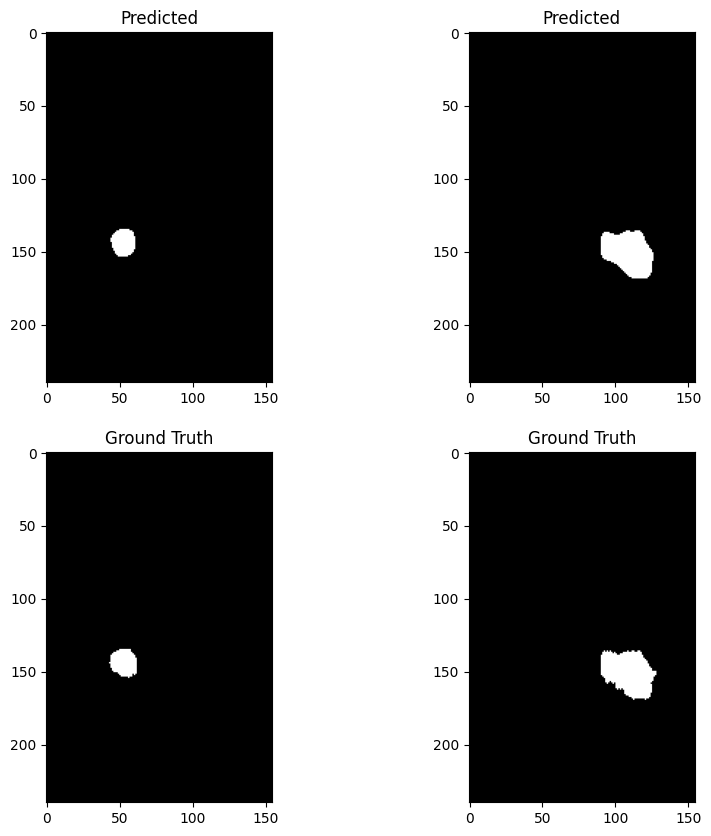

100%|██████████| 39/39 [02:20<00:00,  3.59s/it]


Average Validation Loss: 0.012426898384896608

Average Validation DSC: [0.99880385 0.87959389 0.92142471 0.73629261]
Average Validation ASSD: [ 0.11904256 18.52451852 13.03106462 30.43557632]
Epoch 49/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


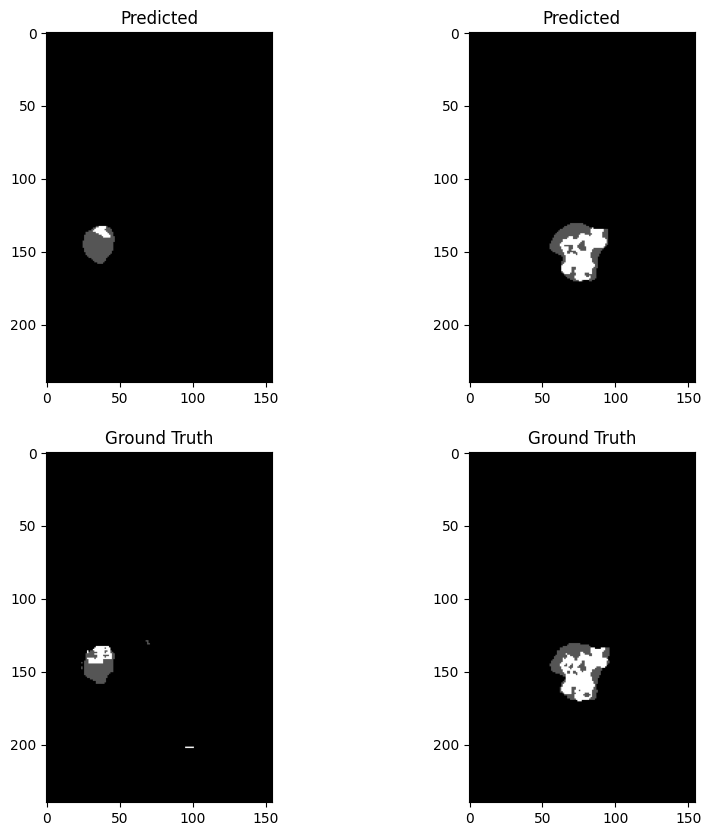

100%|██████████| 156/156 [09:42<00:00,  3.73s/it]



Average Training Loss: 0.00791838992601977

Average Training DSC: [0.99906638 0.92479848 0.93669667 0.7642561 ]
Average Training ASSD: [ 0.08853843  5.82002046  9.36282092 33.74579509]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


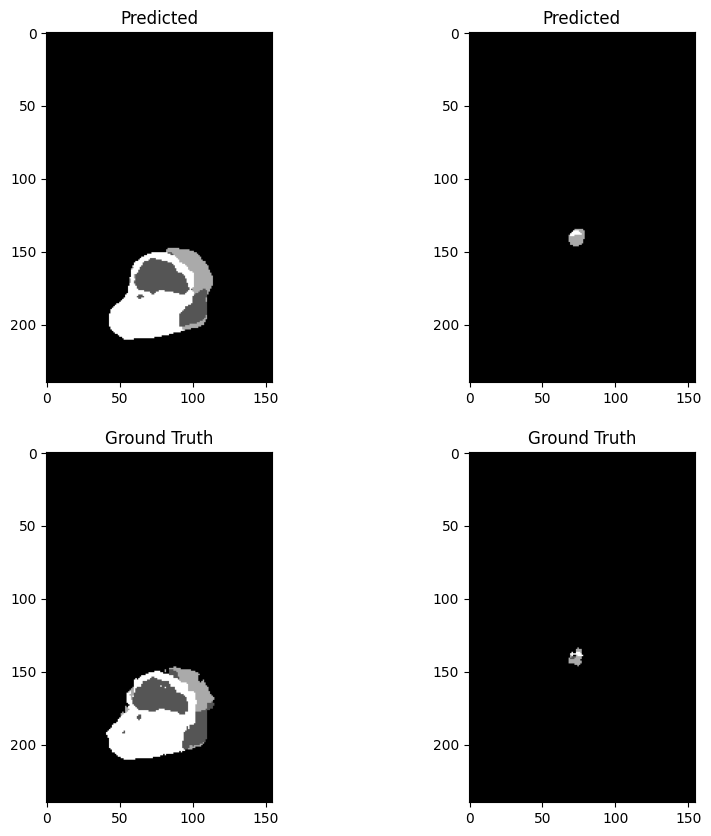

100%|██████████| 39/39 [02:21<00:00,  3.63s/it]


Average Validation Loss: 0.012613004109320732

Average Validation DSC: [0.99884423 0.88442718 0.91909642 0.75555936]
Average Validation ASSD: [ 0.10810403 17.30364457 12.47801883 23.6075321 ]
Epoch 50/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


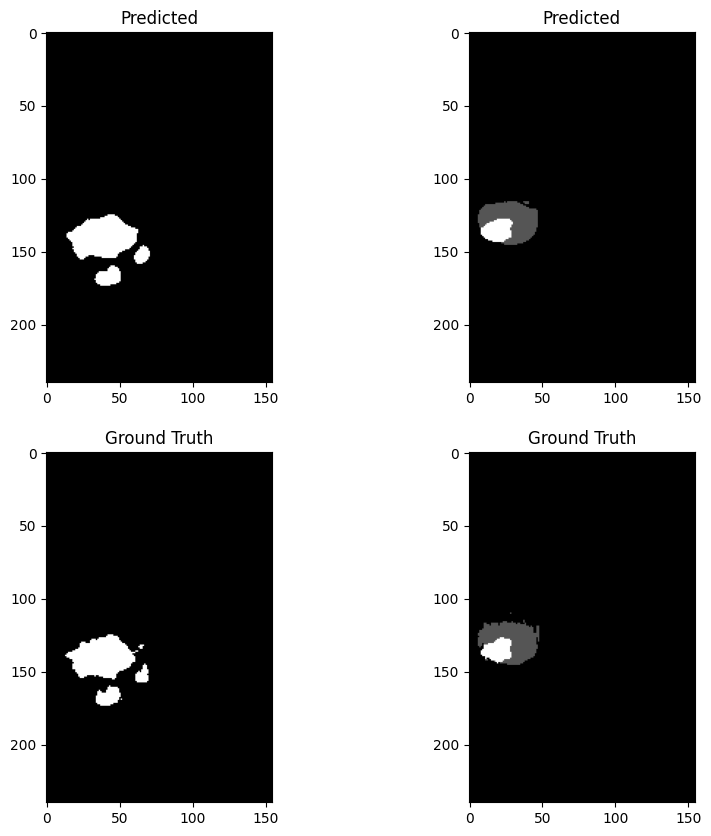

100%|██████████| 156/156 [09:57<00:00,  3.83s/it]



Average Training Loss: 0.0073824997555512265

Average Training DSC: [0.99913913 0.93313819 0.9400371  0.77576212]
Average Training ASSD: [ 0.08191146  3.91064999  8.63740078 34.31230622]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


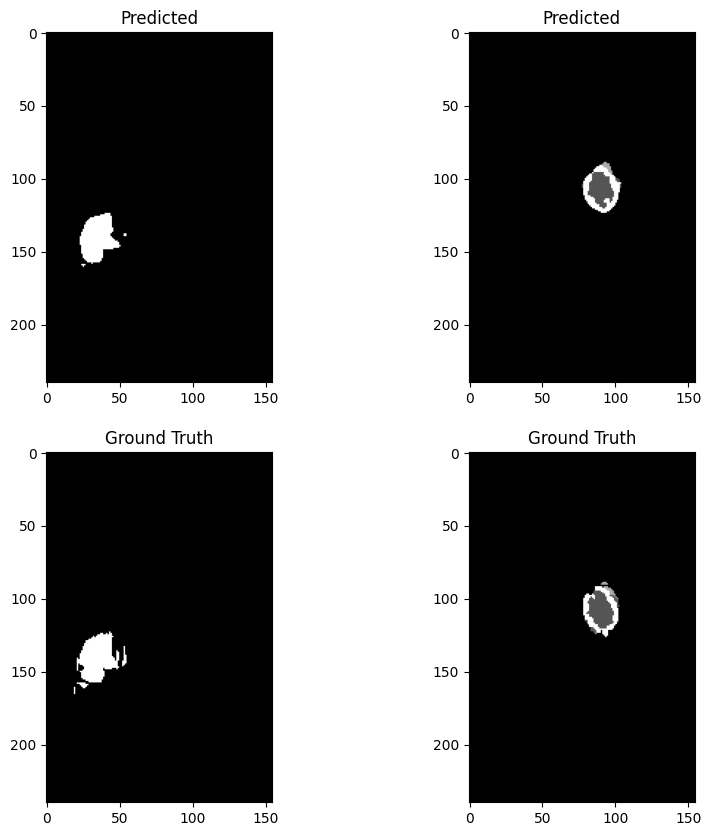

100%|██████████| 39/39 [02:15<00:00,  3.48s/it]


Average Validation Loss: 0.012295147583175164

Average Validation DSC: [0.9988389  0.89163513 0.92464073 0.73714404]
Average Validation ASSD: [ 0.12538648 16.99100983 12.40401598 36.6867461 ]
Epoch 51/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


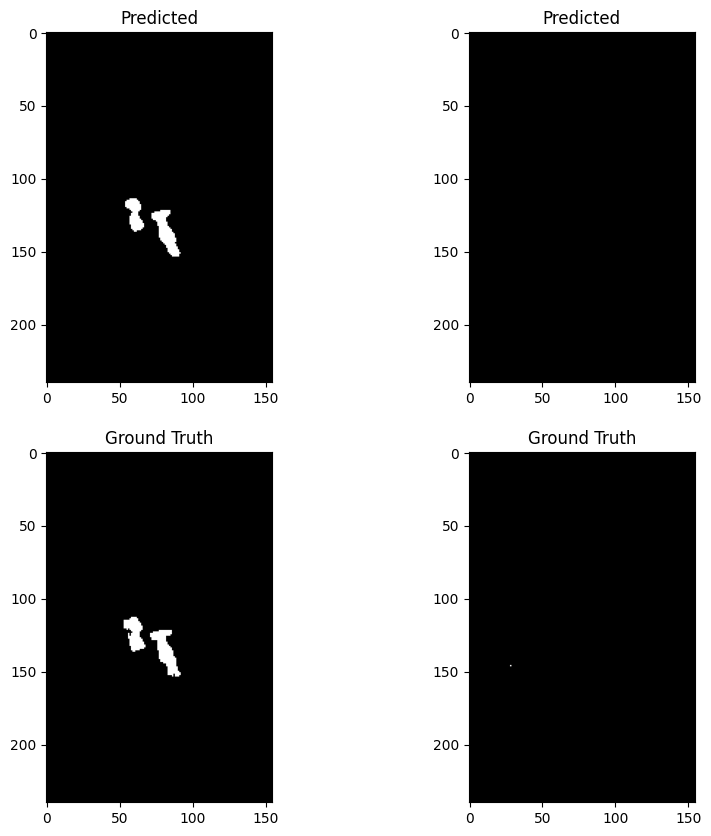

100%|██████████| 156/156 [09:48<00:00,  3.77s/it]



Average Training Loss: 0.007340164977507904

Average Training DSC: [0.99913287 0.93393243 0.94127476 0.77640109]
Average Training ASSD: [ 0.08246676  3.7634456   8.76384287 32.91178059]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


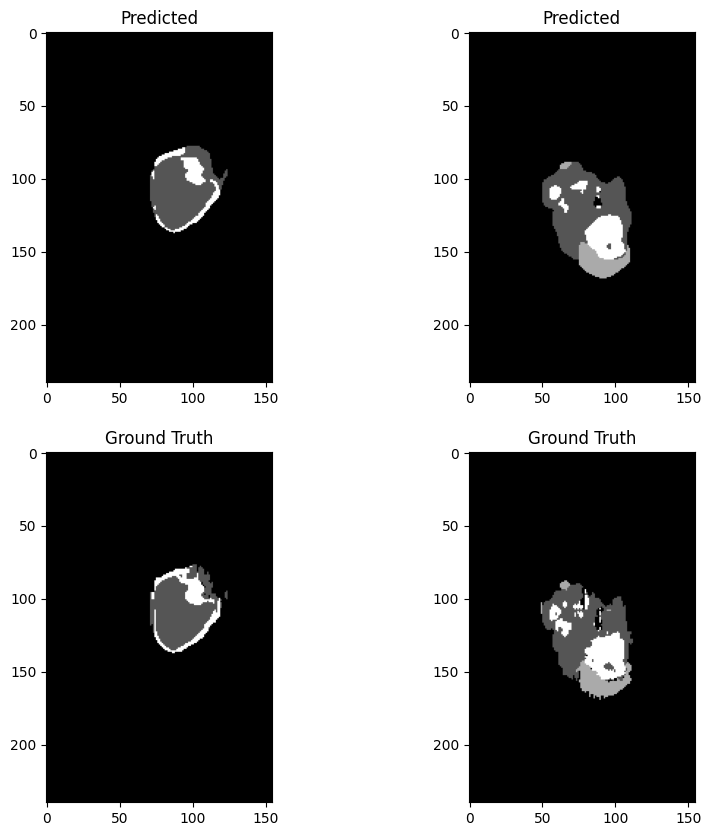

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.012147620941201845

Average Validation DSC: [0.99890685 0.88905307 0.92558847 0.74930418]
Average Validation ASSD: [ 0.10988941 17.28665864 11.58058591 30.64965204]
Epoch 52/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


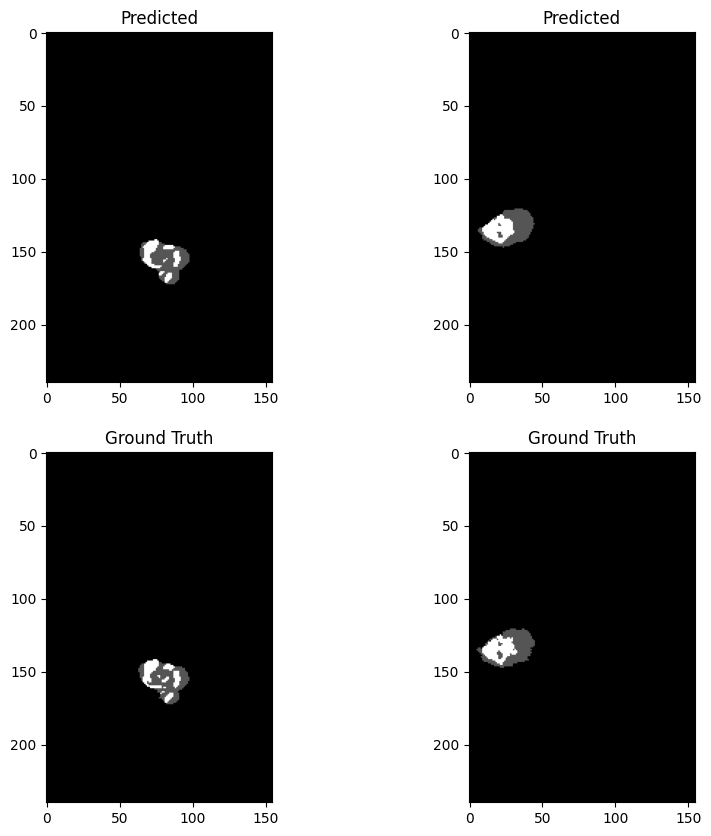

100%|██████████| 156/156 [09:45<00:00,  3.75s/it]



Average Training Loss: 0.007068201535357497

Average Training DSC: [0.99917986 0.93584613 0.94261792 0.78249226]
Average Training ASSD: [ 0.07867309  3.96419928  8.03724713 32.2168168 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


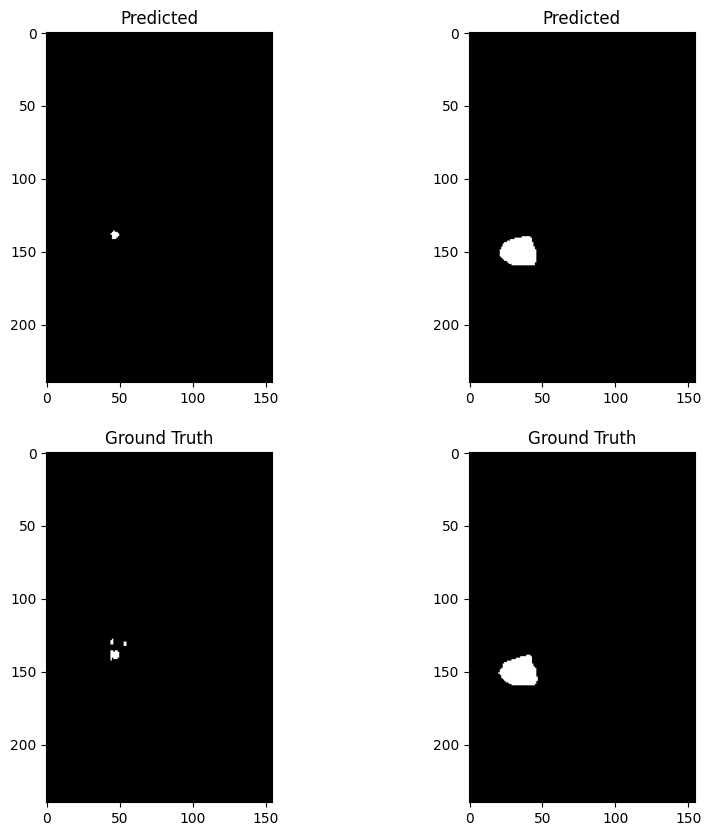

100%|██████████| 39/39 [02:14<00:00,  3.45s/it]


Average Validation Loss: 0.012161943667496625

Average Validation DSC: [0.9989302  0.89117603 0.92545831 0.75969552]
Average Validation ASSD: [ 0.10673717 16.40630701 13.56901501 30.22875028]
Epoch 53/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


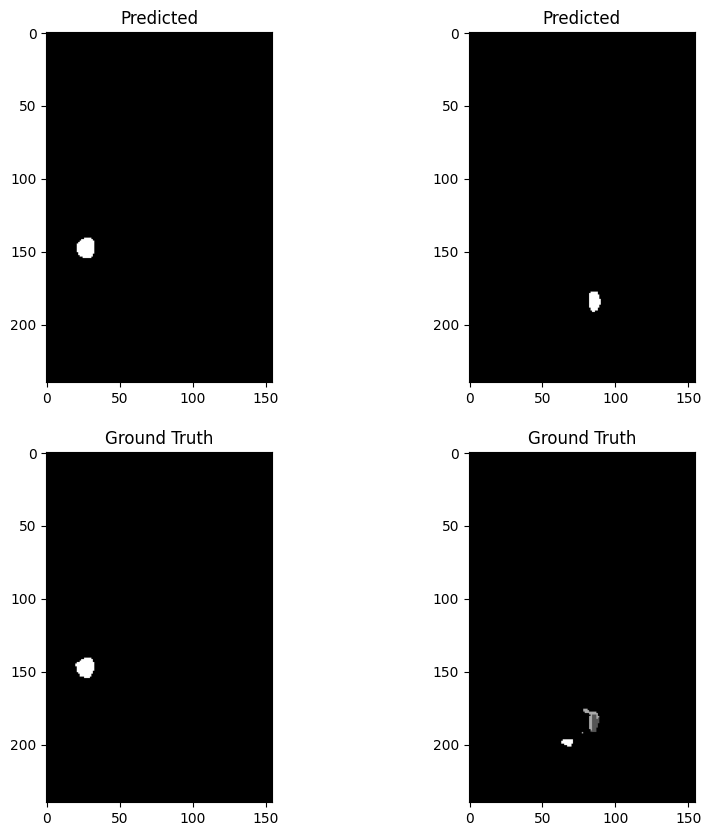

100%|██████████| 156/156 [09:51<00:00,  3.79s/it]



Average Training Loss: 0.007051314063107547

Average Training DSC: [0.9991743  0.93472335 0.94226589 0.78278886]
Average Training ASSD: [ 0.07711716  4.40233321  8.75132395 31.72941283]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


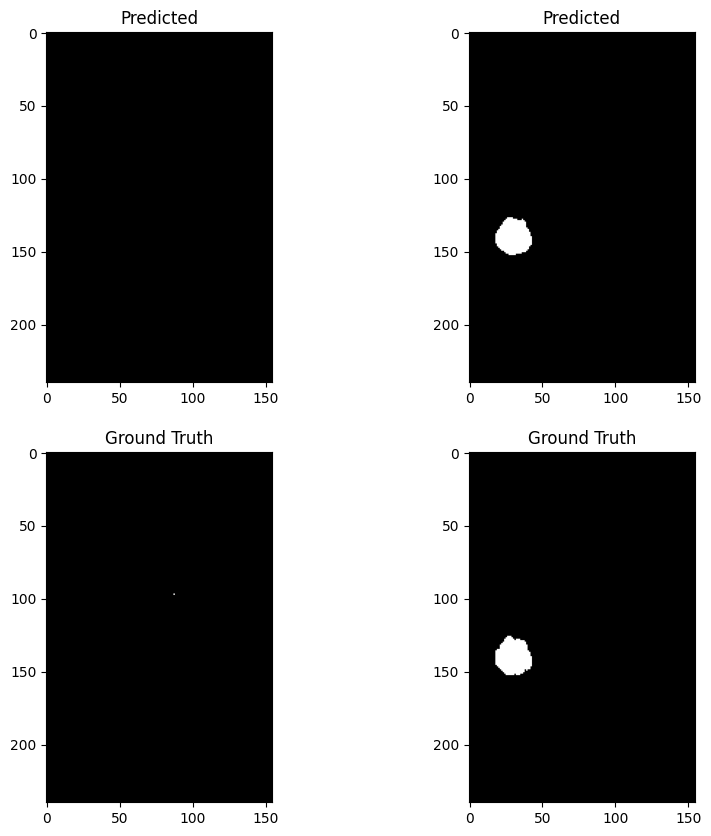

100%|██████████| 39/39 [02:26<00:00,  3.76s/it]


Average Validation Loss: 0.01225636045758923

Average Validation DSC: [0.99888067 0.89055156 0.92077648 0.75599173]
Average Validation ASSD: [ 0.10811774 17.24700275 12.57098377 26.75372326]
Epoch 54/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


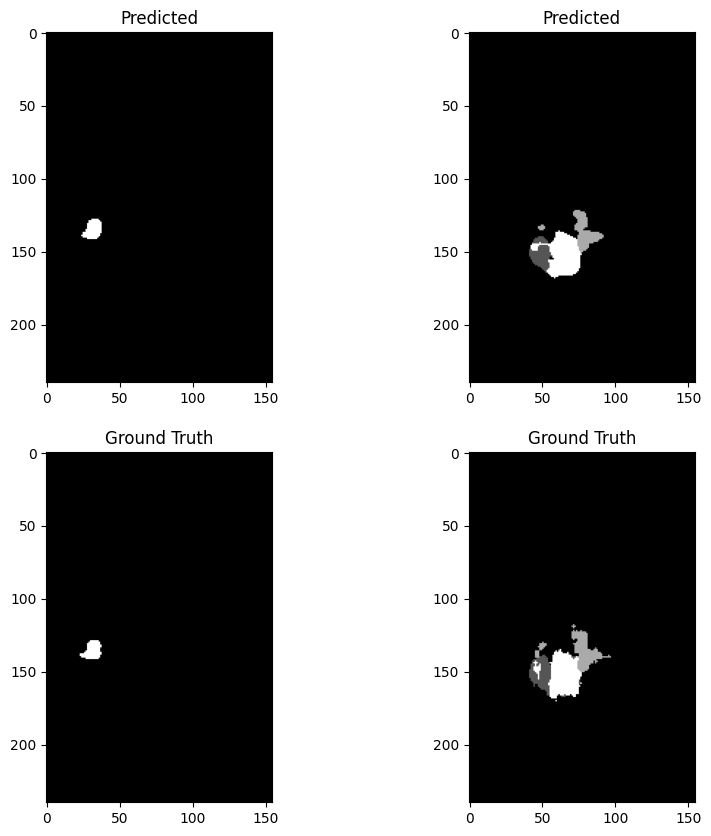

100%|██████████| 156/156 [09:51<00:00,  3.79s/it]



Average Training Loss: 0.007390141179665732

Average Training DSC: [0.99913502 0.92927397 0.94114012 0.7782655 ]
Average Training ASSD: [ 0.08310795  5.80725966  8.76521205 31.47391194]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


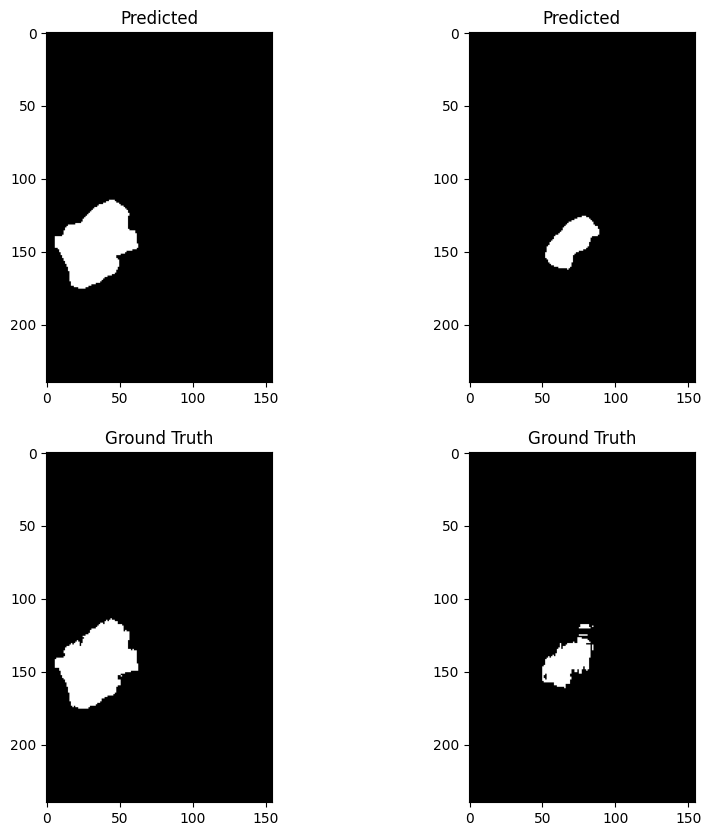

100%|██████████| 39/39 [02:21<00:00,  3.62s/it]


Average Validation Loss: 0.012521050392817229

Average Validation DSC: [0.99883006 0.87865696 0.91502698 0.73220992]
Average Validation ASSD: [ 0.11750675 18.75769098 14.84620512 34.26494496]
Epoch 55/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


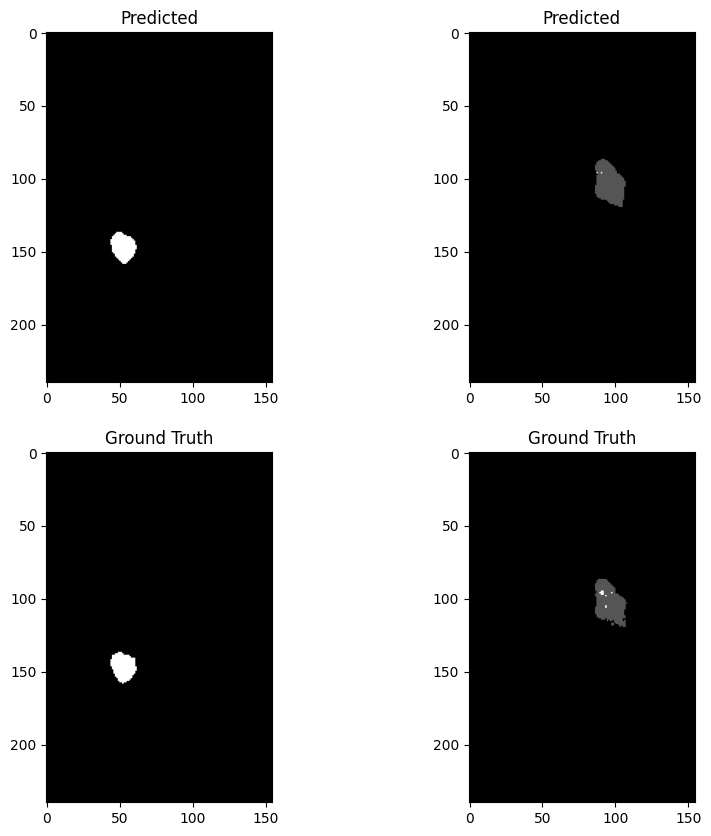

100%|██████████| 156/156 [09:49<00:00,  3.78s/it]



Average Training Loss: 0.008882629016462045

Average Training DSC: [0.99900731 0.89876146 0.93117289 0.75091364]
Average Training ASSD: [ 0.09606664 12.67496667 11.43161891 30.98312127]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


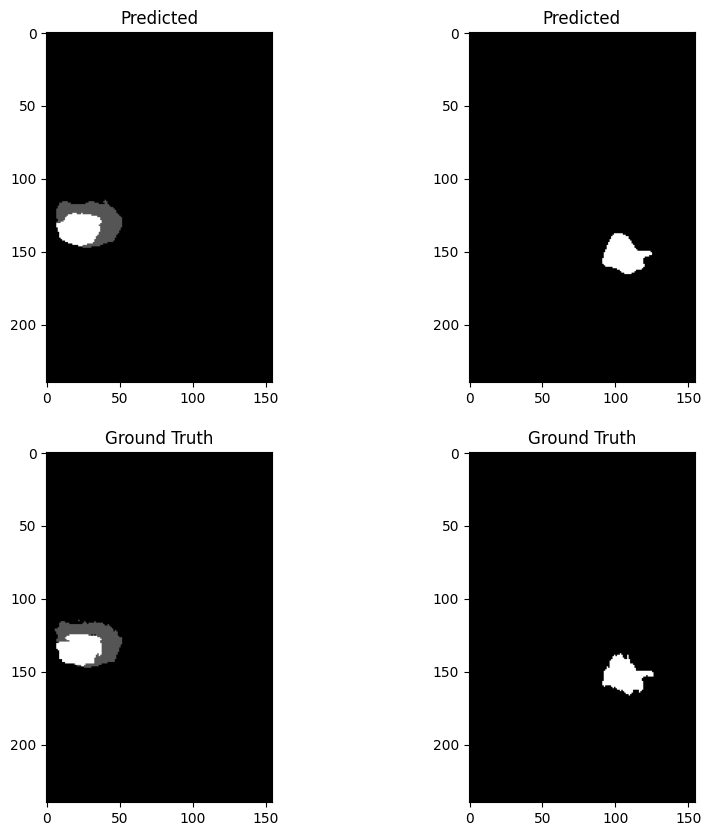

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.013148001490686184

Average Validation DSC: [0.99874607 0.85885361 0.918512   0.7306552 ]
Average Validation ASSD: [ 0.12061837 24.57857793 13.6910102  26.4355963 ]
Epoch 56/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


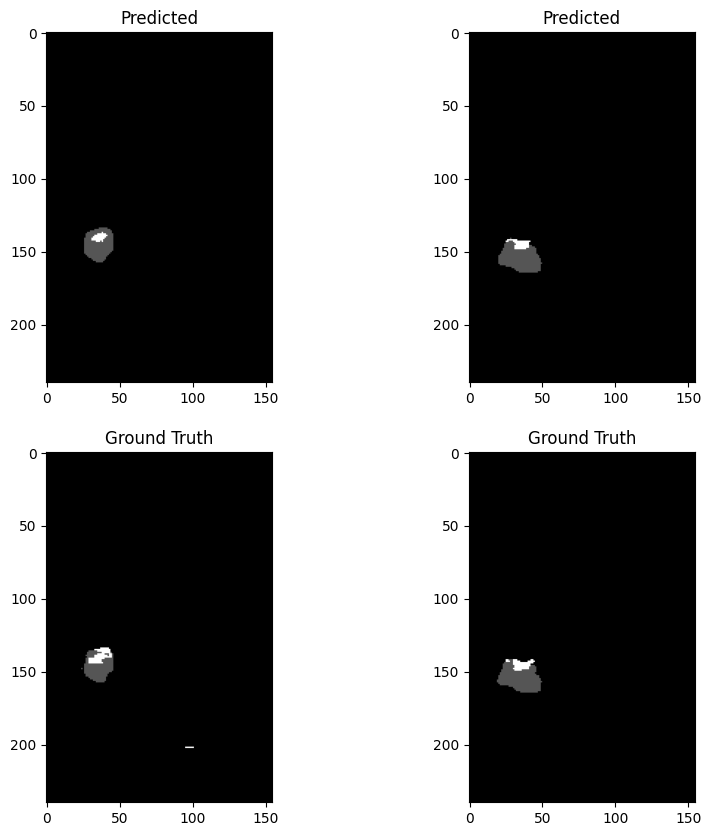

100%|██████████| 156/156 [09:31<00:00,  3.66s/it]



Average Training Loss: 0.008614297401016721

Average Training DSC: [0.99901729 0.90261657 0.93170254 0.75502228]
Average Training ASSD: [ 0.09517037 12.25587899 10.5599911  30.84586952]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


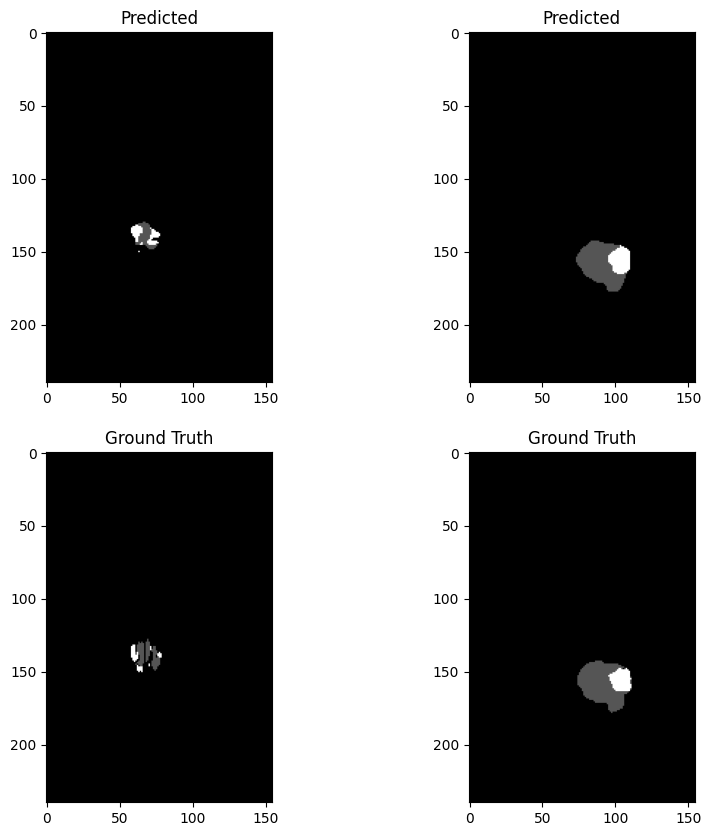

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.013521588622377468

Average Validation DSC: [0.99862558 0.84936136 0.91172956 0.73290795]
Average Validation ASSD: [ 0.13568956 24.11724554 14.85392624 21.11047765]
Epoch 57/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


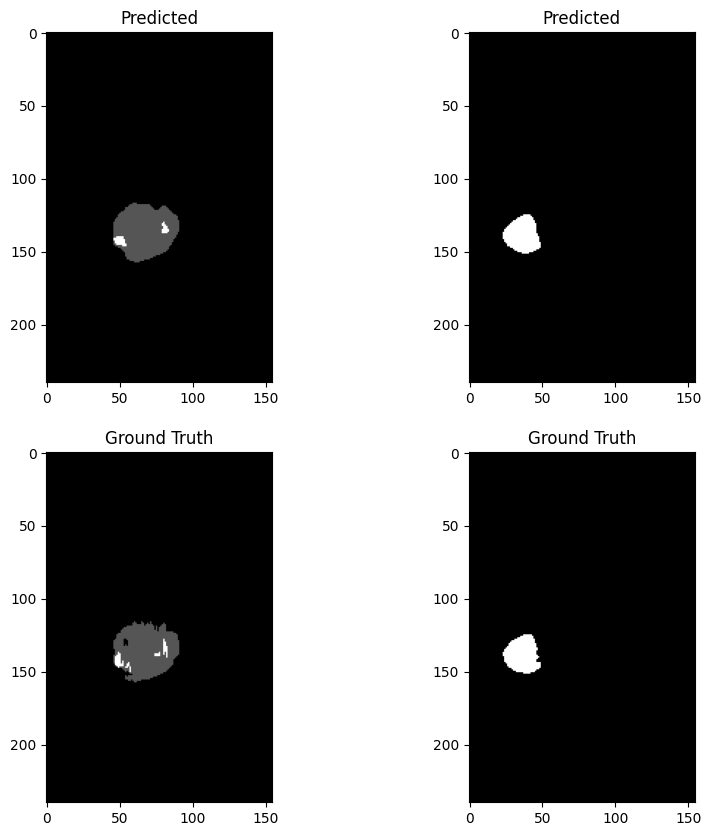

100%|██████████| 156/156 [09:29<00:00,  3.65s/it]



Average Training Loss: 0.008548133221502678

Average Training DSC: [0.99902622 0.90633461 0.92823744 0.75936974]
Average Training ASSD: [ 0.09527692 10.99774264 11.79161634 32.00290839]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


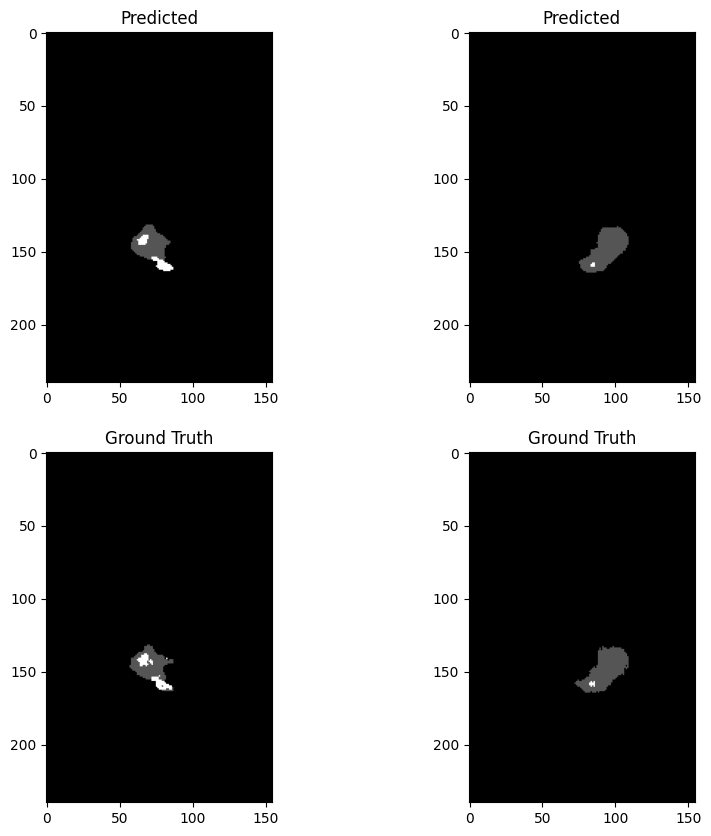

100%|██████████| 39/39 [02:15<00:00,  3.48s/it]


Average Validation Loss: 0.014114076797014628

Average Validation DSC: [0.9987032  0.85928392 0.90270325 0.7347485 ]
Average Validation ASSD: [ 0.11731699 23.19934226 20.87516038 25.70172985]
Epoch 58/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


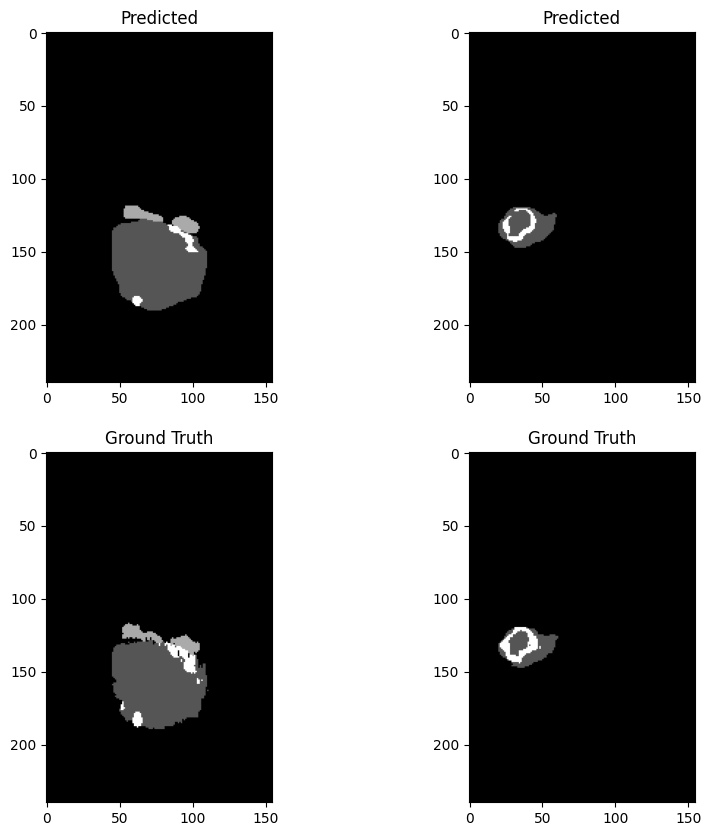

100%|██████████| 156/156 [09:37<00:00,  3.70s/it]



Average Training Loss: 0.008437867691286672

Average Training DSC: [0.99903088 0.91190477 0.92971037 0.76021005]
Average Training ASSD: [ 0.09283391  9.93203879 12.08858711 29.95353142]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


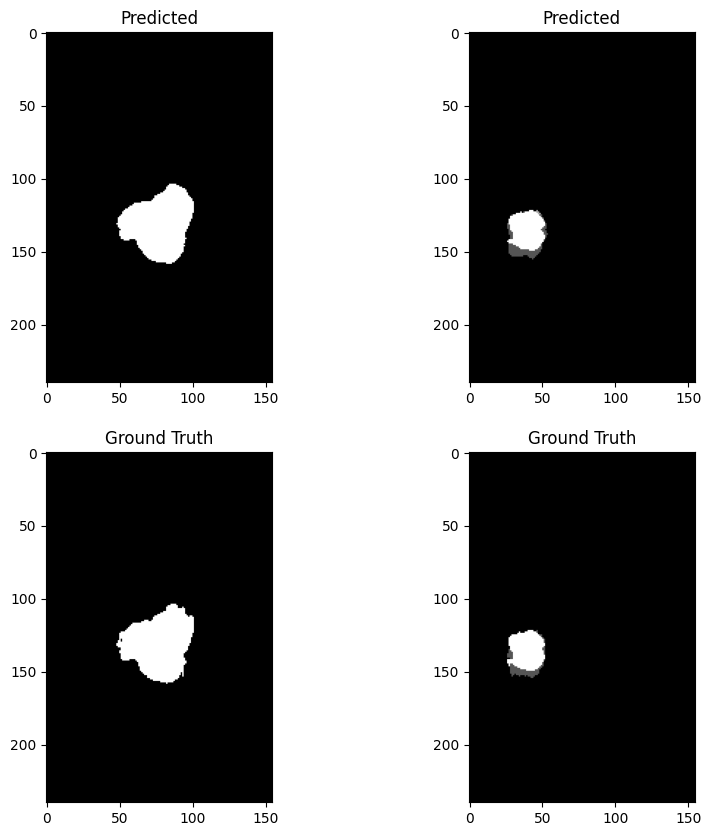

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.012549688836607413

Average Validation DSC: [0.99885776 0.87186366 0.9173423  0.73502272]
Average Validation ASSD: [ 0.10881738 23.71804575 15.07574094 30.84470458]
Epoch 59/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


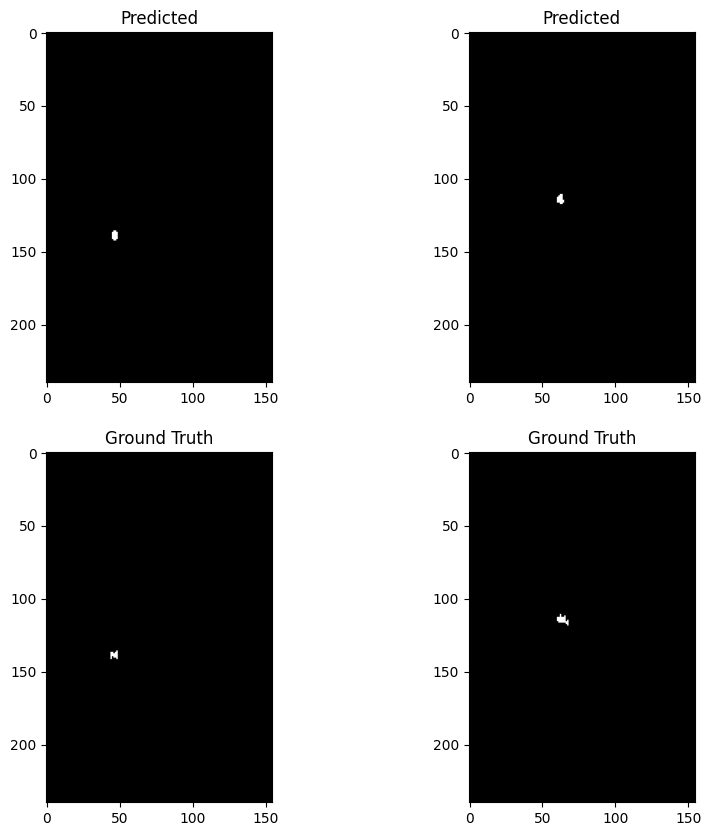

100%|██████████| 156/156 [09:15<00:00,  3.56s/it]



Average Training Loss: 0.0071334217239219025

Average Training DSC: [0.99918779 0.9294578  0.94117749 0.78021663]
Average Training ASSD: [ 0.07725566  6.00916241  9.25555073 31.10615231]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


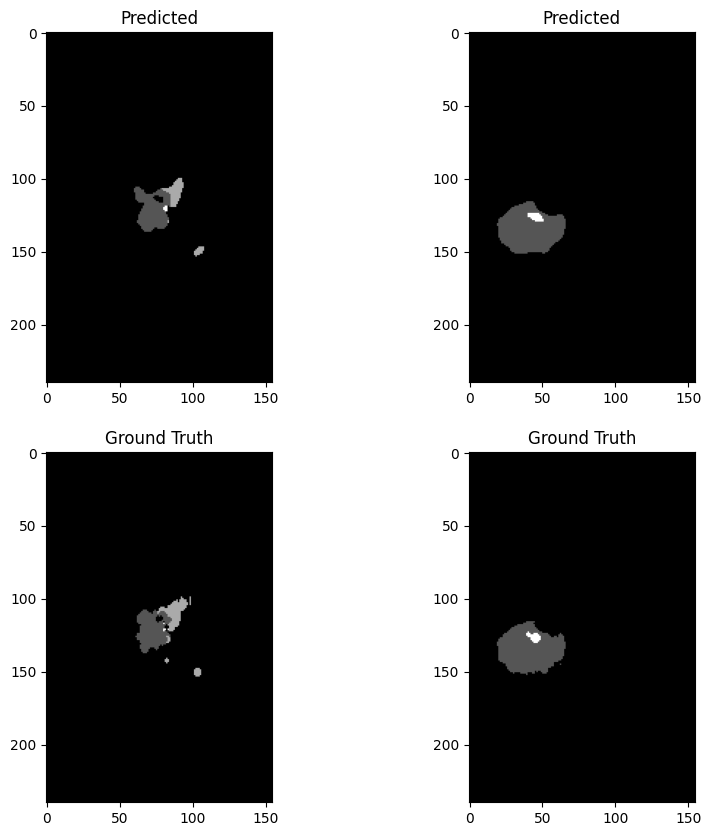

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.011941952941318354

Average Validation DSC: [0.99895845 0.89875208 0.93082965 0.75735005]
Average Validation ASSD: [ 0.10182888 15.80255562 12.0893054  31.0603376 ]
Epoch 60/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


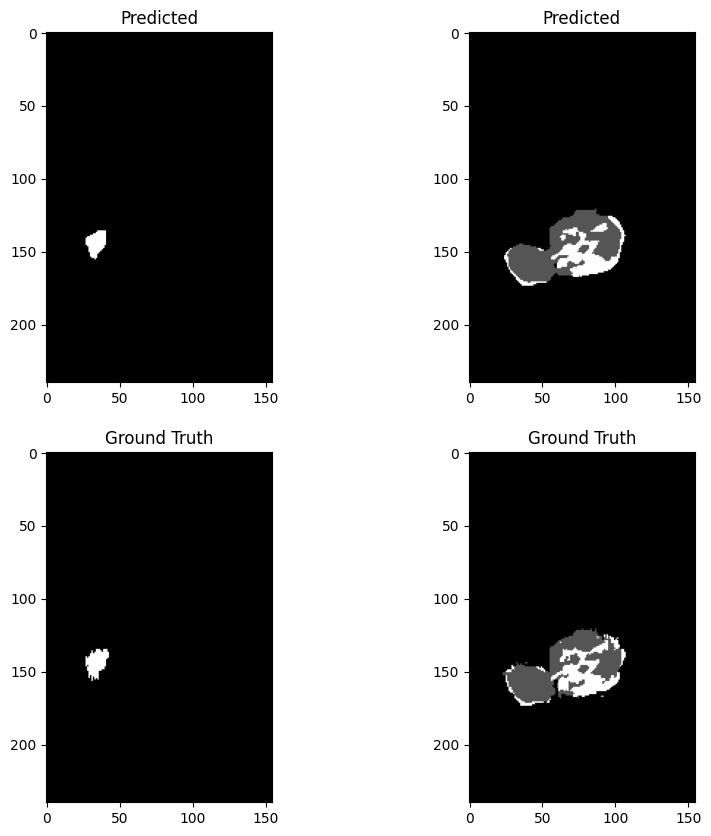

100%|██████████| 156/156 [09:19<00:00,  3.58s/it]



Average Training Loss: 0.006694138182912213

Average Training DSC: [0.999253   0.93496672 0.94687245 0.79119215]
Average Training ASSD: [ 0.0700887   5.17496282  7.65449889 30.48464762]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


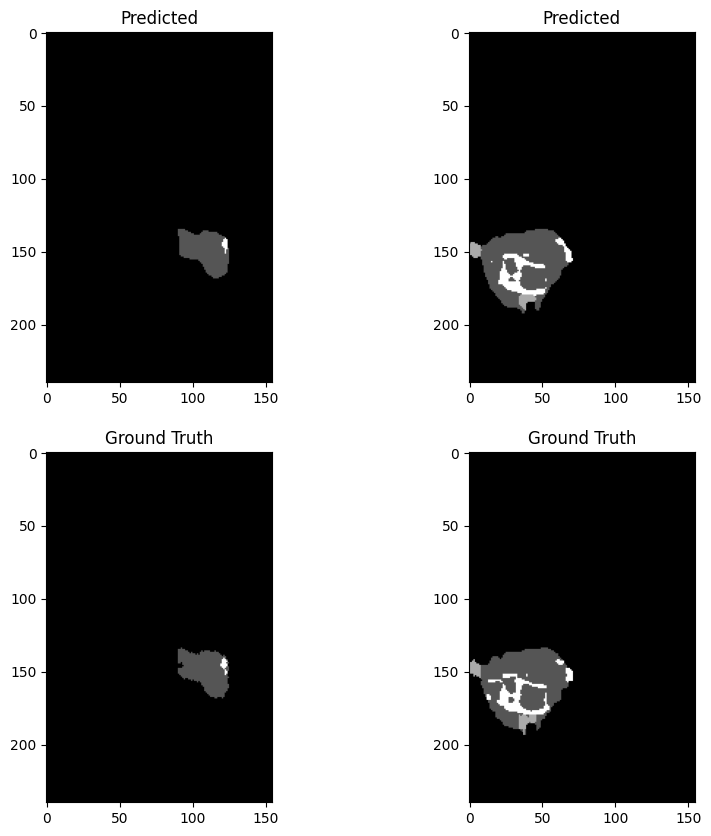

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.011903327018118057

Average Validation DSC: [0.99896374 0.8932062  0.92631769 0.74718344]
Average Validation ASSD: [ 0.10140123 16.99099426 13.06864005 33.5864454 ]
Epoch 61/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


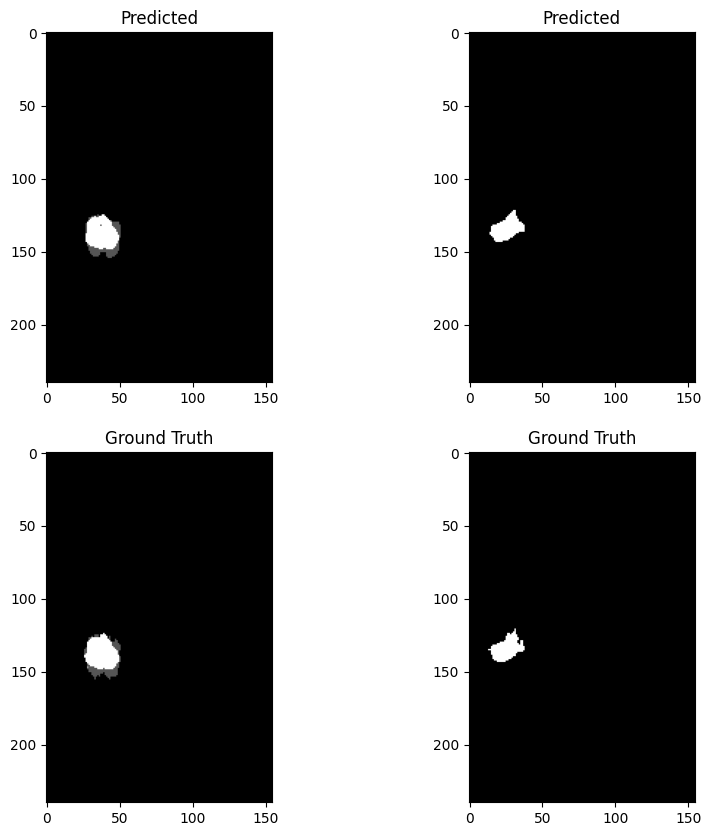

100%|██████████| 156/156 [09:50<00:00,  3.78s/it]



Average Training Loss: 0.006400435386846463

Average Training DSC: [0.99927696 0.93998826 0.94711935 0.7981125 ]
Average Training ASSD: [ 0.06737425  4.14675501  8.01679129 28.96510389]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


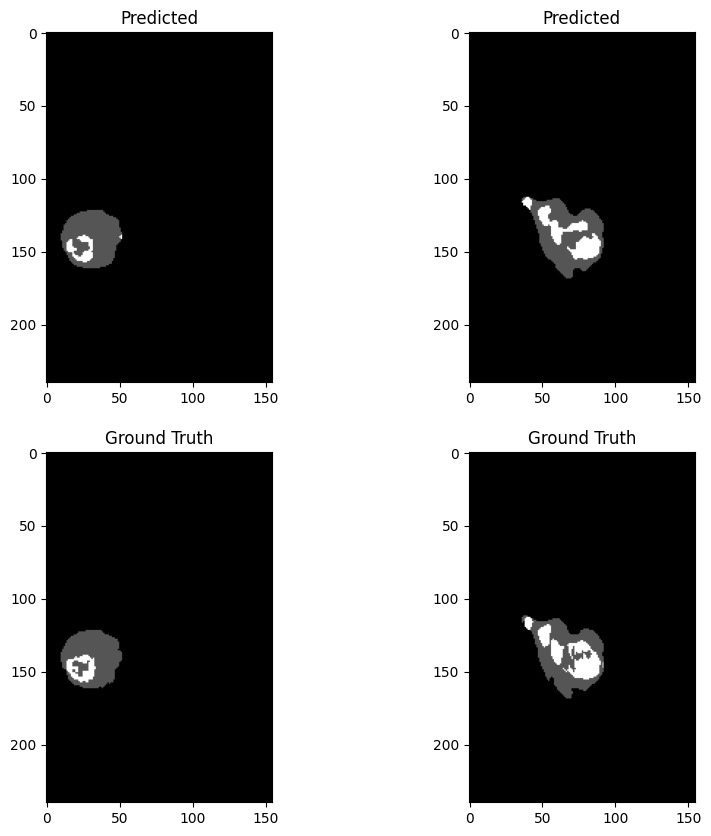

100%|██████████| 39/39 [02:20<00:00,  3.59s/it]


Average Validation Loss: 0.011887027953679744

Average Validation DSC: [0.99901268 0.89920179 0.92779548 0.75555681]
Average Validation ASSD: [ 0.09745759 15.04853414 12.42853879 31.52206766]
Epoch 62/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


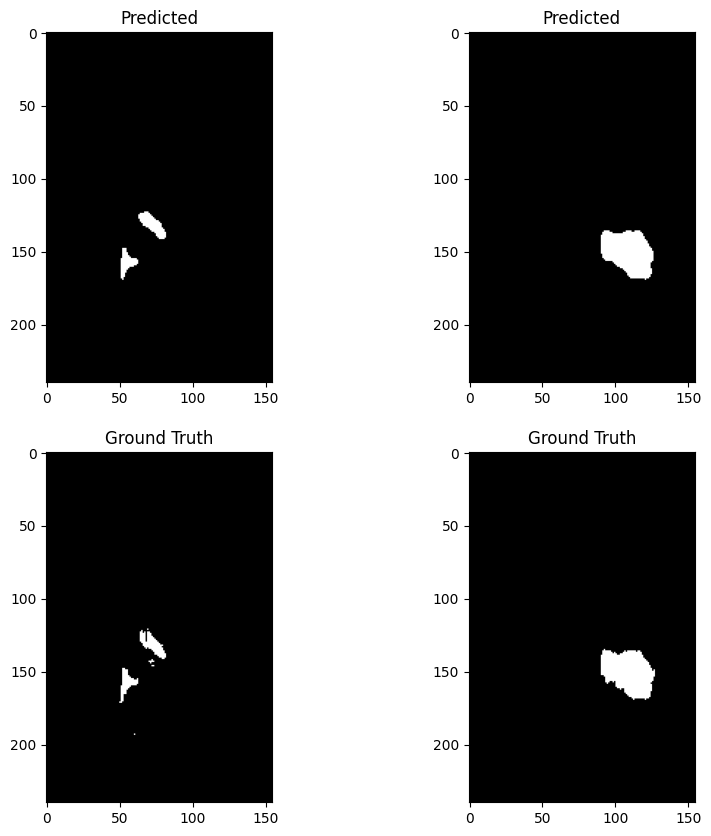

100%|██████████| 156/156 [09:42<00:00,  3.73s/it]



Average Training Loss: 0.006488005284411021

Average Training DSC: [0.99927116 0.93740835 0.94895394 0.79633648]
Average Training ASSD: [ 0.06852982  4.37375839  7.28468831 29.45531714]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


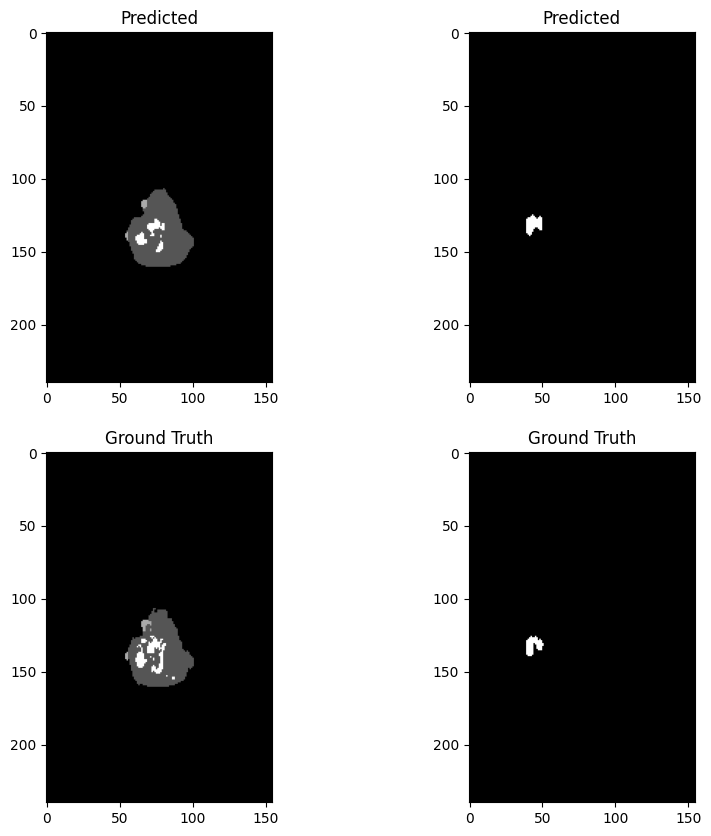

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.012786448563043123

Average Validation DSC: [0.99891944 0.89042129 0.92853826 0.74317324]
Average Validation ASSD: [ 0.10059266 16.16360358 11.05387307 32.6098265 ]
Epoch 63/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


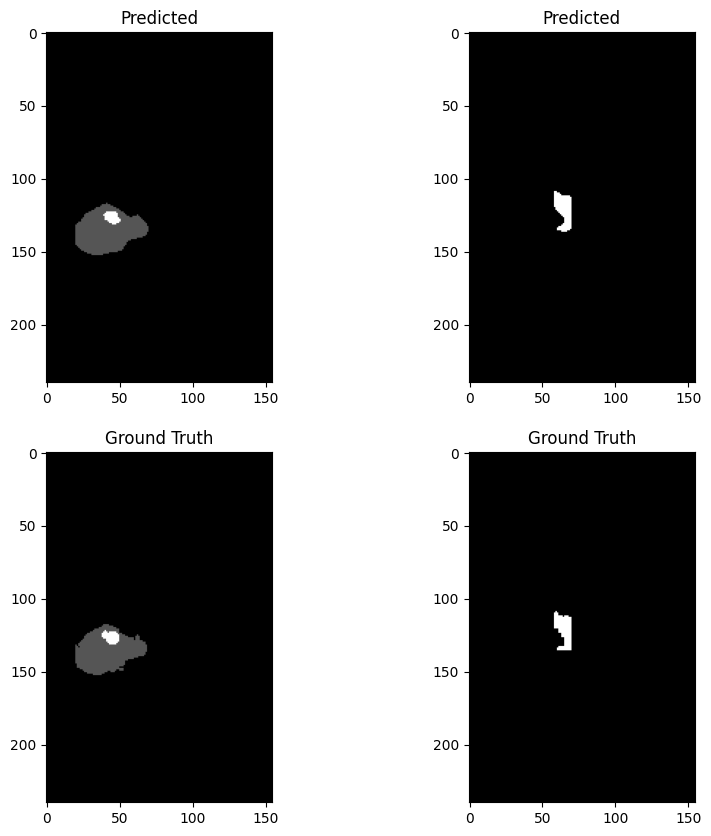

100%|██████████| 156/156 [09:51<00:00,  3.79s/it]



Average Training Loss: 0.006258209209101131

Average Training DSC: [0.99928933 0.94141107 0.94891914 0.80160463]
Average Training ASSD: [ 0.06581815  3.56495044  7.36119288 29.21390817]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


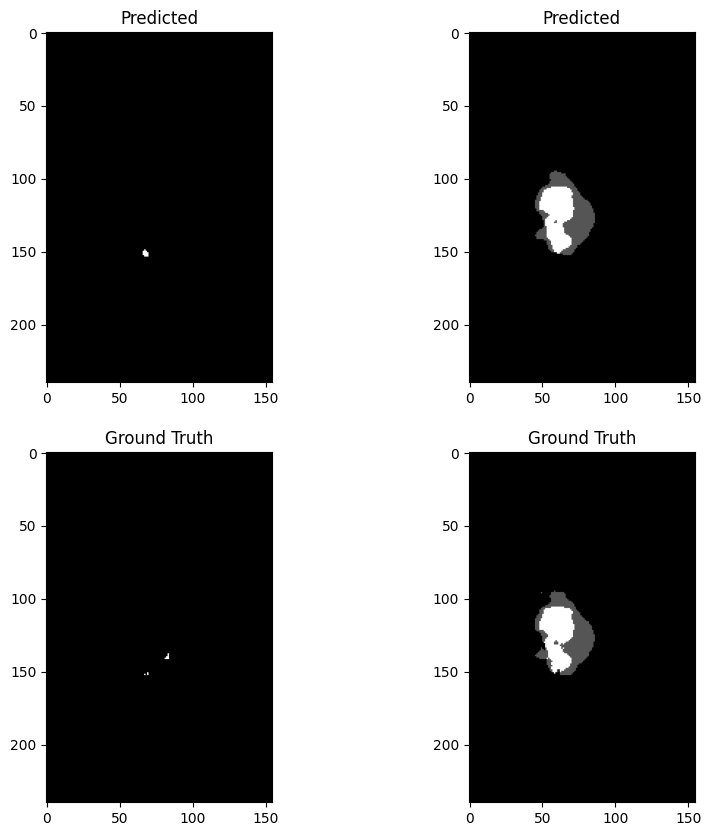

100%|██████████| 39/39 [02:15<00:00,  3.48s/it]


Average Validation Loss: 0.011871589550700707

Average Validation DSC: [0.99903702 0.90118401 0.92770719 0.76959853]
Average Validation ASSD: [ 0.09521876 15.82704353 12.68139474 26.30825266]
Epoch 64/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


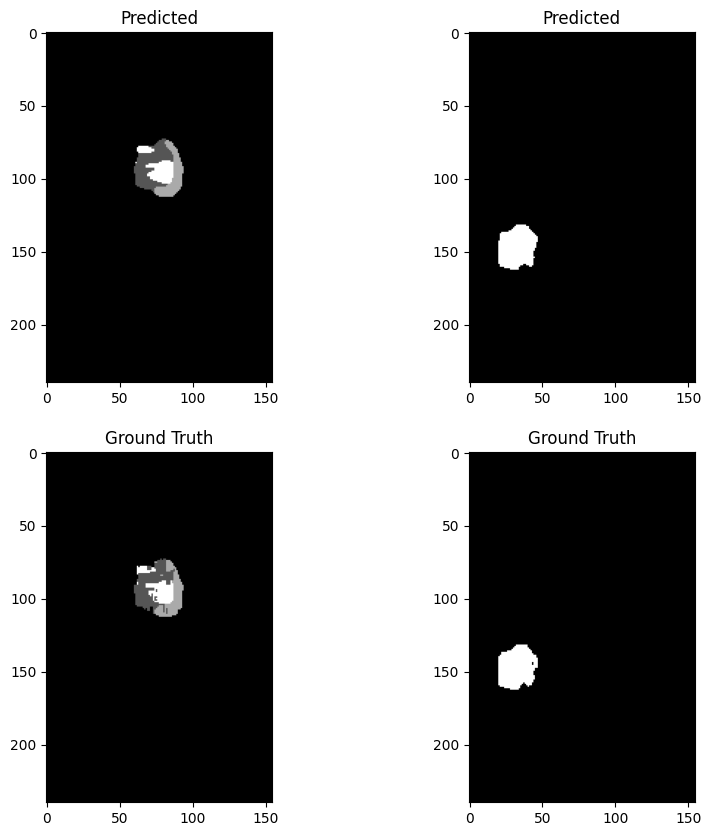

100%|██████████| 156/156 [09:47<00:00,  3.77s/it]



Average Training Loss: 0.006069166633563164

Average Training DSC: [0.99931712 0.94245069 0.94970416 0.80715022]
Average Training ASSD: [ 0.06321986  3.6999215   7.06422214 28.28549944]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


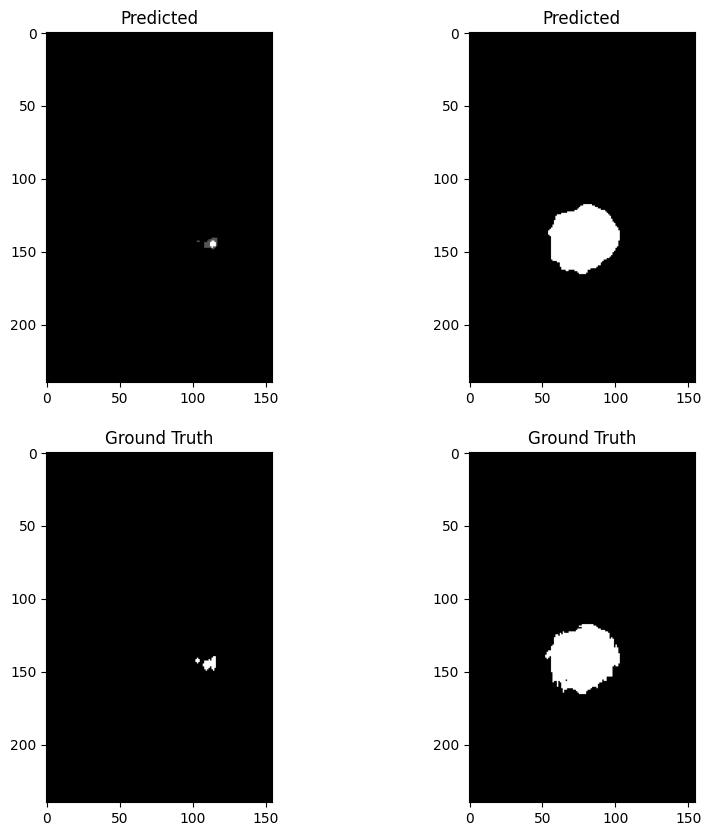

100%|██████████| 39/39 [02:24<00:00,  3.71s/it]


Average Validation Loss: 0.01208410863406383

Average Validation DSC: [0.99899202 0.90220363 0.92296707 0.77148111]
Average Validation ASSD: [ 0.09830798 15.44383497 14.1451103  28.76950512]
Epoch 65/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


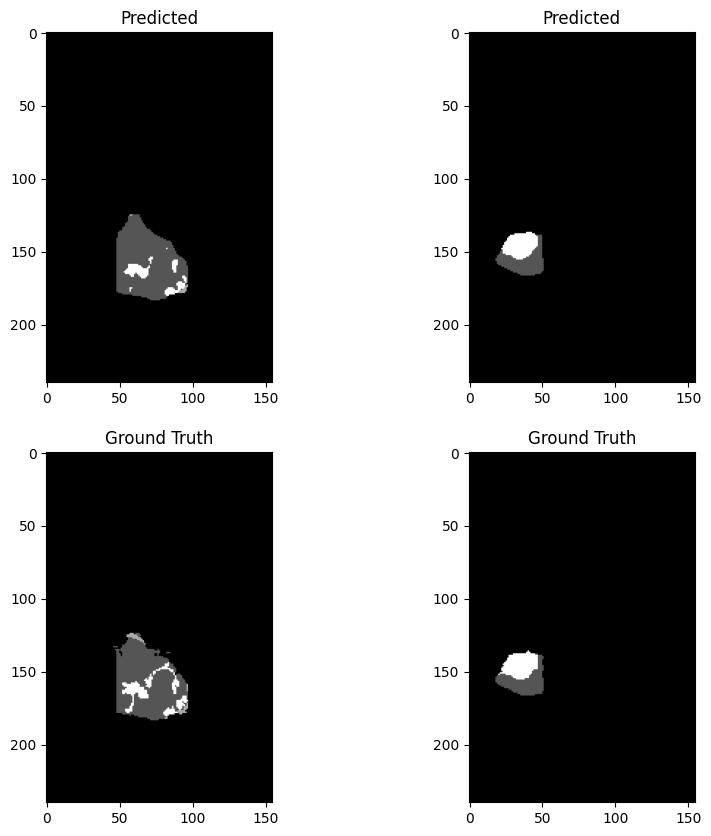

100%|██████████| 156/156 [09:57<00:00,  3.83s/it]



Average Training Loss: 0.006003911668160118

Average Training DSC: [0.99930432 0.9437974  0.94837961 0.81084794]
Average Training ASSD: [ 0.06421138  3.54542693  7.29347945 27.10335688]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


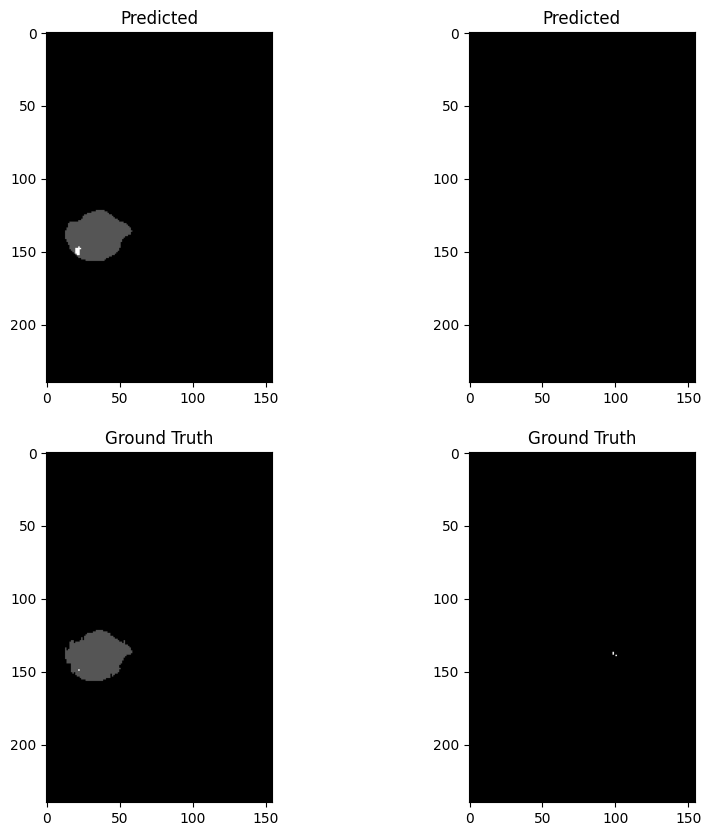

100%|██████████| 39/39 [02:15<00:00,  3.47s/it]


Average Validation Loss: 0.011962974718652474

Average Validation DSC: [0.99903304 0.90212653 0.9318437  0.78412082]
Average Validation ASSD: [ 0.09404884 14.89147504 11.63488079 21.56453221]
Epoch 66/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


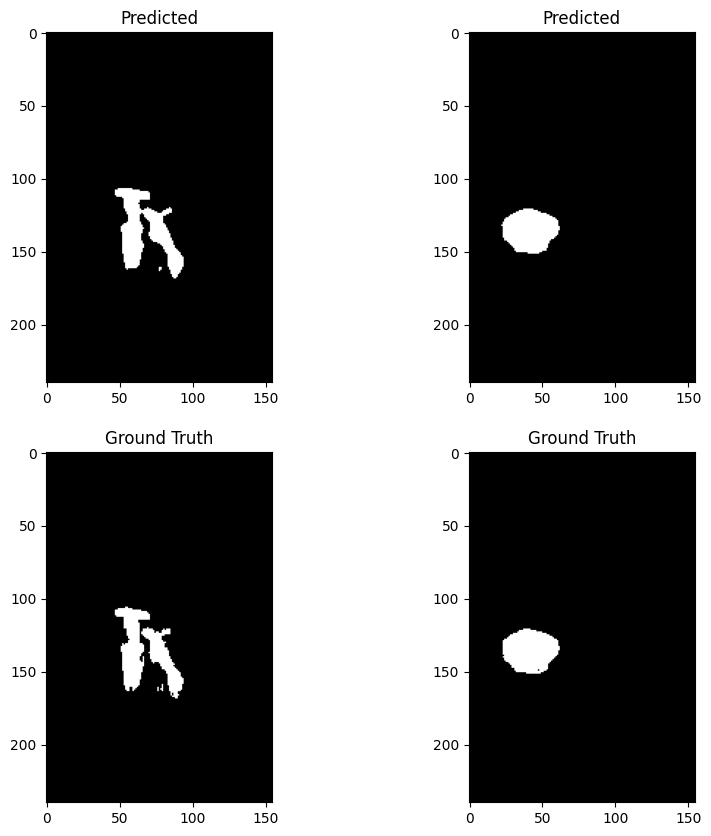

100%|██████████| 156/156 [09:53<00:00,  3.81s/it]



Average Training Loss: 0.005845708599409614

Average Training DSC: [0.99933475 0.94520066 0.95098242 0.81208791]
Average Training ASSD: [ 0.06251348  3.46696016  6.71986386 27.30297585]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


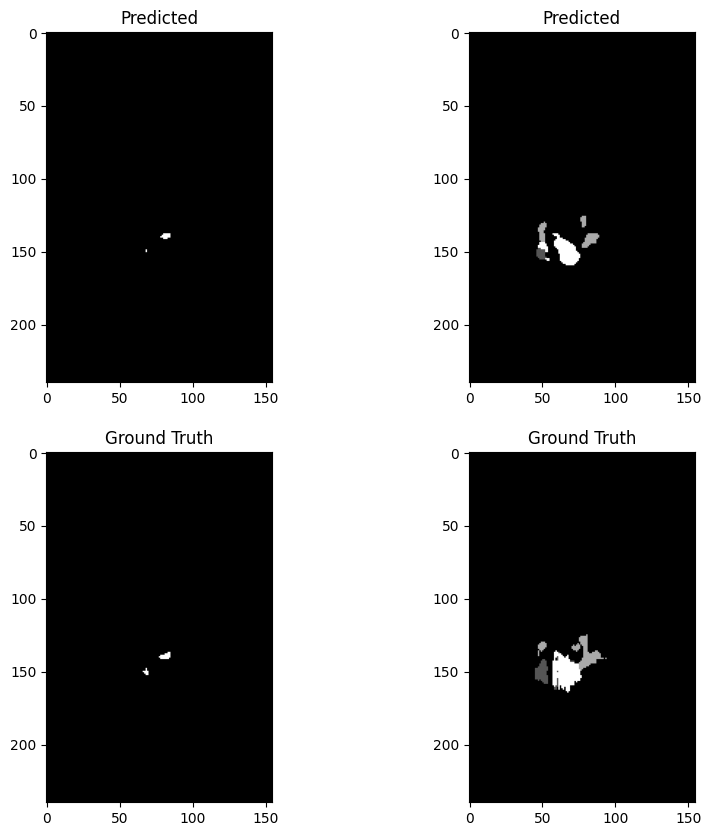

100%|██████████| 39/39 [02:18<00:00,  3.56s/it]


Average Validation Loss: 0.012364078802653613

Average Validation DSC: [0.99900369 0.89802611 0.92962997 0.77106781]
Average Validation ASSD: [ 0.10011139 16.18084978 11.61457856 27.41216804]
Epoch 67/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


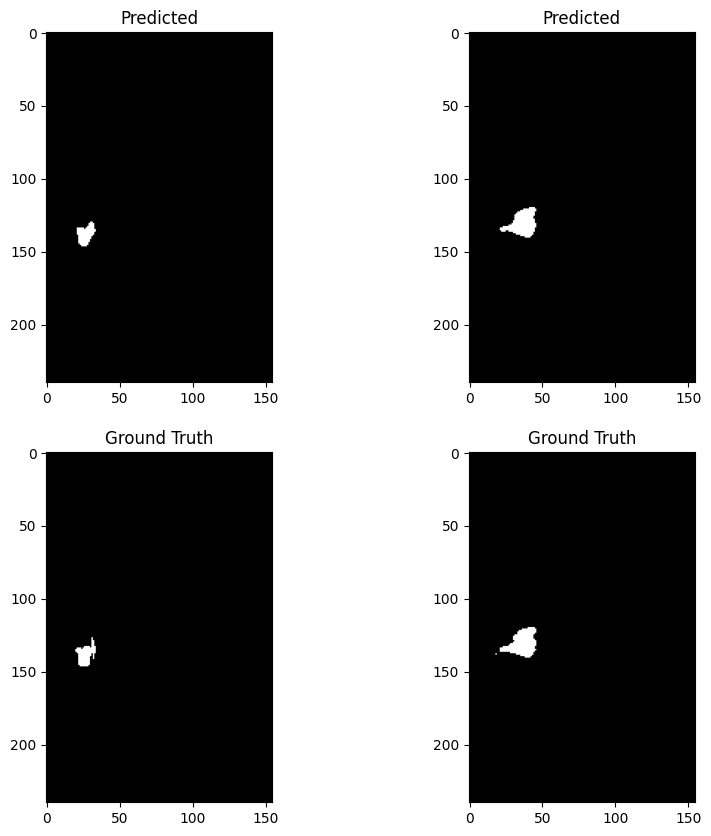

100%|██████████| 156/156 [09:59<00:00,  3.85s/it]



Average Training Loss: 0.0057802074305259455

Average Training DSC: [0.99934287 0.94645358 0.95216747 0.8154656 ]
Average Training ASSD: [ 0.06113814  3.24437892  6.78581445 26.35026121]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


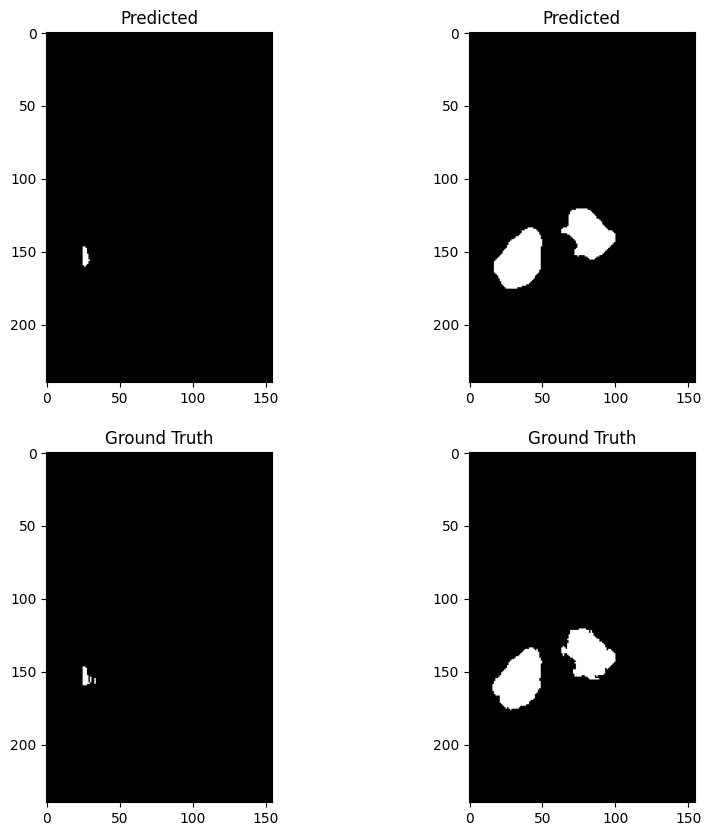

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.012141371647325845

Average Validation DSC: [0.99904804 0.9017319  0.93237892 0.78094112]
Average Validation ASSD: [ 0.09411314 15.59030734 11.24876325 22.88032421]
Epoch 68/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


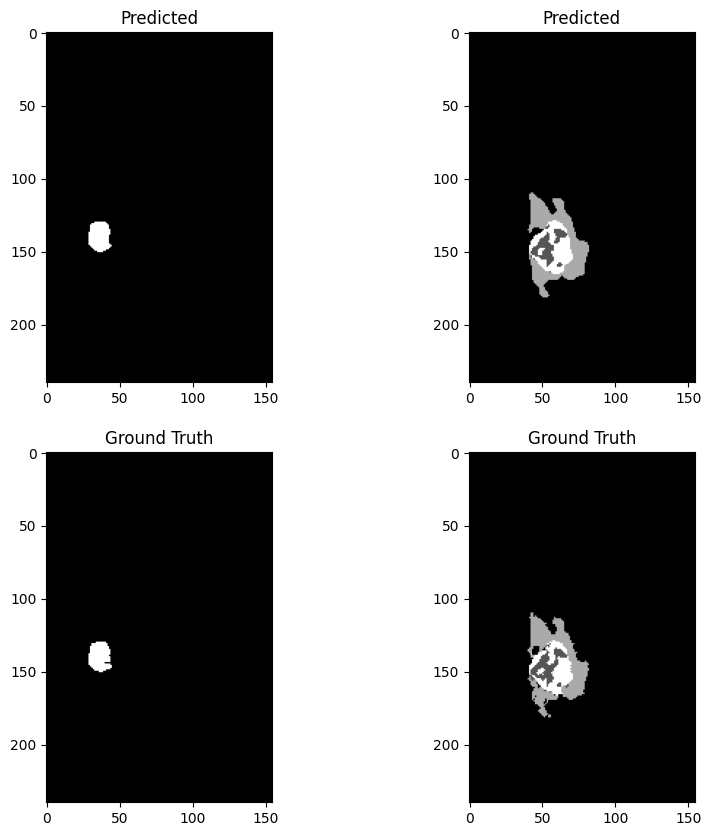

100%|██████████| 156/156 [09:50<00:00,  3.79s/it]



Average Training Loss: 0.005685936990910425

Average Training DSC: [0.99935841 0.94755289 0.95028576 0.8166568 ]
Average Training ASSD: [ 0.0587918   2.80594725  7.20413403 25.75102997]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


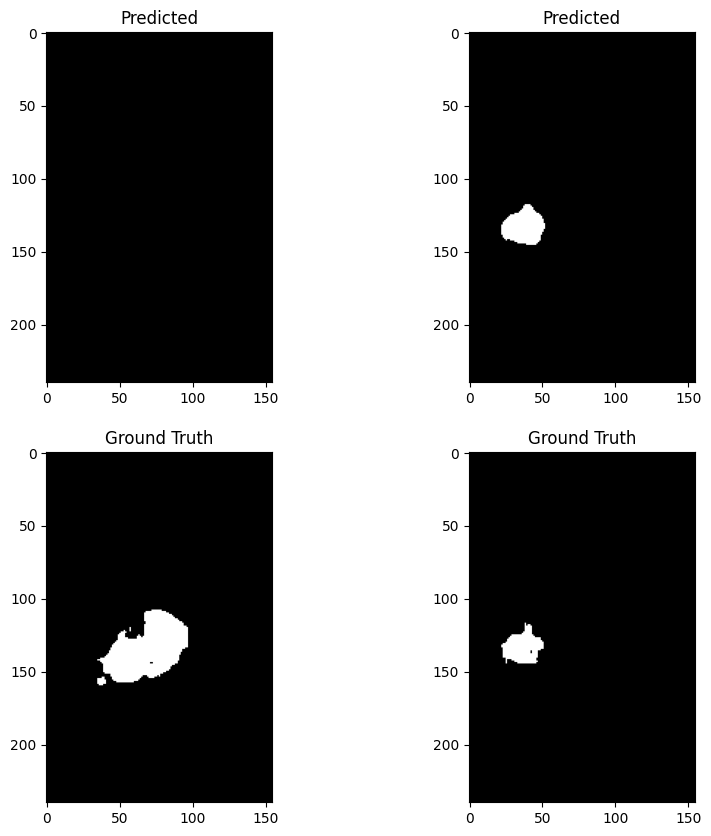

100%|██████████| 39/39 [02:23<00:00,  3.68s/it]


Average Validation Loss: 0.012214034377859954

Average Validation DSC: [0.99906075 0.90068718 0.93041616 0.78797674]
Average Validation ASSD: [ 0.09158851 15.5020546  11.58642831 22.73957091]
Epoch 69/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


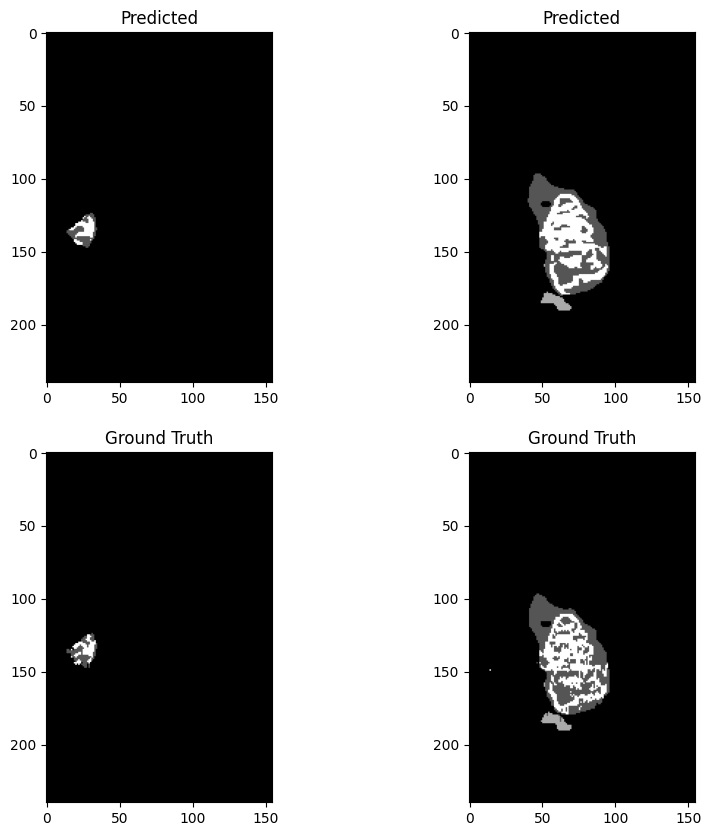

100%|██████████| 156/156 [09:43<00:00,  3.74s/it]



Average Training Loss: 0.005682478296176459

Average Training DSC: [0.9993544  0.94579814 0.95143355 0.8175486 ]
Average Training ASSD: [ 0.06012344  3.60324359  6.58378495 27.04264818]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


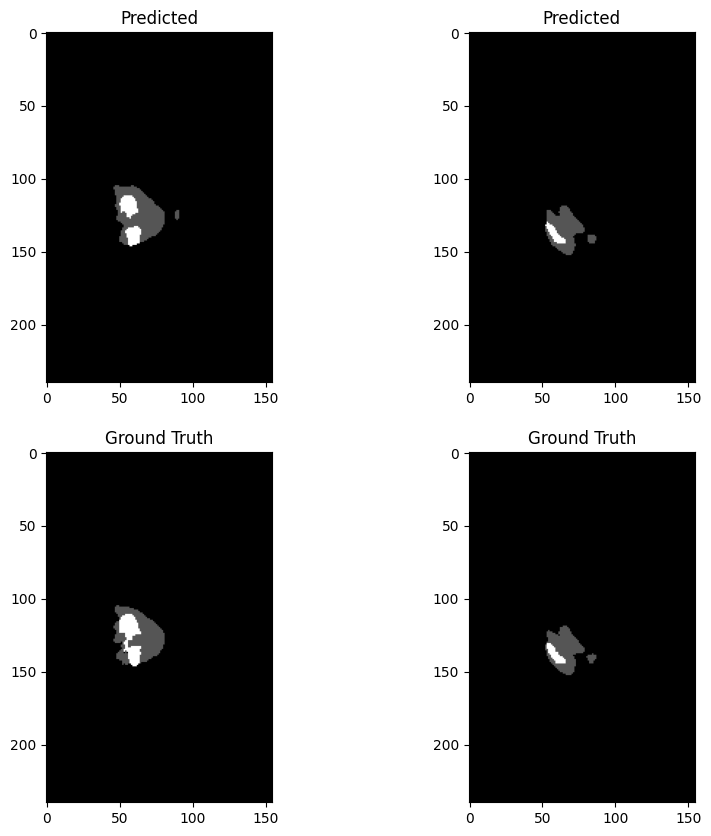

100%|██████████| 39/39 [02:20<00:00,  3.60s/it]


Average Validation Loss: 0.012475125563259307

Average Validation DSC: [0.99905244 0.9028029  0.93208508 0.77398612]
Average Validation ASSD: [ 0.08995506 14.65273484 11.55847324 25.02932872]
Epoch 70/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


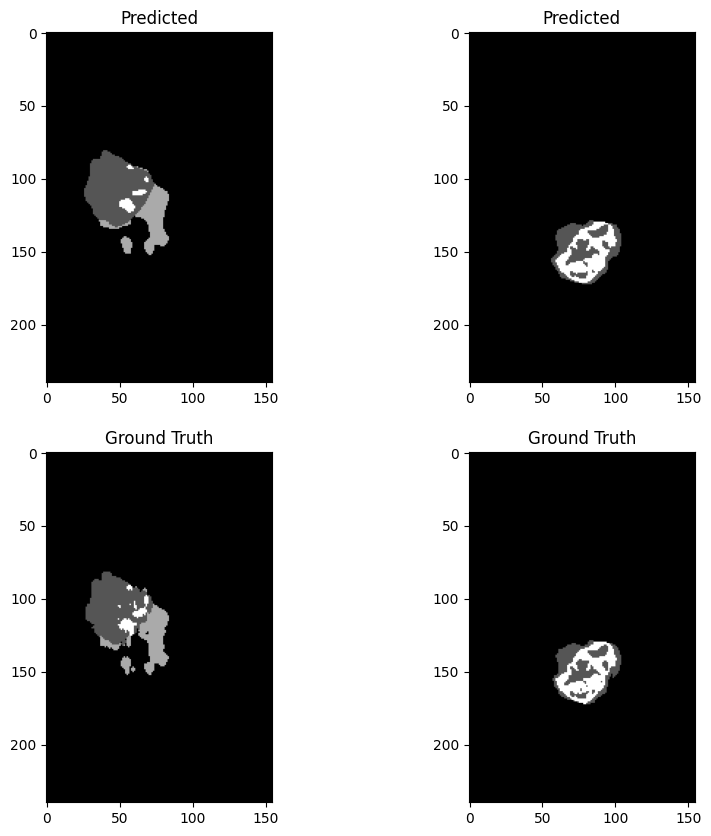

100%|██████████| 156/156 [09:49<00:00,  3.78s/it]



Average Training Loss: 0.005671457762125498

Average Training DSC: [0.99935178 0.94600782 0.95228293 0.81967905]
Average Training ASSD: [ 0.05995427  3.39092931  6.40507171 24.7093723 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


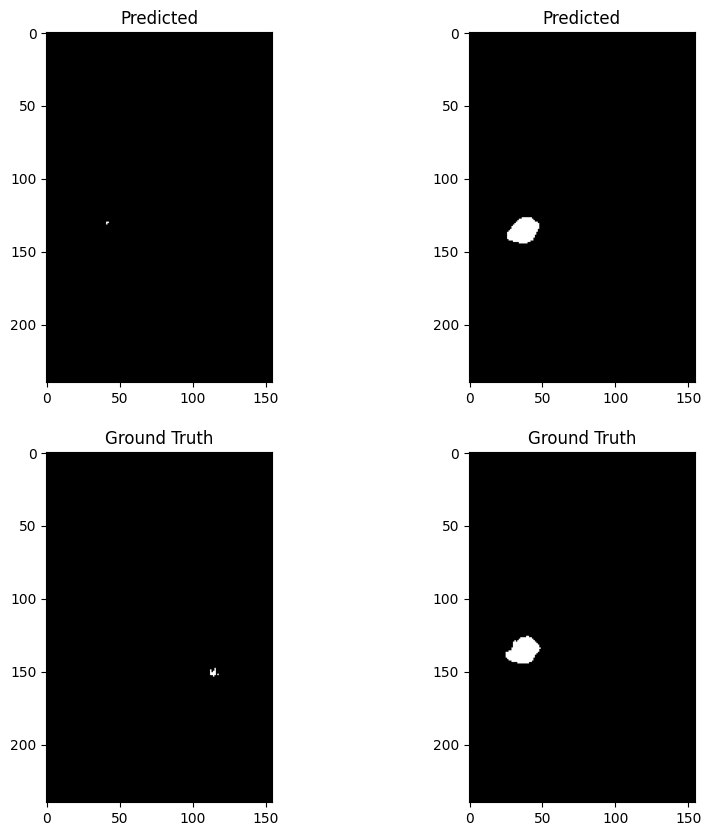

100%|██████████| 39/39 [02:20<00:00,  3.61s/it]


Average Validation Loss: 0.012421922352260504

Average Validation DSC: [0.99905305 0.90240177 0.93235631 0.77143594]
Average Validation ASSD: [ 0.08934619 14.74441559 10.93558455 25.91395473]
Epoch 71/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


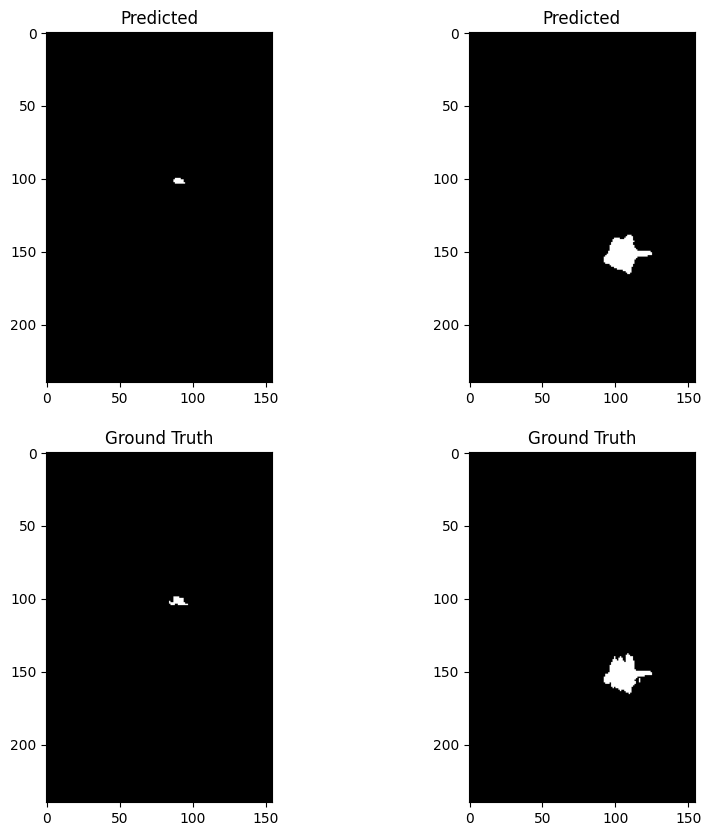

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.005863319295876397

Average Training DSC: [0.99933979 0.94273537 0.95047706 0.81101983]
Average Training ASSD: [ 0.06178742  3.61844777  6.70508037 26.5756357 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


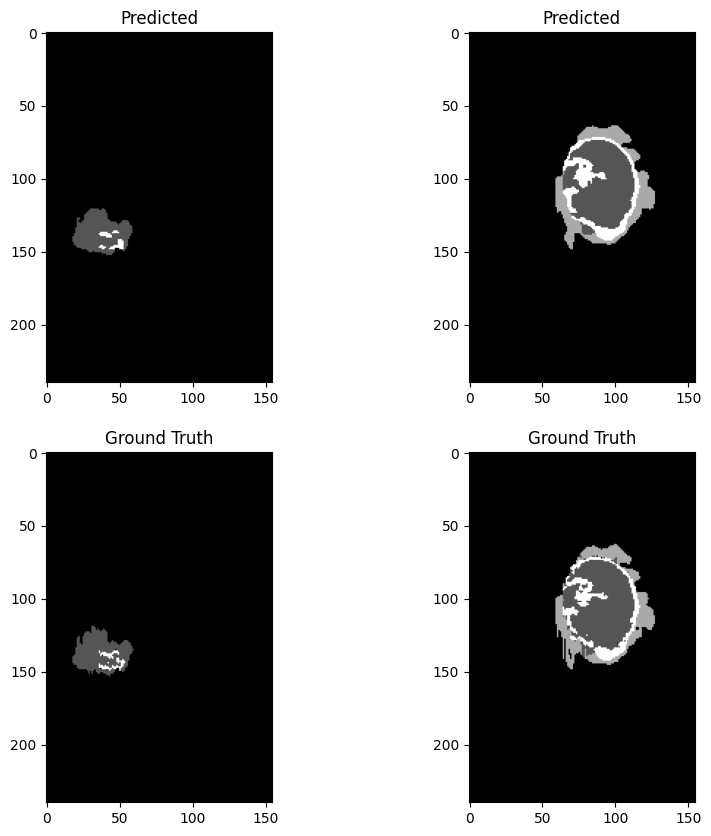

100%|██████████| 39/39 [02:22<00:00,  3.65s/it]


Average Validation Loss: 0.012213836985234266

Average Validation DSC: [0.99903061 0.89774153 0.93283862 0.78632808]
Average Validation ASSD: [ 0.0897091  15.59278341 10.16015529 18.96466197]
Epoch 72/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


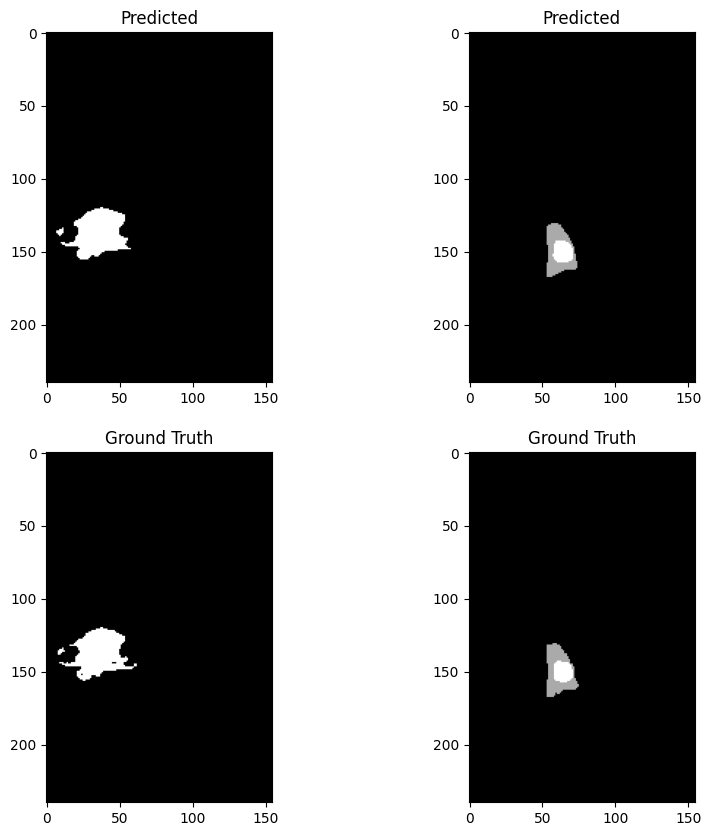

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.005780412406565096

Average Training DSC: [0.99935512 0.94148042 0.95157862 0.81498834]
Average Training ASSD: [ 0.05945662  4.0557348   6.85654016 25.35936444]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


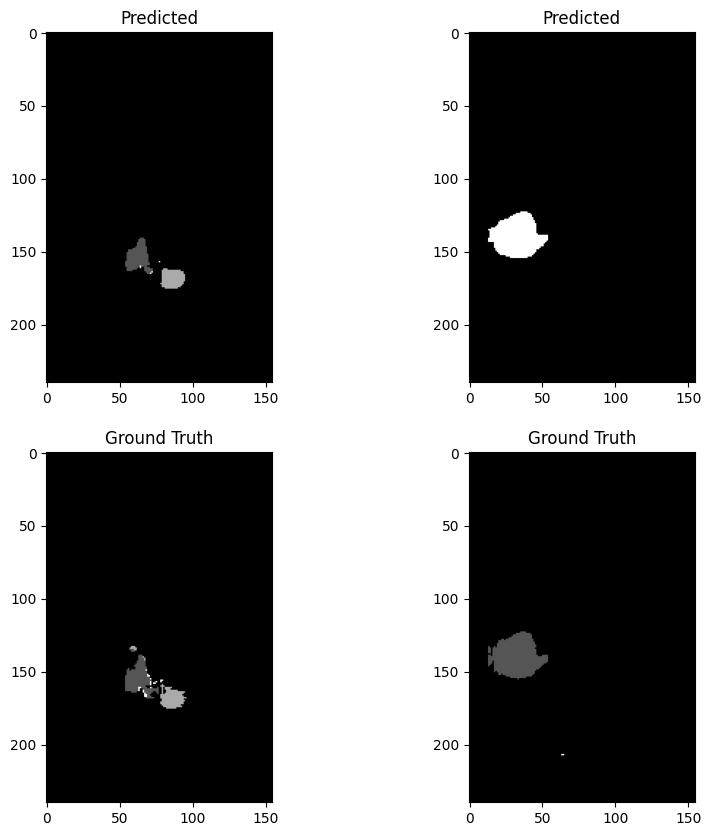

100%|██████████| 39/39 [02:15<00:00,  3.46s/it]


Average Validation Loss: 0.012053649000919018

Average Validation DSC: [0.99904643 0.88791645 0.93120533 0.78047541]
Average Validation ASSD: [ 0.09230686 18.50166381 12.38785026 24.49810389]
Epoch 73/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


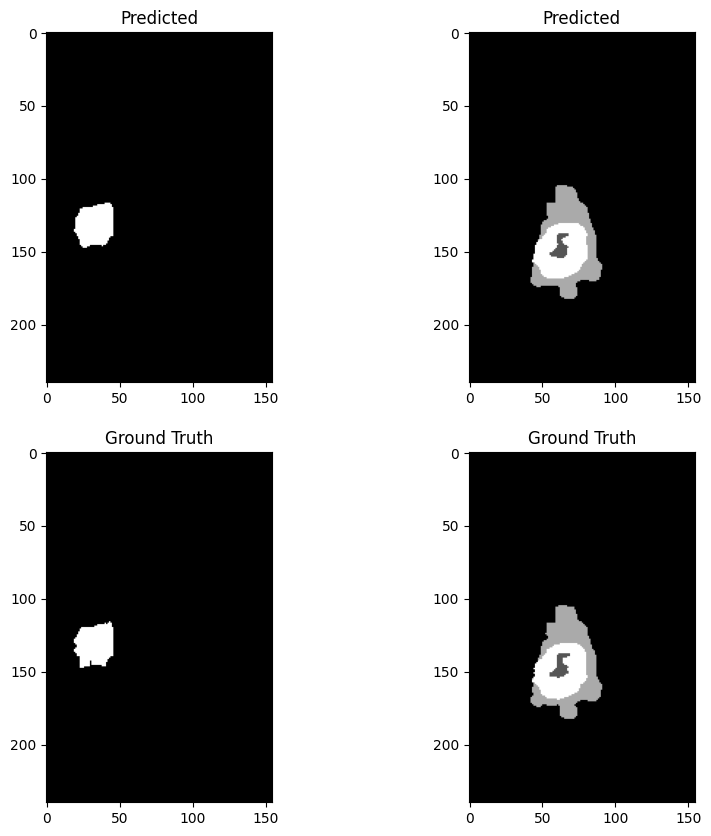

100%|██████████| 156/156 [09:44<00:00,  3.75s/it]



Average Training Loss: 0.005648061088346041

Average Training DSC: [0.99935765 0.94280271 0.95224074 0.81835196]
Average Training ASSD: [ 0.06016559  4.54630167  6.89793531 24.89405279]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


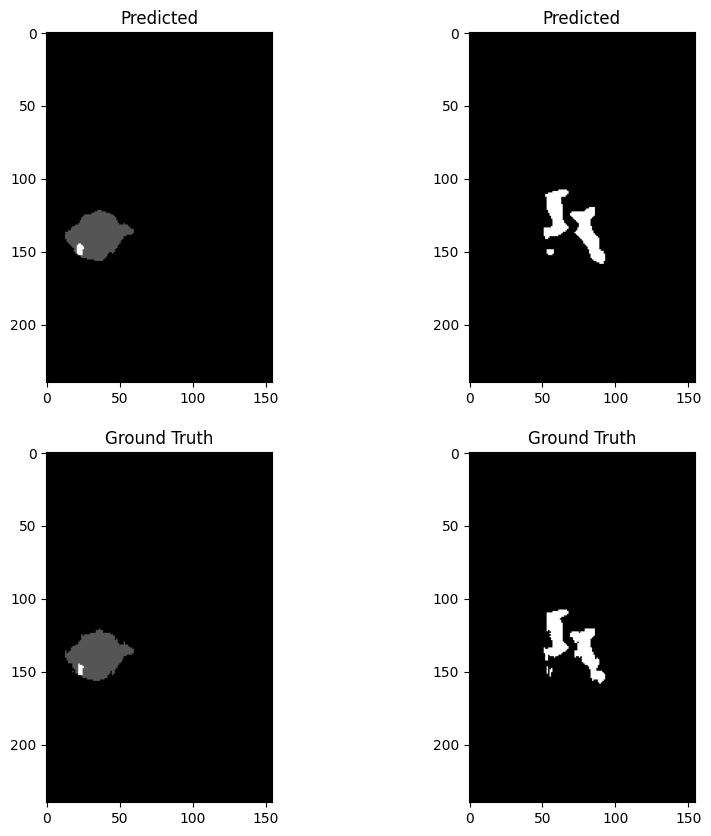

100%|██████████| 39/39 [02:24<00:00,  3.69s/it]


Average Validation Loss: 0.01161320187533513

Average Validation DSC: [0.99907081 0.90157158 0.93568638 0.79358262]
Average Validation ASSD: [ 0.08655651 15.15457034 10.67039601 16.38952042]
Epoch 74/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


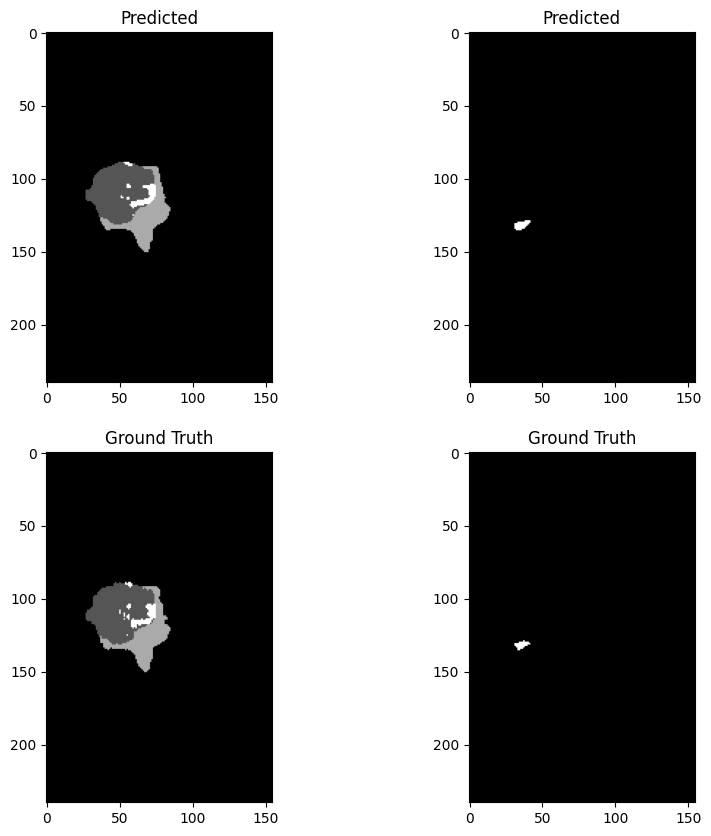

100%|██████████| 156/156 [09:45<00:00,  3.75s/it]



Average Training Loss: 0.006652364381947196

Average Training DSC: [0.99924515 0.92267076 0.93833194 0.80200368]
Average Training ASSD: [ 0.07039943  9.328288   10.23624278 24.10061955]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


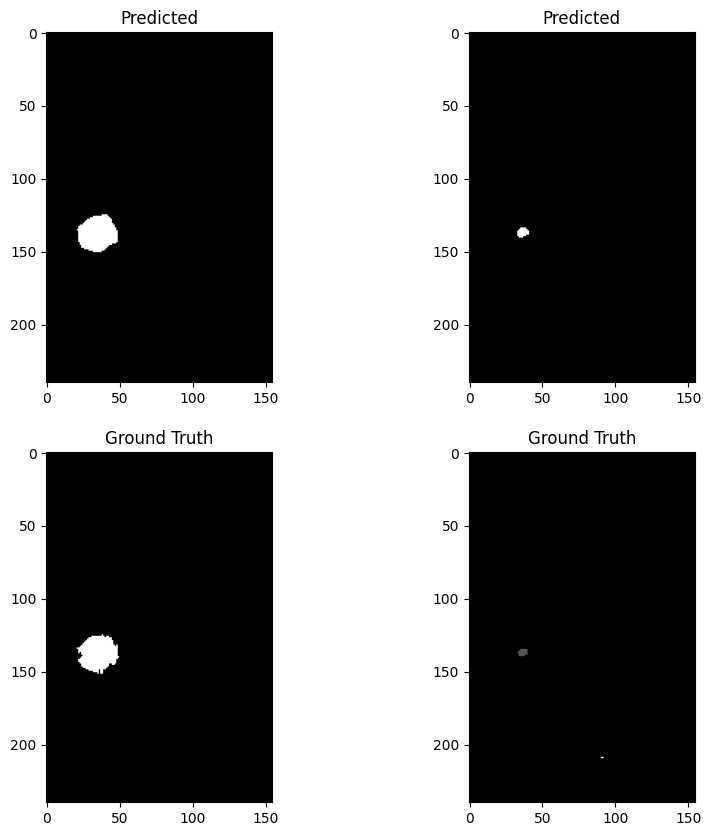

100%|██████████| 39/39 [02:19<00:00,  3.57s/it]


Average Validation Loss: 0.012831667879930673

Average Validation DSC: [0.99895883 0.87369206 0.92618319 0.76972237]
Average Validation ASSD: [ 0.10527893 22.71003085 13.0385534  24.39422304]
Epoch 75/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


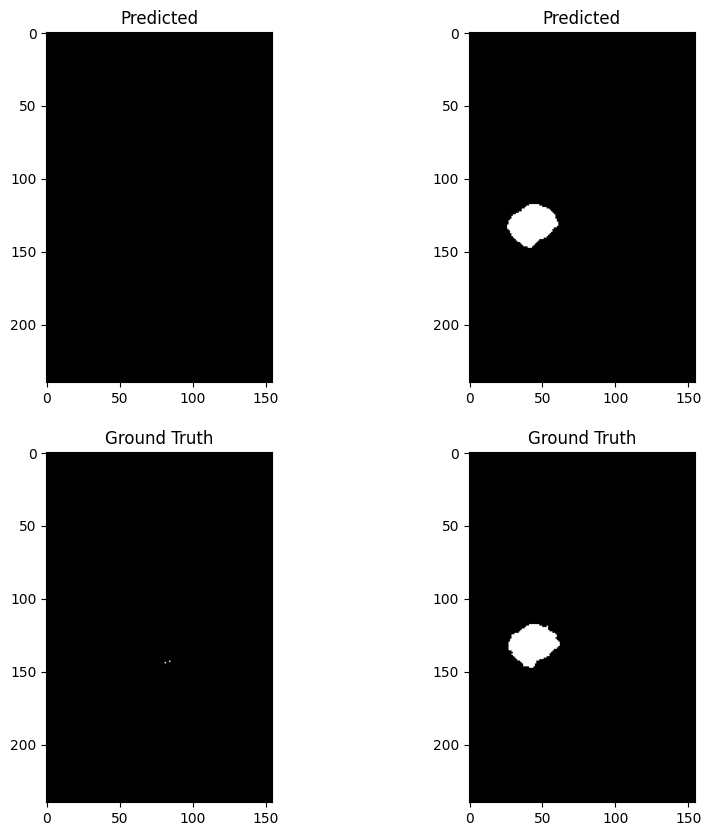

100%|██████████| 156/156 [09:51<00:00,  3.79s/it]



Average Training Loss: 0.009473668393464042

Average Training DSC: [0.99898341 0.88036933 0.92724487 0.75632986]
Average Training ASSD: [ 0.10073057 19.45805658 12.89729304 24.04510479]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


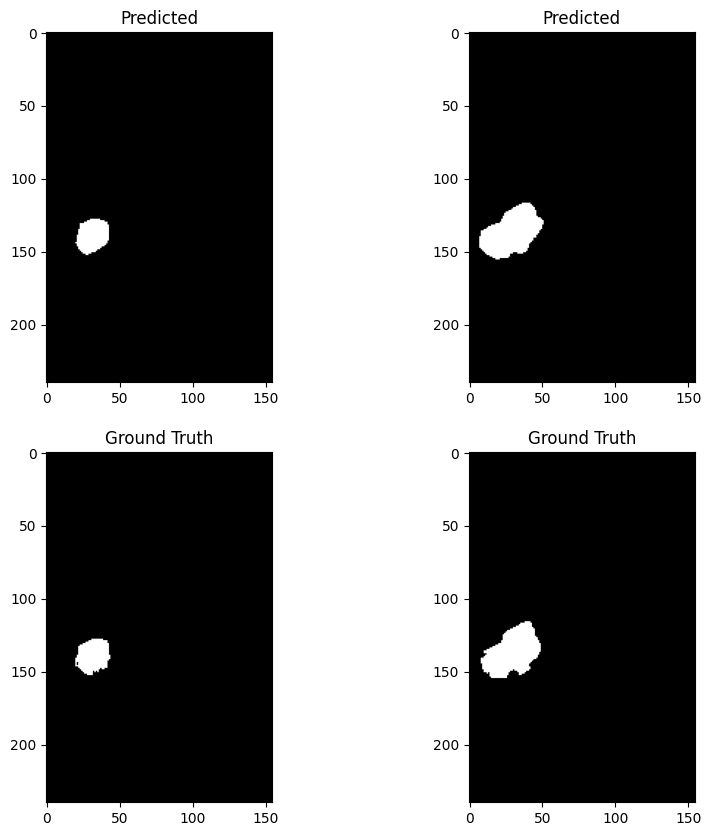

100%|██████████| 39/39 [02:19<00:00,  3.58s/it]


Average Validation Loss: 0.013421162258451566

Average Validation DSC: [0.99864492 0.85130934 0.85863532 0.72423318]
Average Validation ASSD: [ 0.1406611  26.95023756 33.14899275 32.4499582 ]
Epoch 76/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


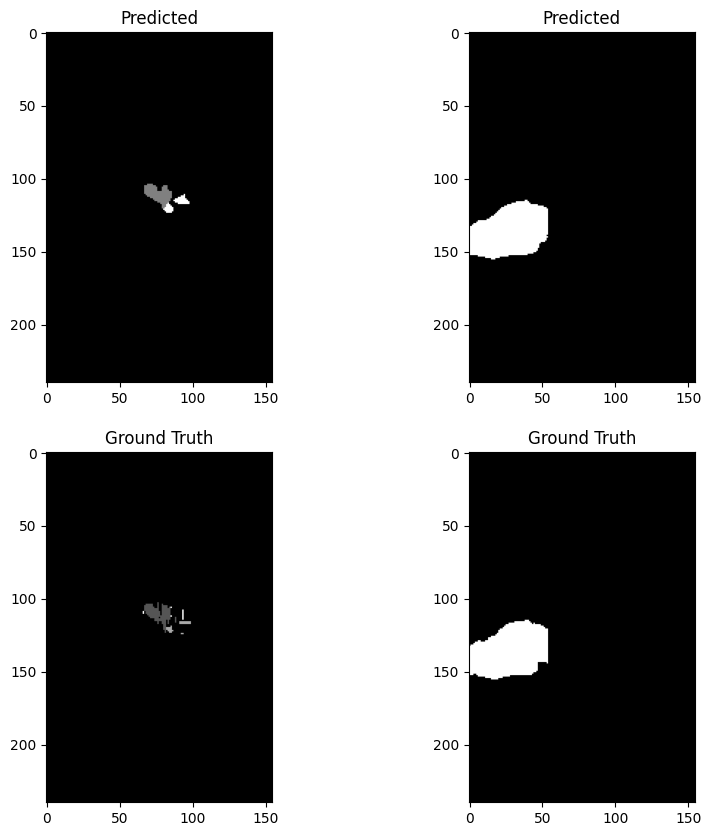

100%|██████████| 156/156 [09:56<00:00,  3.82s/it]



Average Training Loss: 0.007670729444959225

Average Training DSC: [0.99910708 0.91387636 0.9323642  0.78262727]
Average Training ASSD: [ 0.08924647 10.51819843 11.32418217 26.13856585]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


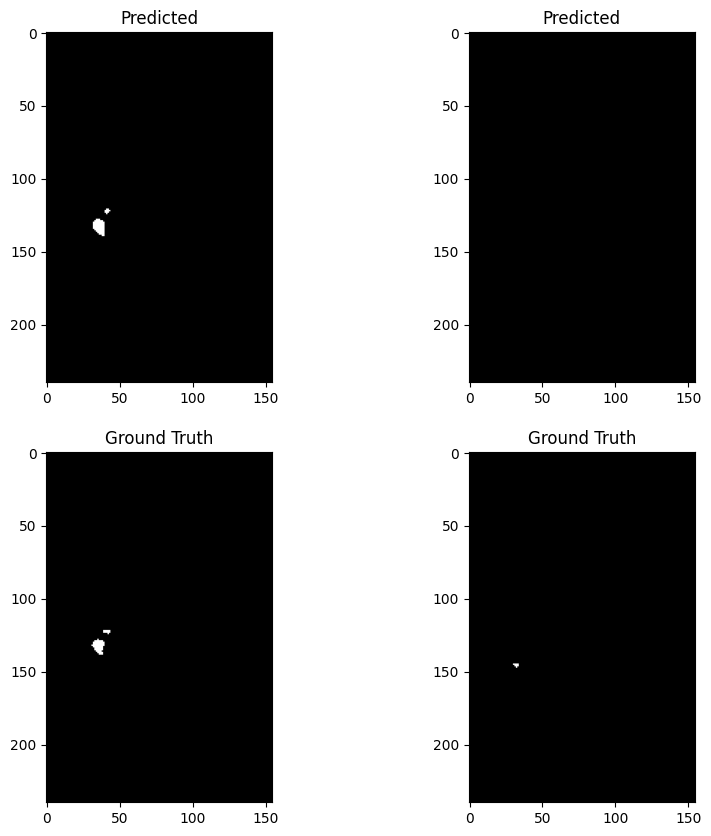

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.010598091778751368

Average Validation DSC: [0.99900196 0.88621748 0.9292101  0.77031783]
Average Validation ASSD: [ 0.09709002 19.54443699 12.69694097 25.24373579]
Epoch 77/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


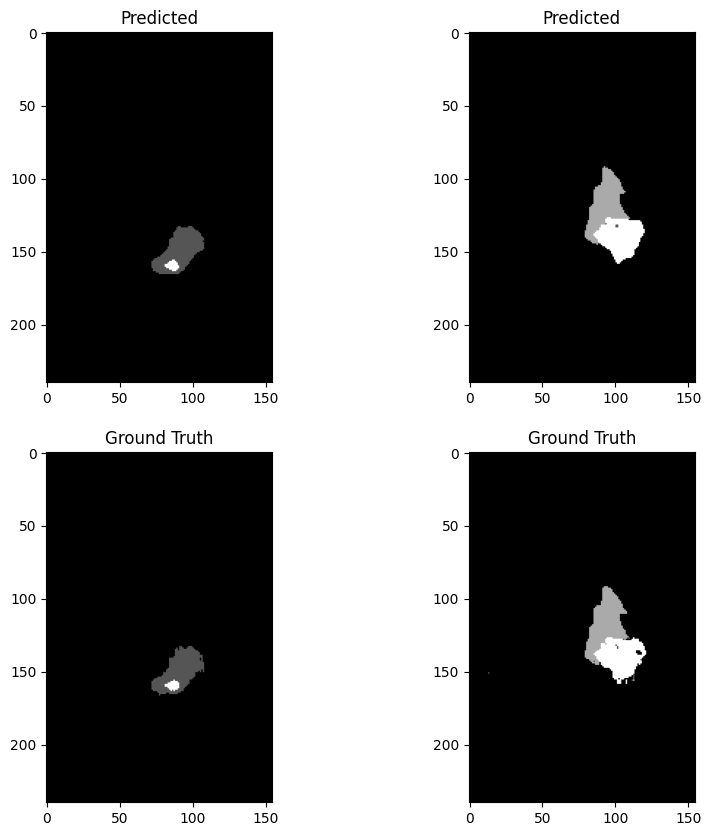

100%|██████████| 156/156 [09:52<00:00,  3.80s/it]



Average Training Loss: 0.006303432081133509

Average Training DSC: [0.99930738 0.93478225 0.94531057 0.80540363]
Average Training ASSD: [ 0.06502571  6.45368756  8.02302462 25.28649087]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


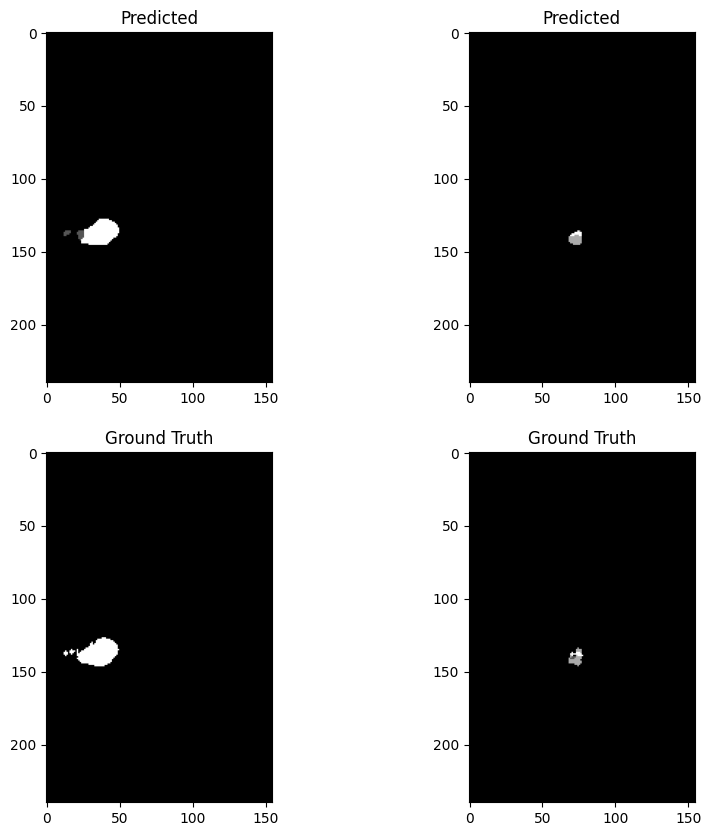

100%|██████████| 39/39 [02:16<00:00,  3.51s/it]


Average Validation Loss: 0.010704602544697432

Average Validation DSC: [0.99911245 0.89835269 0.93652497 0.7818046 ]
Average Validation ASSD: [ 0.09030721 16.73756122 10.13626606 25.60161597]
Epoch 78/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


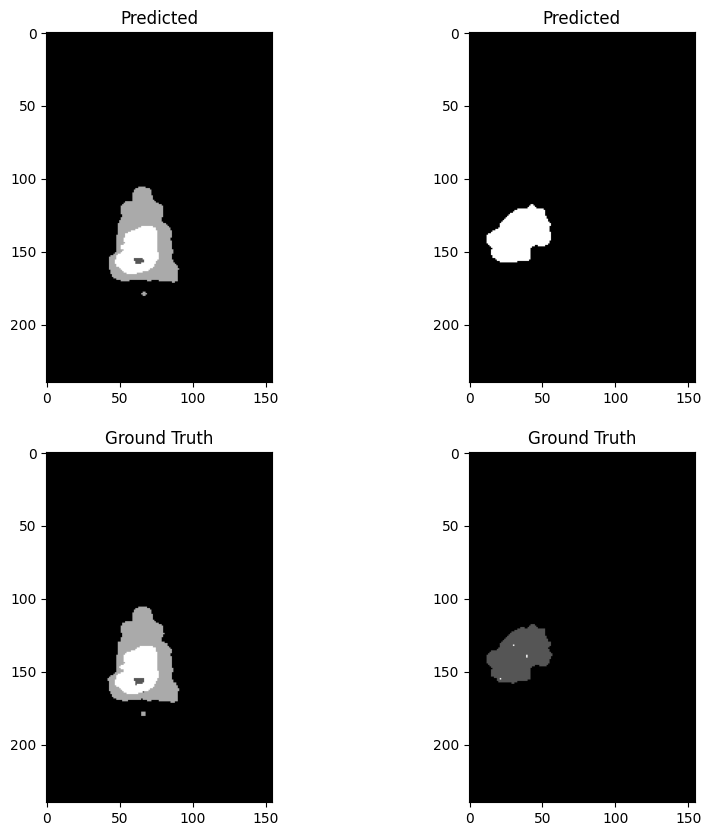

100%|██████████| 156/156 [09:26<00:00,  3.63s/it]



Average Training Loss: 0.00525896686863584

Average Training DSC: [0.99941247 0.94815985 0.95505961 0.82623323]
Average Training ASSD: [ 0.05476284  4.01712802  6.24336517 25.23457663]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


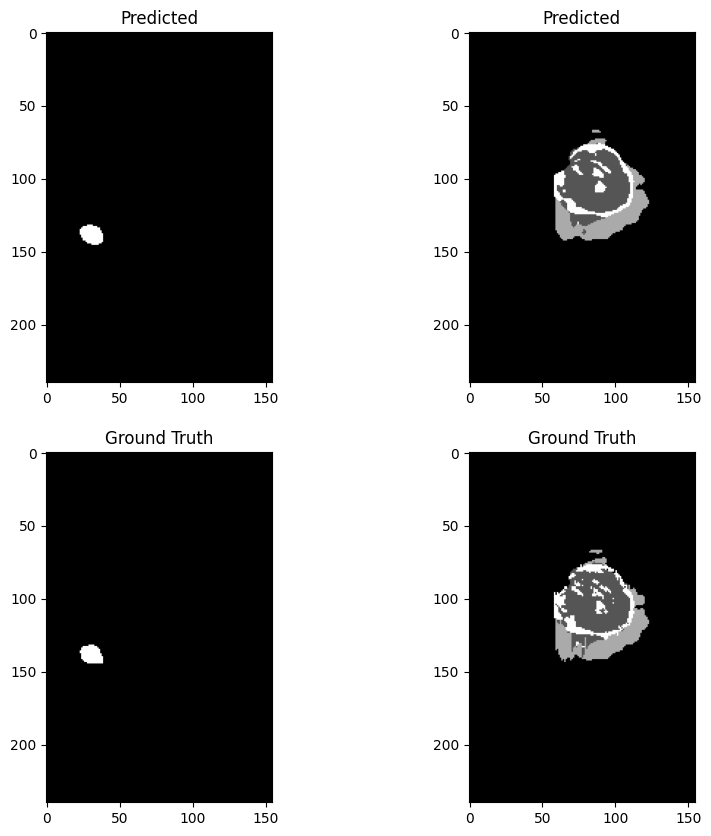

100%|██████████| 39/39 [02:23<00:00,  3.69s/it]


Average Validation Loss: 0.010982248454521865

Average Validation DSC: [0.99914149 0.90291859 0.94110974 0.79892982]
Average Validation ASSD: [ 0.08208543 16.09577111  9.19741605 19.41150935]
Epoch 79/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


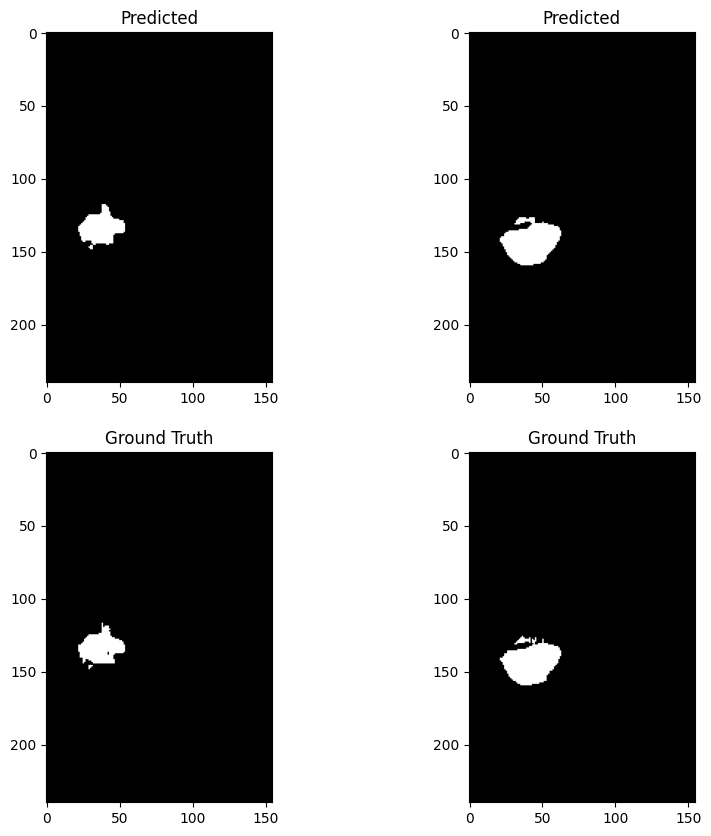

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.005808331851417629

Average Training DSC: [0.99934734 0.93697599 0.95034883 0.81595515]
Average Training ASSD: [ 0.060772    6.67136588  7.76278335 23.00814825]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


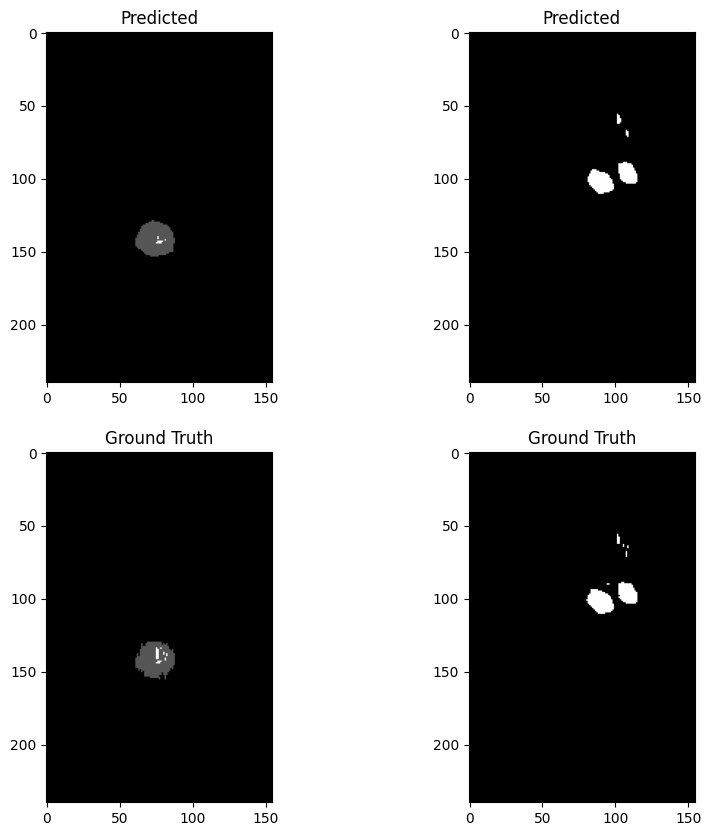

100%|██████████| 39/39 [02:19<00:00,  3.57s/it]


Average Validation Loss: 0.010347582972966708

Average Validation DSC: [0.99914875 0.90753625 0.93837795 0.7986433 ]
Average Validation ASSD: [ 0.0828119  14.63827049 10.09559716 20.56979213]
Epoch 80/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


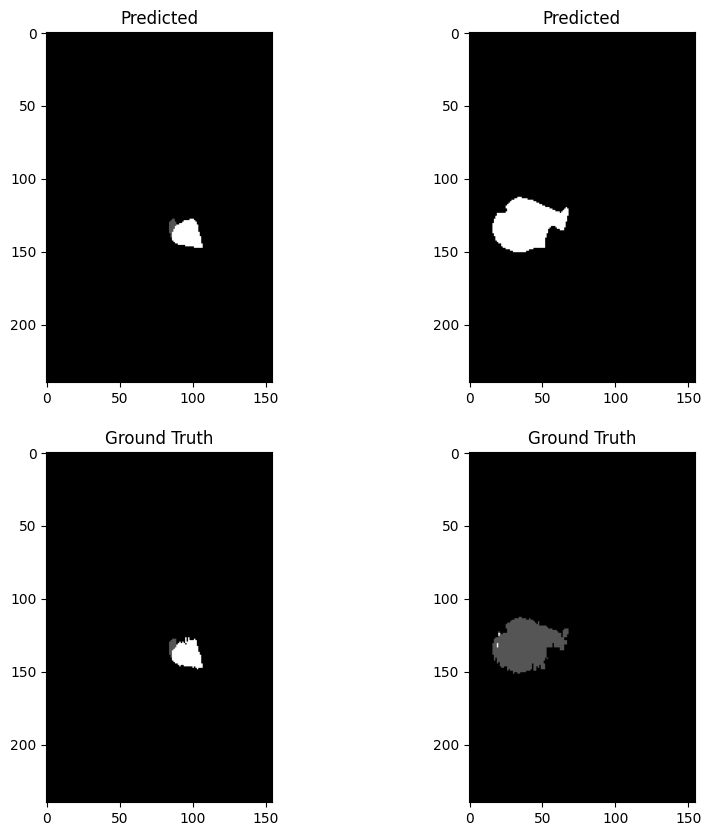

100%|██████████| 156/156 [09:45<00:00,  3.75s/it]



Average Training Loss: 0.005009655263095807

Average Training DSC: [0.99945337 0.95091164 0.95706262 0.83278394]
Average Training ASSD: [ 0.04958415  3.4269372   6.08820494 23.82793639]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


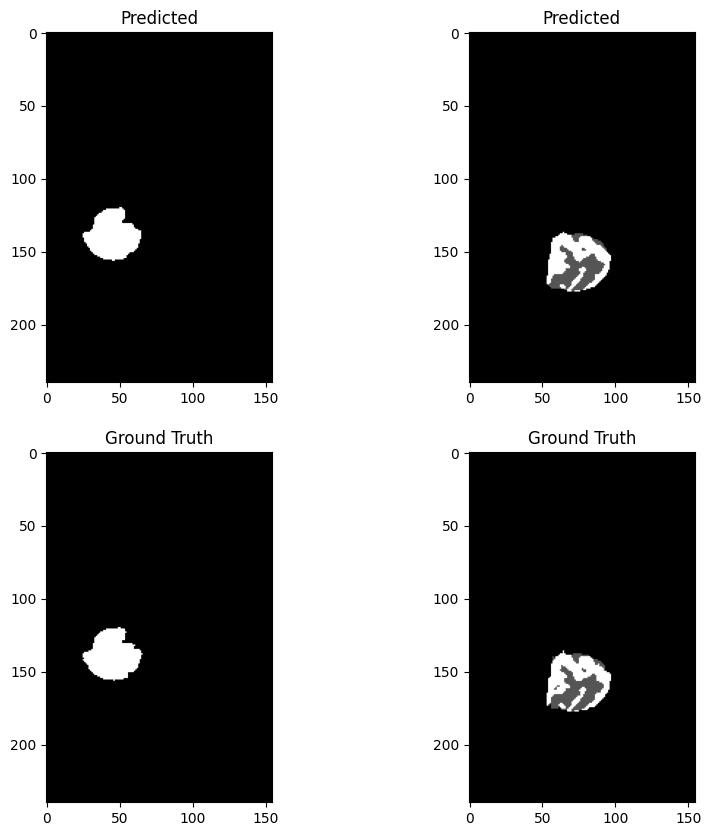

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.01063306667865851

Average Validation DSC: [0.99918364 0.91044479 0.93983452 0.80103703]
Average Validation ASSD: [ 0.08180085 14.61944651 10.3669979  21.08652997]
Epoch 81/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


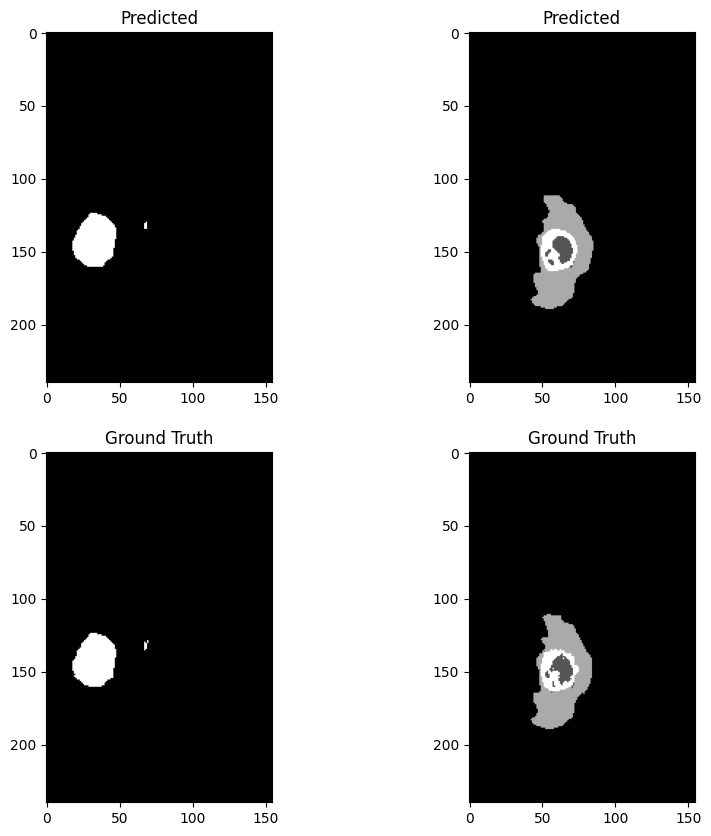

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.00470647861649736

Average Training DSC: [0.999486   0.95593773 0.95911823 0.84346589]
Average Training ASSD: [ 0.04625107  2.3227199   5.07079288 22.62962381]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


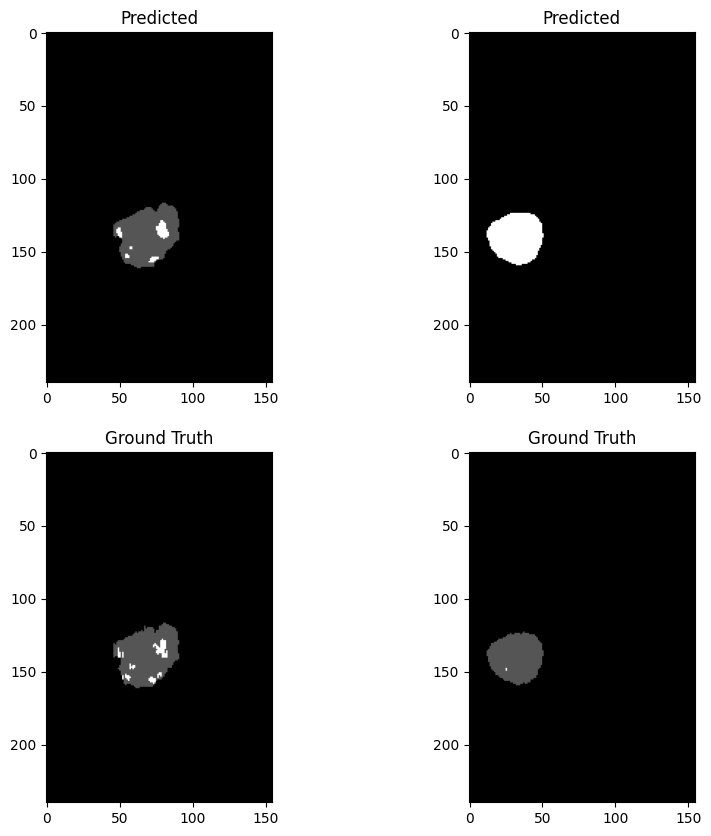

100%|██████████| 39/39 [02:22<00:00,  3.66s/it]


Average Validation Loss: 0.010893159450437779

Average Validation DSC: [0.99918003 0.90913464 0.93990197 0.80000626]
Average Validation ASSD: [ 0.08024132 14.62152603  9.17725085 20.83921795]
Epoch 82/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


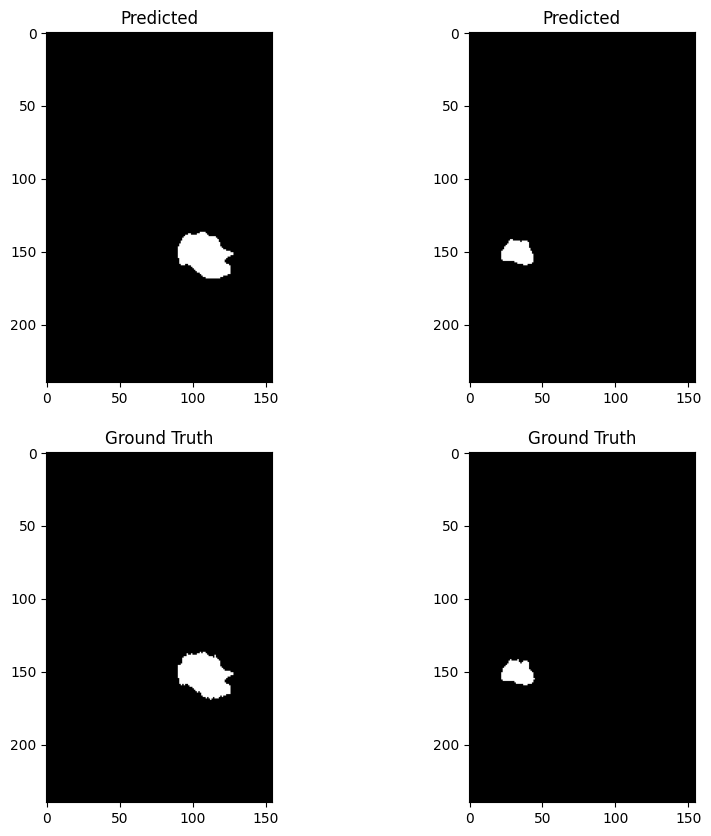

100%|██████████| 156/156 [10:11<00:00,  3.92s/it]



Average Training Loss: 0.0046206408028061

Average Training DSC: [0.99948964 0.95572133 0.95943612 0.84637839]
Average Training ASSD: [ 0.04473919  2.68434355  5.42915539 20.8446462 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


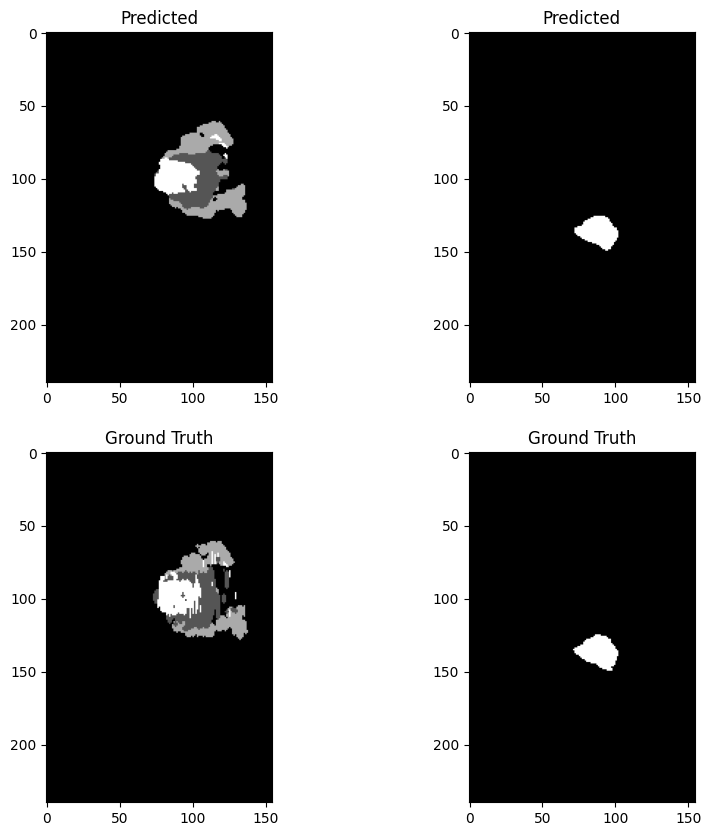

100%|██████████| 39/39 [02:17<00:00,  3.53s/it]


Average Validation Loss: 0.011052107975746576

Average Validation DSC: [0.99919395 0.90657515 0.93846428 0.8072392 ]
Average Validation ASSD: [ 0.07842422 15.74399343 10.59533384 19.65900677]
Epoch 83/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


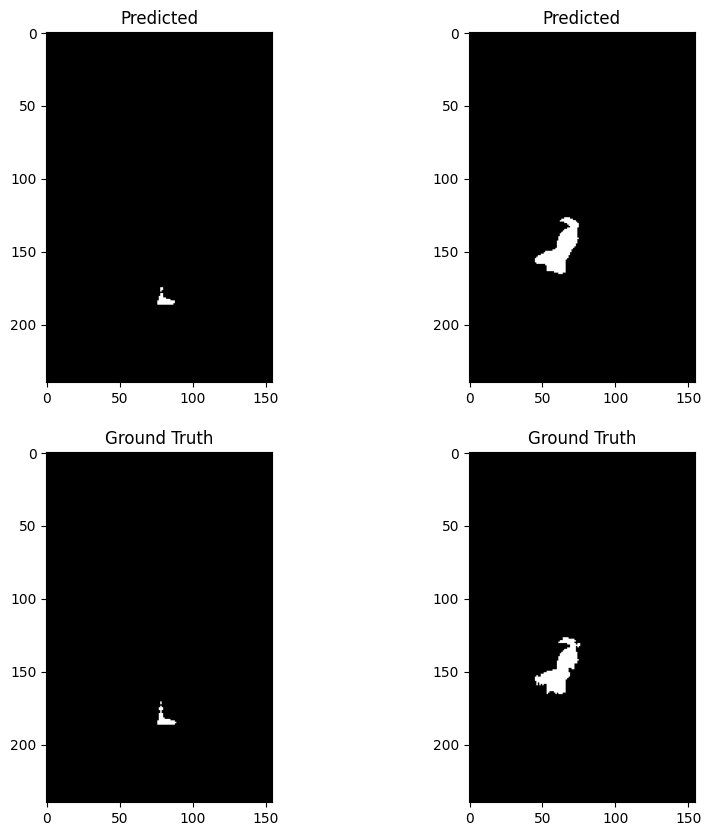

100%|██████████| 156/156 [09:53<00:00,  3.81s/it]



Average Training Loss: 0.004642428479527529

Average Training DSC: [0.99948131 0.95532995 0.95903947 0.84691933]
Average Training ASSD: [ 0.04631443  2.92034886  5.79218529 21.78578263]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


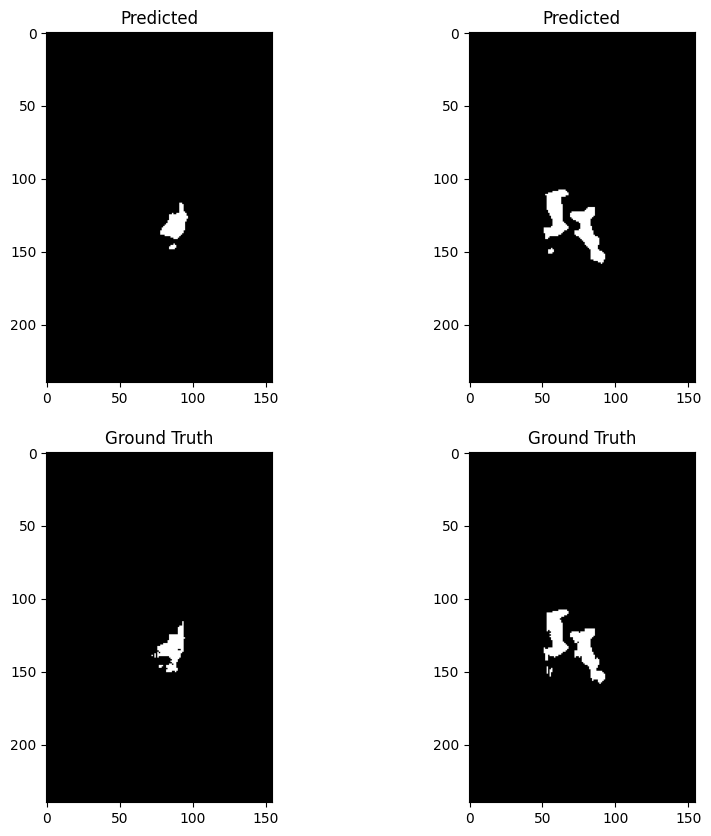

100%|██████████| 39/39 [02:23<00:00,  3.69s/it]


Average Validation Loss: 0.010953533069158975

Average Validation DSC: [0.99918531 0.9069608  0.94169717 0.80545412]
Average Validation ASSD: [ 0.07956419 15.74184155 10.29736207 18.63308493]
Epoch 84/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


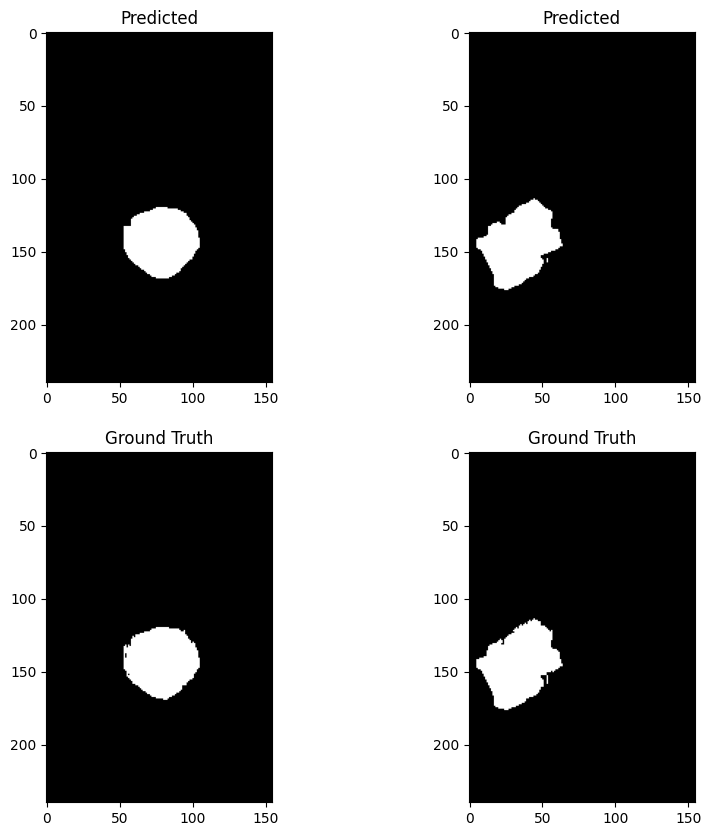

100%|██████████| 156/156 [09:42<00:00,  3.74s/it]



Average Training Loss: 0.0045348310914750285

Average Training DSC: [0.99949874 0.95693907 0.95886069 0.84837593]
Average Training ASSD: [ 0.04537785  2.45921962  5.4538192  20.84584847]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


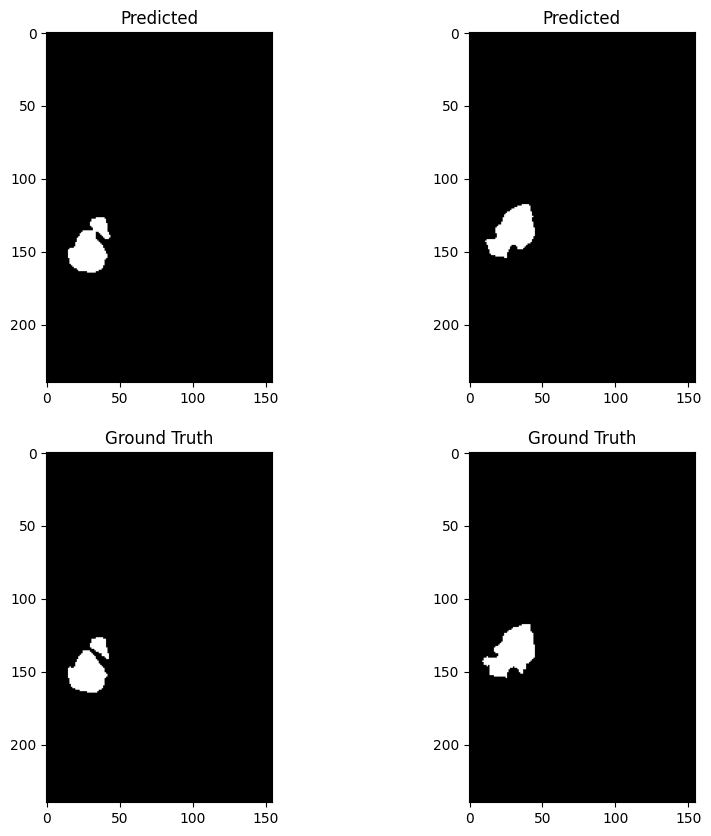

100%|██████████| 39/39 [02:19<00:00,  3.57s/it]


Average Validation Loss: 0.011225791970411172

Average Validation DSC: [0.99919628 0.90999559 0.93402086 0.80154001]
Average Validation ASSD: [ 0.07889686 15.11231554 11.76256062 21.78108724]
Epoch 85/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


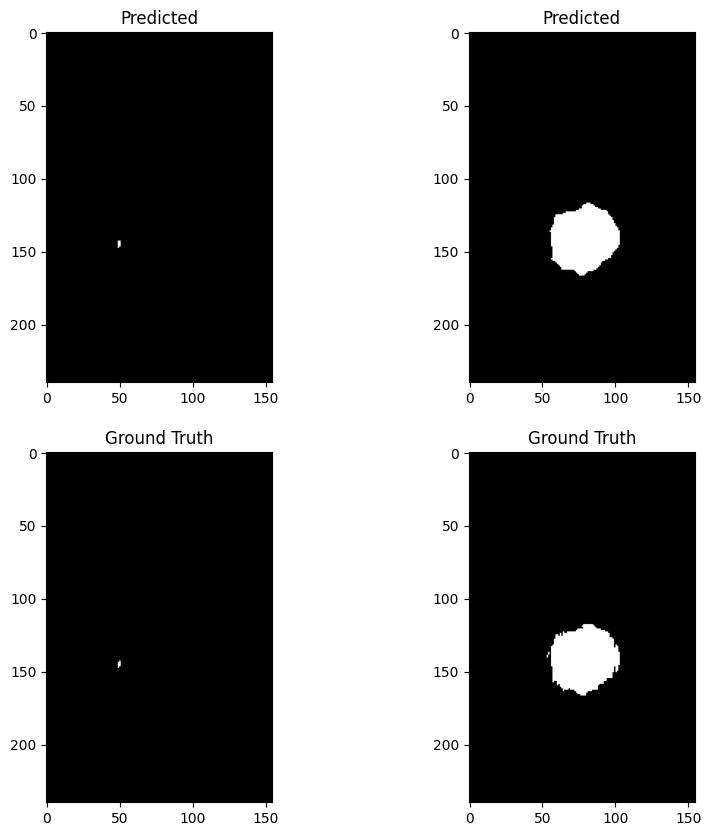

100%|██████████| 156/156 [09:53<00:00,  3.81s/it]



Average Training Loss: 0.0046082706838392485

Average Training DSC: [0.99948617 0.95535691 0.95956204 0.84850369]
Average Training ASSD: [ 0.04585605  2.68325715  5.35608178 20.37005306]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


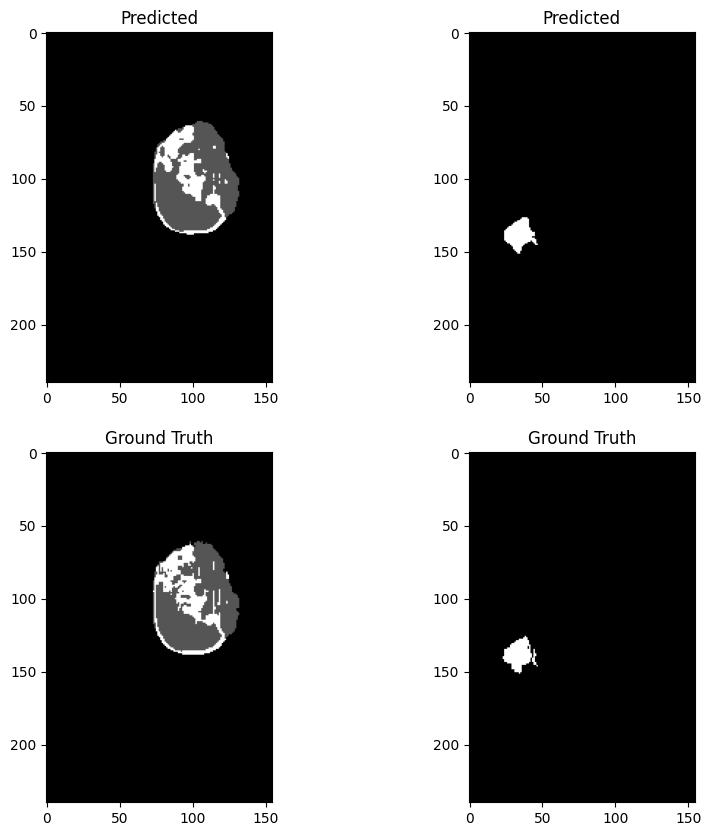

100%|██████████| 39/39 [02:17<00:00,  3.52s/it]


Average Validation Loss: 0.011329184966878248

Average Validation DSC: [0.99918075 0.90623961 0.94265075 0.80175883]
Average Validation ASSD: [ 0.07730331 16.60992224  8.87164374 19.83288116]
Epoch 86/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


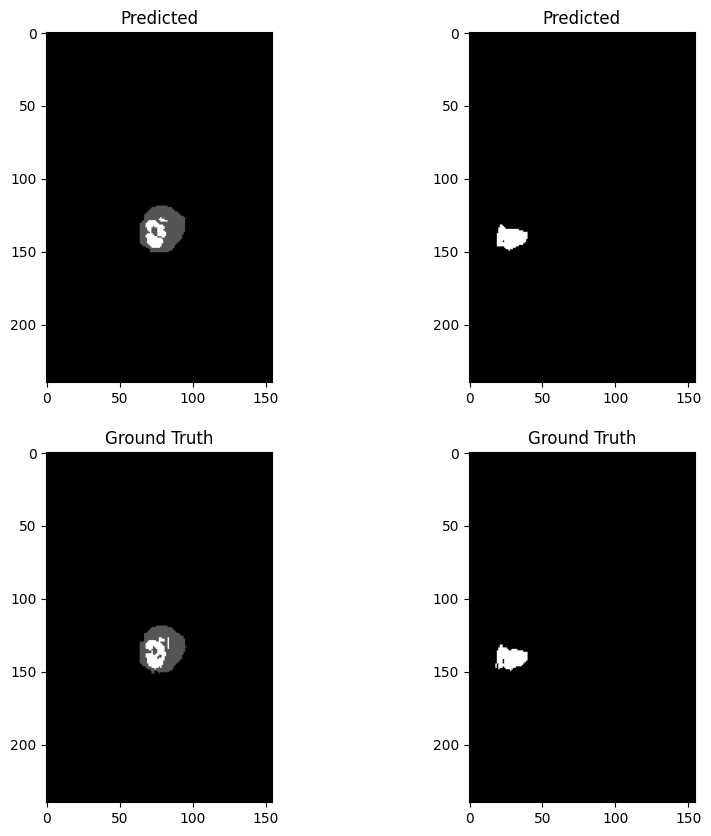

100%|██████████| 156/156 [09:45<00:00,  3.76s/it]



Average Training Loss: 0.00456638350778331

Average Training DSC: [0.99948951 0.95653609 0.95767271 0.85037297]
Average Training ASSD: [ 0.04532913  2.39473474  5.74956884 19.51625891]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


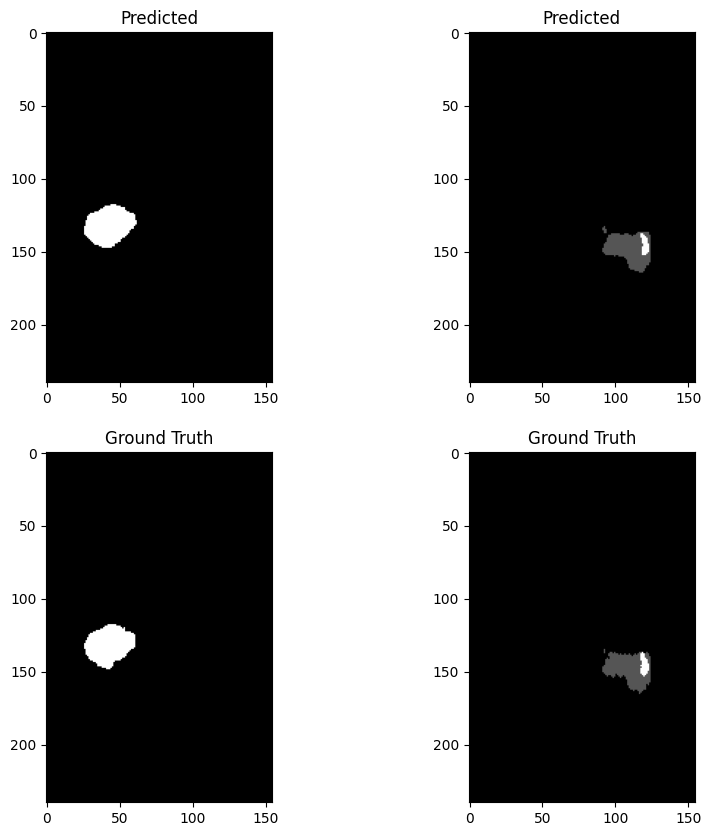

100%|██████████| 39/39 [02:20<00:00,  3.59s/it]


Average Validation Loss: 0.011365034808524145

Average Validation DSC: [0.99918354 0.90547655 0.94164801 0.80883927]
Average Validation ASSD: [ 0.07791295 16.55772294  8.58372623 17.1054838 ]
Epoch 87/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


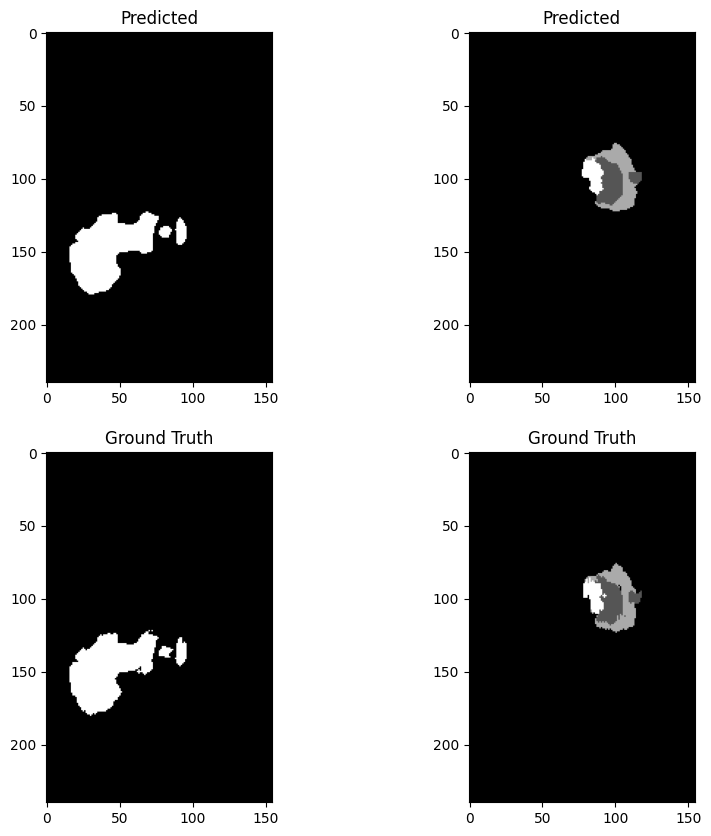

100%|██████████| 156/156 [09:35<00:00,  3.69s/it]



Average Training Loss: 0.0045535669091921775

Average Training DSC: [0.99948789 0.95646418 0.95906196 0.85102745]
Average Training ASSD: [ 0.04521786  2.67625666  4.85324236 19.63508556]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


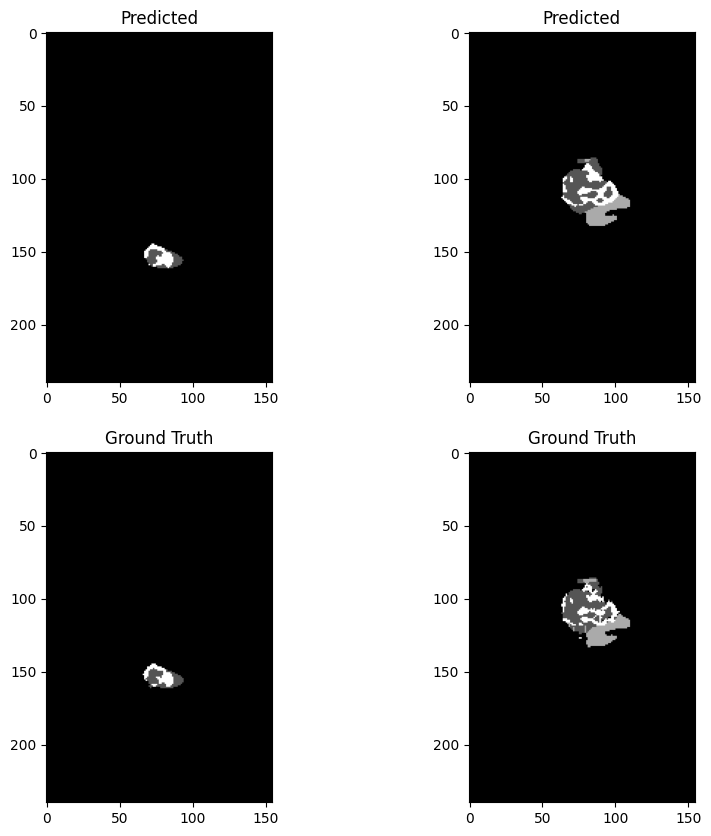

100%|██████████| 39/39 [02:24<00:00,  3.70s/it]


Average Validation Loss: 0.011361714930106431

Average Validation DSC: [0.99917905 0.90425458 0.94217059 0.81354884]
Average Validation ASSD: [ 0.0784174  16.85633686  8.6178396  13.87356943]
Epoch 88/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


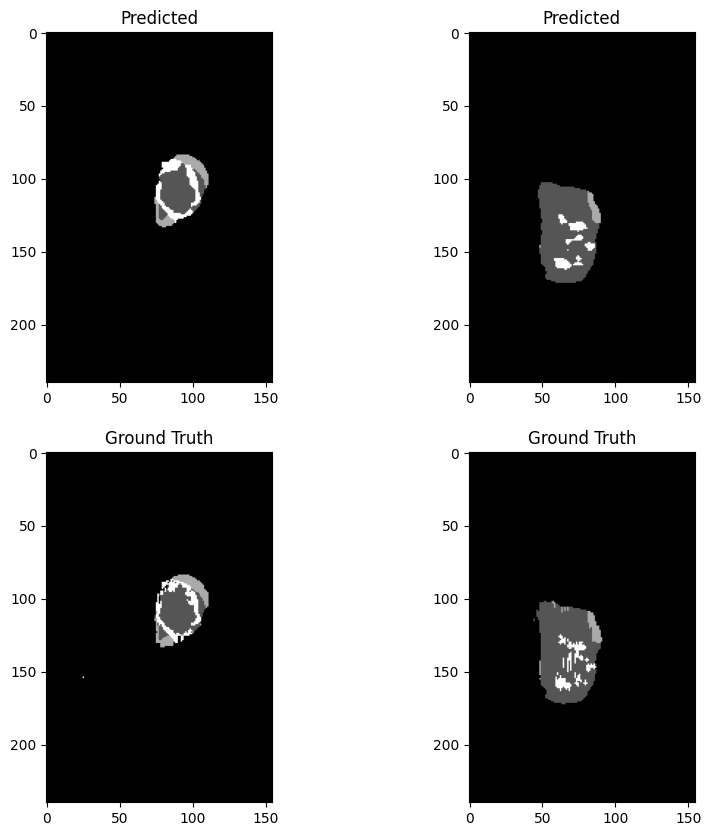

100%|██████████| 156/156 [09:56<00:00,  3.83s/it]



Average Training Loss: 0.004460393692939901

Average Training DSC: [0.99950025 0.95680485 0.95958645 0.85346363]
Average Training ASSD: [ 0.04458278  2.67468562  5.50476231 19.29777027]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


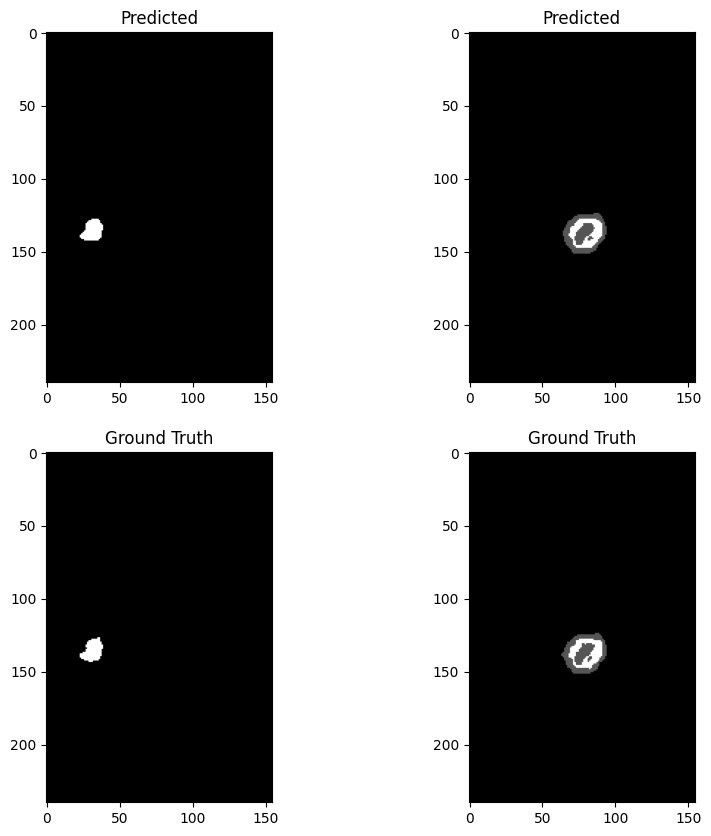

100%|██████████| 39/39 [02:24<00:00,  3.71s/it]


Average Validation Loss: 0.011445566558111936

Average Validation DSC: [0.99918548 0.90608461 0.9381422  0.79965035]
Average Validation ASSD: [ 0.07775958 17.54175058 10.01908013 20.82426914]
Epoch 89/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


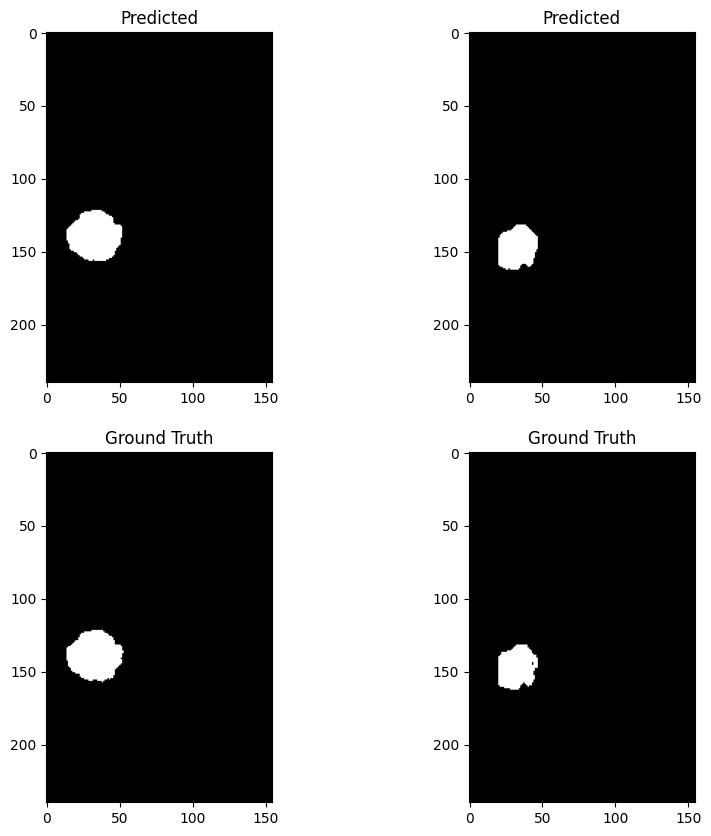

100%|██████████| 156/156 [09:46<00:00,  3.76s/it]



Average Training Loss: 0.004561877739317237

Average Training DSC: [0.99947399 0.95570816 0.95845353 0.85103991]
Average Training ASSD: [ 0.04635519  2.96783978  5.87431928 18.89970853]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


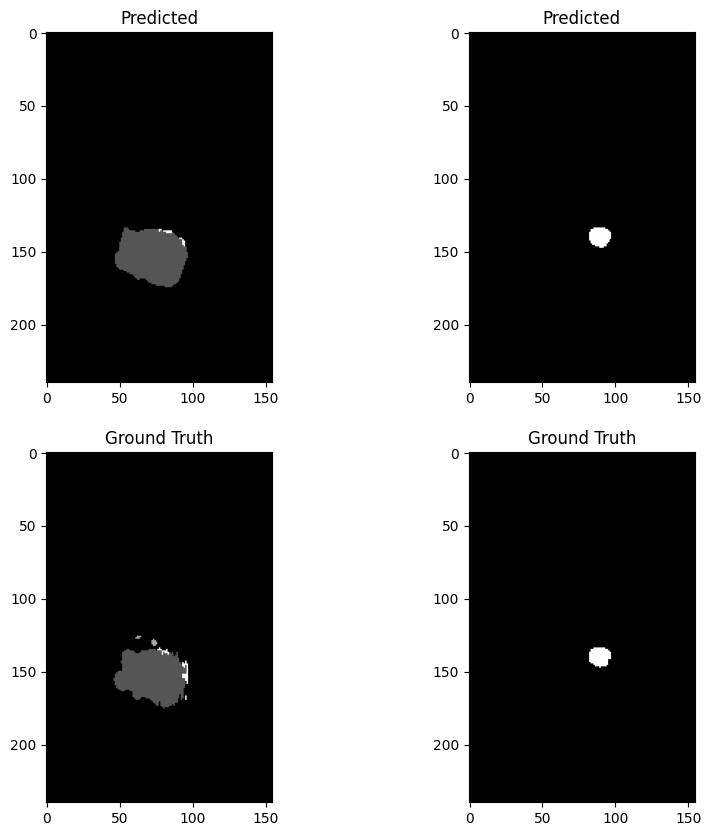

100%|██████████| 39/39 [02:18<00:00,  3.55s/it]


Average Validation Loss: 0.011399421936426407

Average Validation DSC: [0.99916162 0.90407036 0.93531917 0.80086422]
Average Validation ASSD: [ 0.08042462 16.85457523 10.54213124 19.13037268]
Epoch 90/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


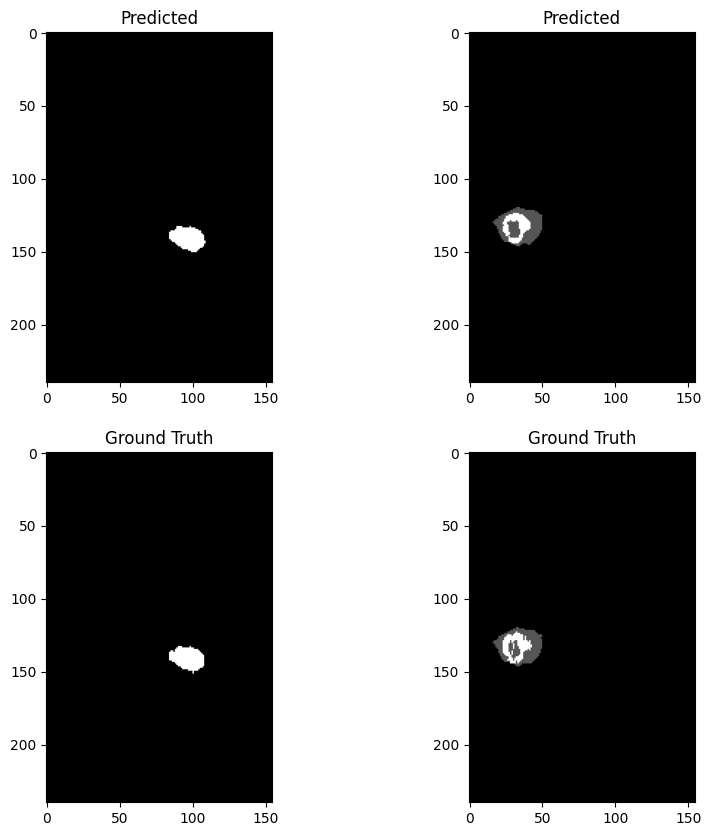

100%|██████████| 156/156 [09:54<00:00,  3.81s/it]



Average Training Loss: 0.004416360364605983

Average Training DSC: [0.99950381 0.95743308 0.96036116 0.8534859 ]
Average Training ASSD: [ 0.04416449  2.47799963  4.99040727 19.41797885]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


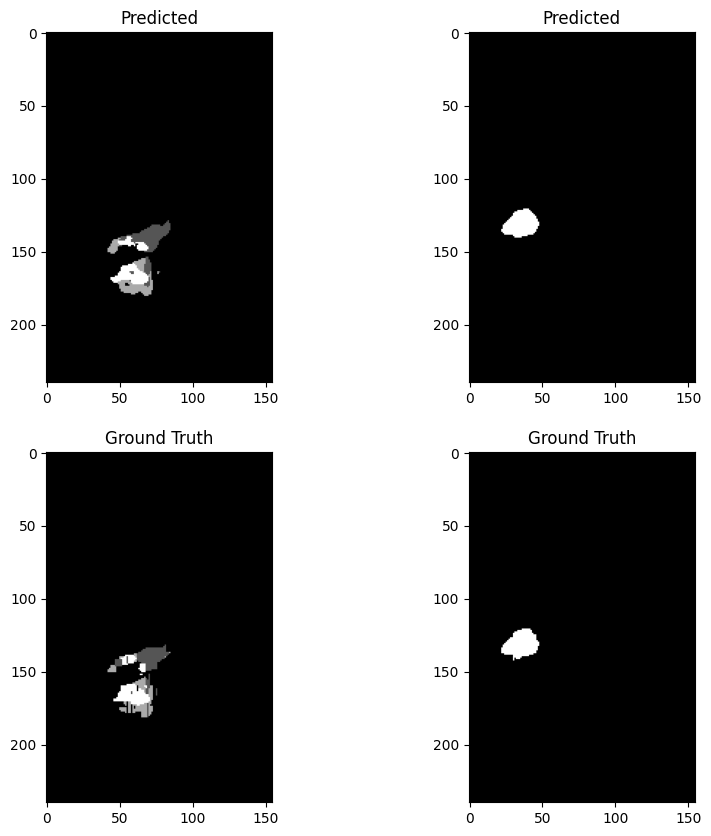

100%|██████████| 39/39 [02:10<00:00,  3.35s/it]


Average Validation Loss: 0.011611805452654759

Average Validation DSC: [0.99920583 0.90516429 0.94278414 0.81086824]
Average Validation ASSD: [ 0.07500939 16.55776566  8.64987758 16.78942876]
Epoch 91/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


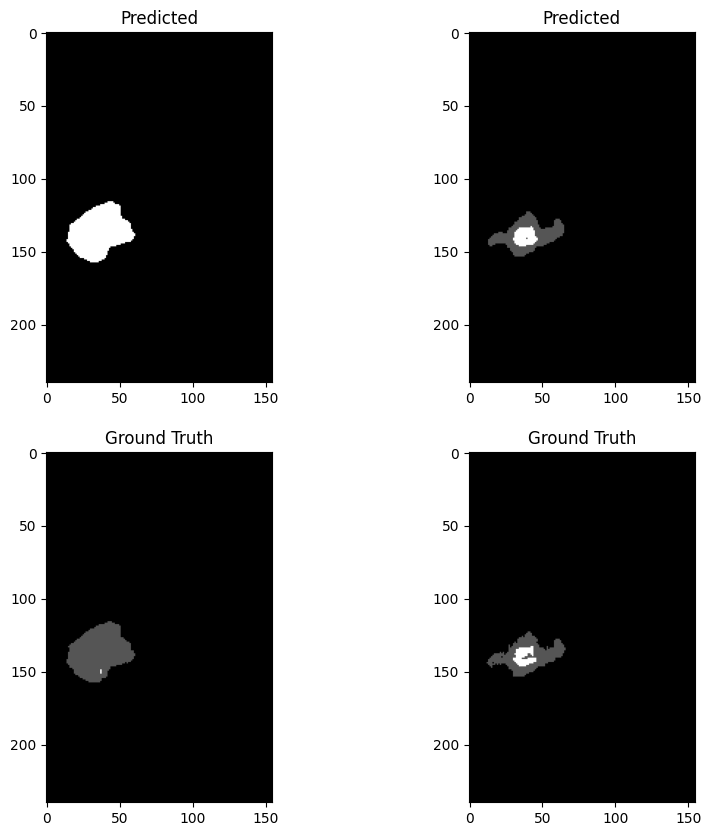

100%|██████████| 156/156 [09:43<00:00,  3.74s/it]



Average Training Loss: 0.004305049748673366

Average Training DSC: [0.99951897 0.95725104 0.95989227 0.85518148]
Average Training ASSD: [ 0.04275199  2.88366112  5.4903621  19.33657507]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


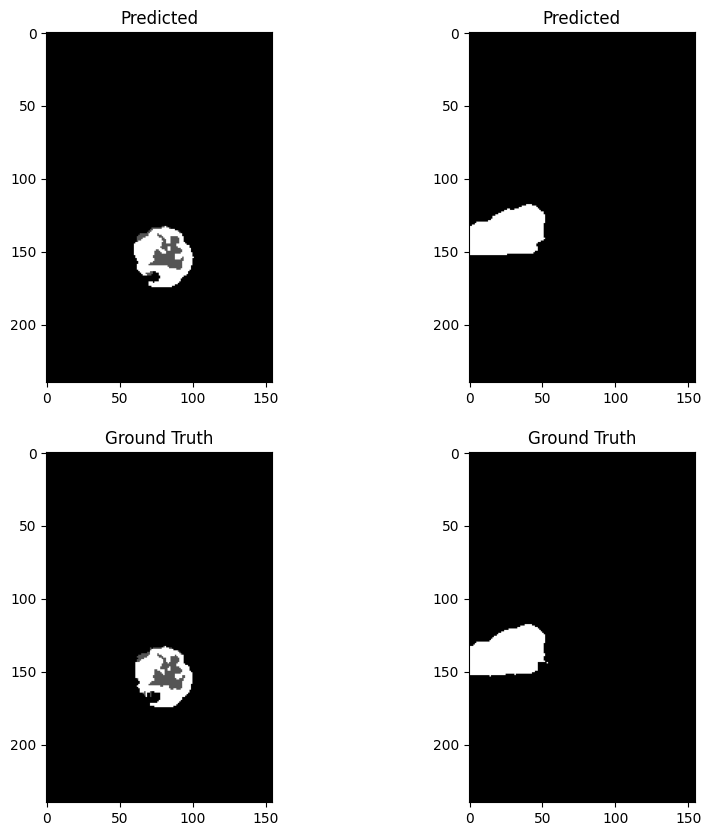

100%|██████████| 39/39 [02:16<00:00,  3.49s/it]


Average Validation Loss: 0.011523859778371377

Average Validation DSC: [0.99919663 0.90758613 0.94174761 0.81009038]
Average Validation ASSD: [ 0.07670469 15.68231254  9.83193626 16.18344292]
Epoch 92/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


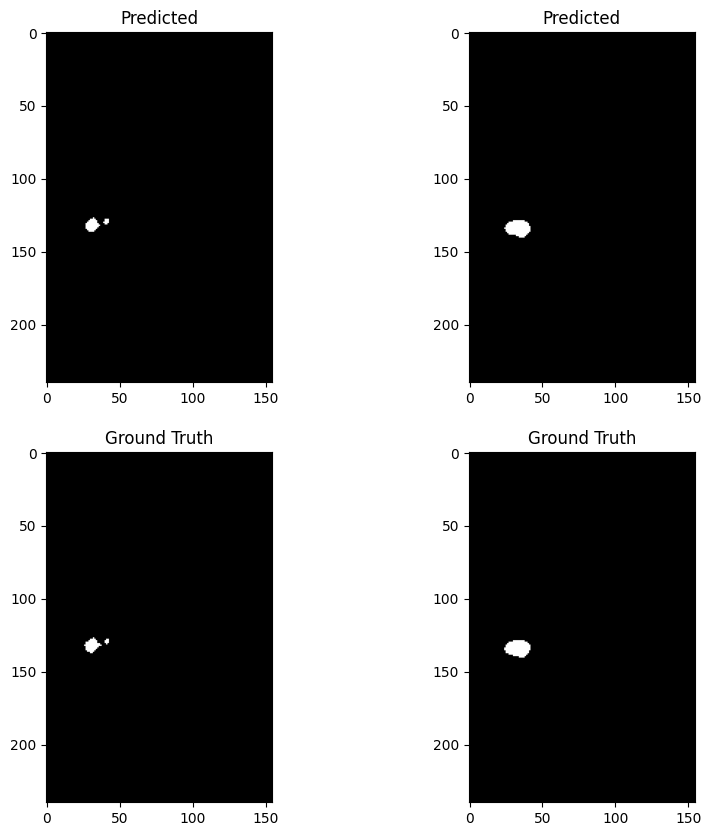

100%|██████████| 156/156 [09:48<00:00,  3.77s/it]



Average Training Loss: 0.004225631226570561

Average Training DSC: [0.99952745 0.95894563 0.96193568 0.86112315]
Average Training ASSD: [ 0.04074736  2.37335973  4.91381311 17.12916381]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


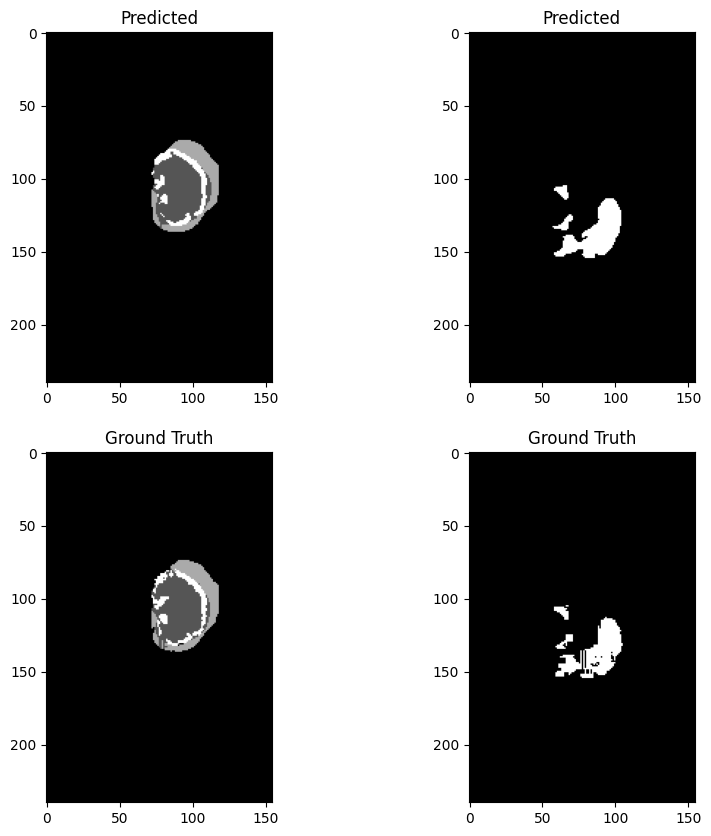

100%|██████████| 39/39 [02:19<00:00,  3.59s/it]


Average Validation Loss: 0.012086466145821107

Average Validation DSC: [0.99921668 0.90799081 0.94067136 0.80250242]
Average Validation ASSD: [ 0.07421325 16.10408966 10.03149921 21.71615664]
Epoch 93/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


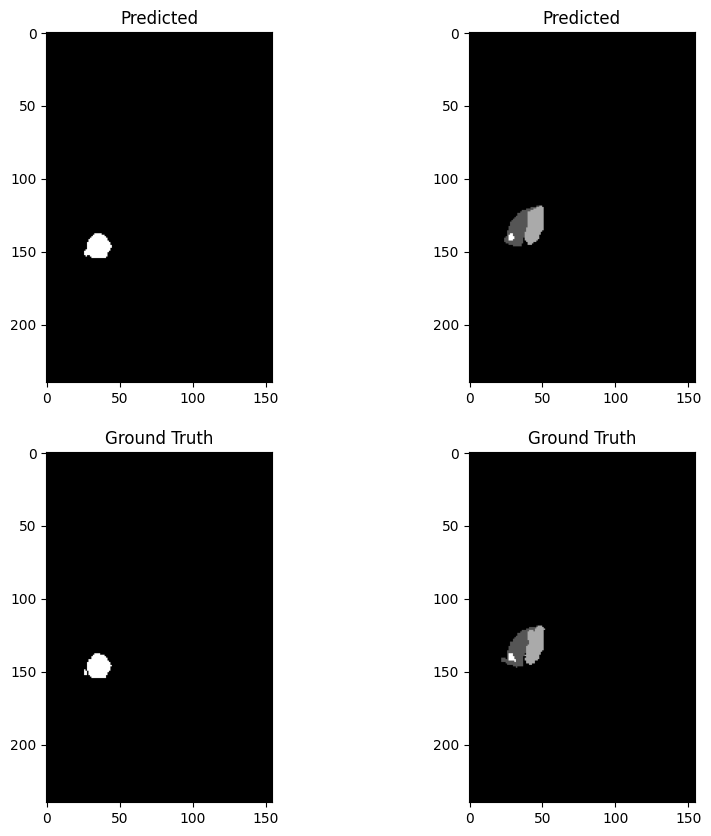

100%|██████████| 156/156 [09:42<00:00,  3.74s/it]



Average Training Loss: 0.004301568933535749

Average Training DSC: [0.99951913 0.95785337 0.96143903 0.85882771]
Average Training ASSD: [ 0.04228796  2.59292971  4.99048505 17.93770257]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


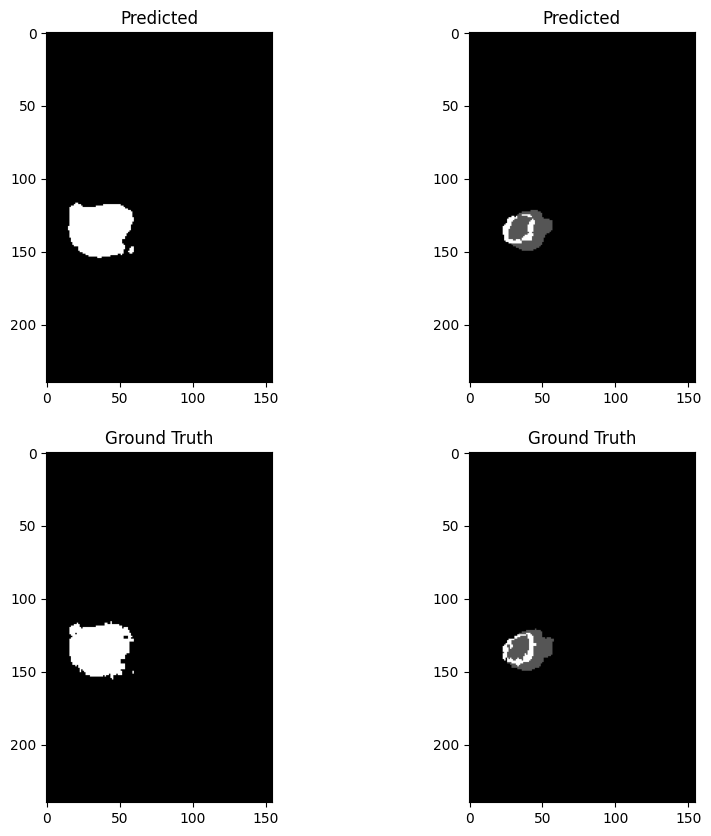

100%|██████████| 39/39 [02:23<00:00,  3.68s/it]


Average Validation Loss: 0.012035918983224874

Average Validation DSC: [0.99920904 0.9063283  0.94295873 0.79930707]
Average Validation ASSD: [ 0.07735051 16.31012973  9.18166008 22.82611663]
Epoch 94/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


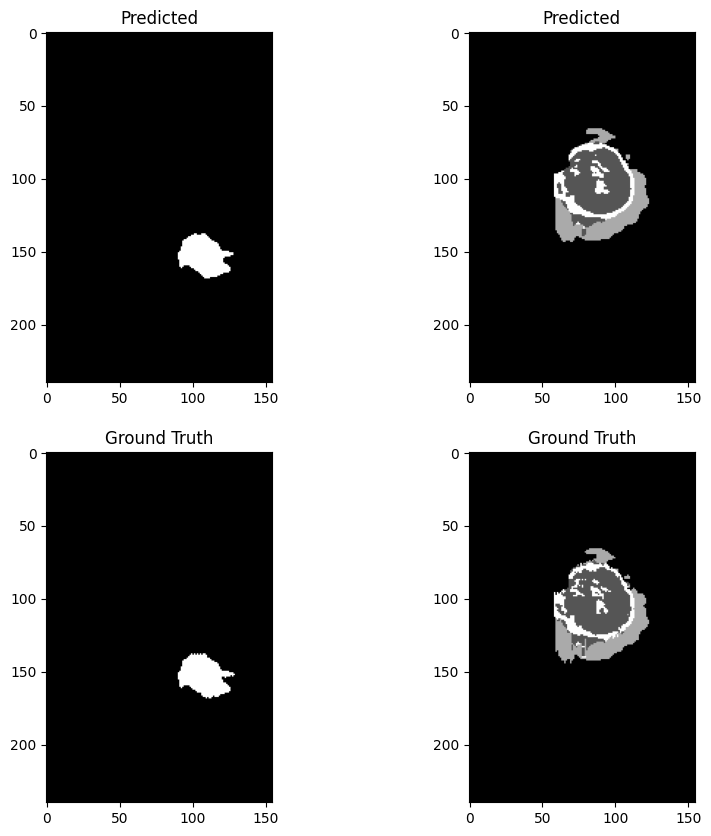

100%|██████████| 156/156 [09:59<00:00,  3.85s/it]



Average Training Loss: 0.004313768505548628

Average Training DSC: [0.9995085  0.95812348 0.95948572 0.85860532]
Average Training ASSD: [ 0.04315526  2.37897306  5.58664934 17.79635155]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


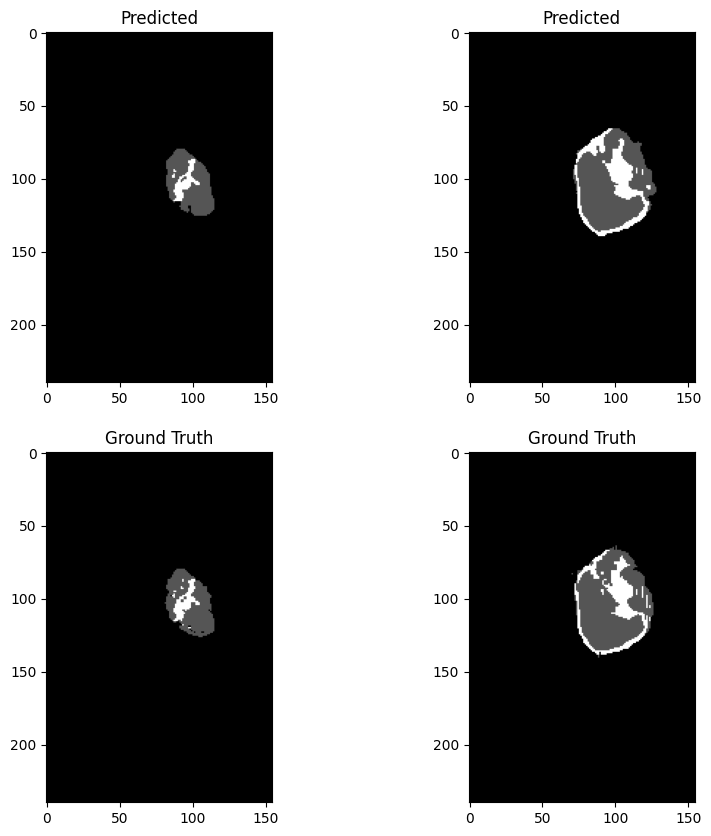

100%|██████████| 39/39 [02:21<00:00,  3.63s/it]


Average Validation Loss: 0.01163893748815052

Average Validation DSC: [0.99919884 0.9085834  0.93671298 0.8109486 ]
Average Validation ASSD: [ 0.07972088 15.67637519 10.97156573 17.16661596]
Epoch 95/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


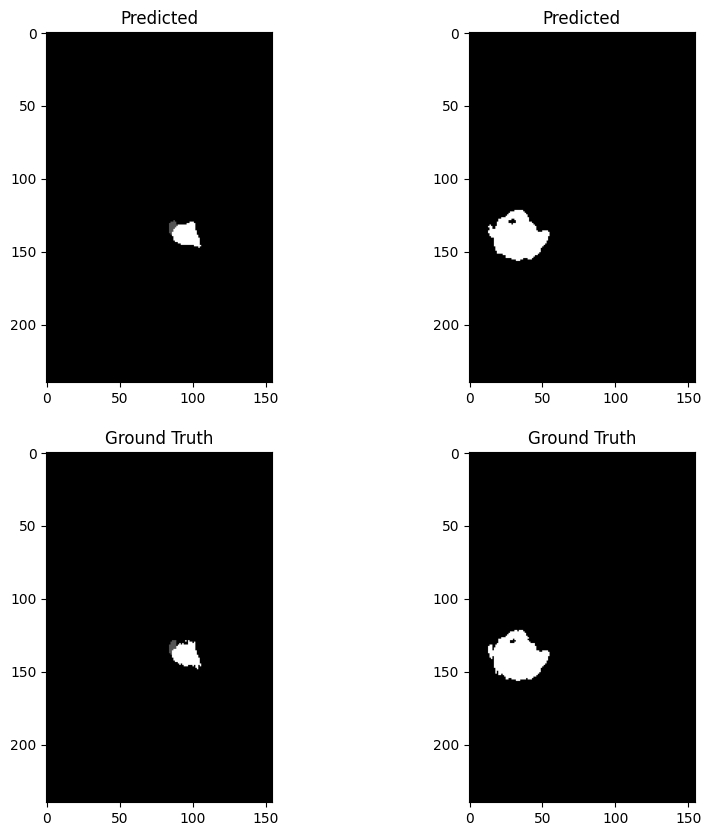

100%|██████████| 156/156 [09:43<00:00,  3.74s/it]



Average Training Loss: 0.004271686556211744

Average Training DSC: [0.99950598 0.95777968 0.95837369 0.85953011]
Average Training ASSD: [ 0.04373512  2.7367846   5.79414318 18.16830725]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


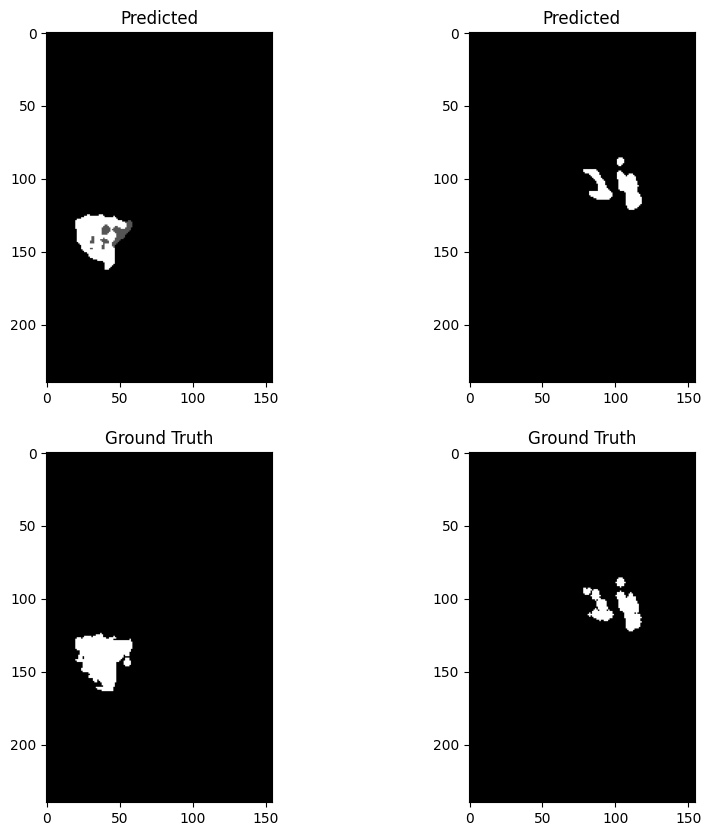

100%|██████████| 39/39 [02:21<00:00,  3.62s/it]


Average Validation Loss: 0.011673643003002955

Average Validation DSC: [0.99920444 0.91006295 0.94223021 0.807306  ]
Average Validation ASSD: [ 0.07551557 15.66837038  9.46203299 19.07454655]
Epoch 96/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


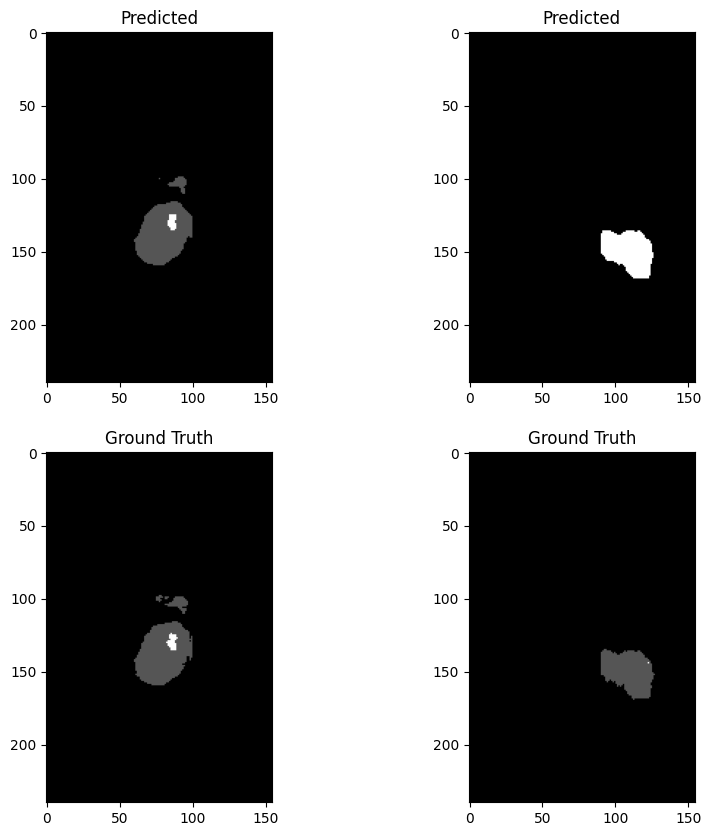

100%|██████████| 156/156 [09:52<00:00,  3.80s/it]



Average Training Loss: 0.004117660491595952

Average Training DSC: [0.99953714 0.95898799 0.96108153 0.8640106 ]
Average Training ASSD: [ 0.04041373  2.66052182  5.55010058 16.60418471]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


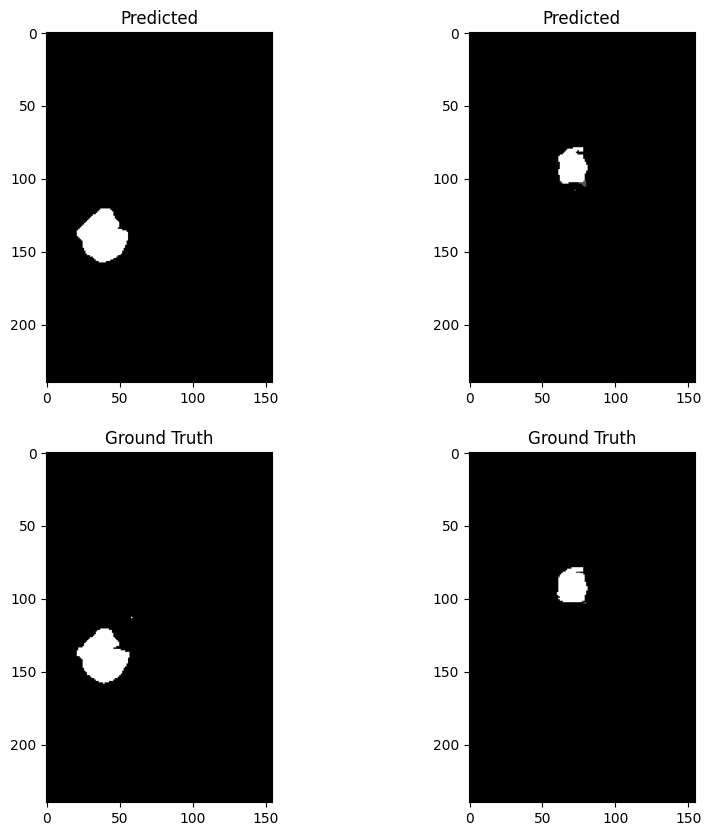

100%|██████████| 39/39 [02:13<00:00,  3.42s/it]


Average Validation Loss: 0.011858152058453131

Average Validation DSC: [0.99921376 0.90678765 0.94358388 0.80736856]
Average Validation ASSD: [ 0.07403926 16.76368211  9.71565499 18.3082857 ]
Epoch 97/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


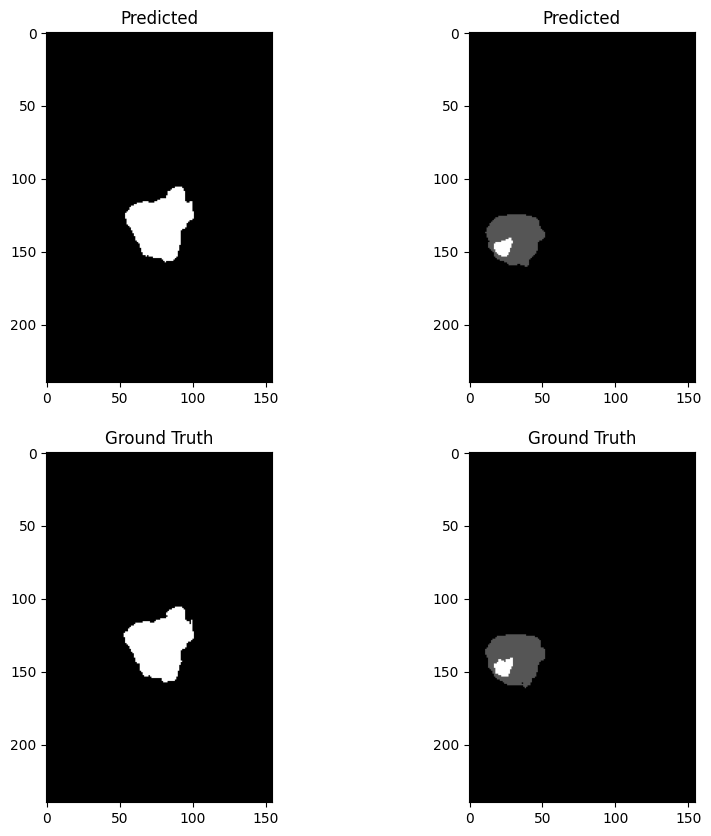

100%|██████████| 156/156 [09:43<00:00,  3.74s/it]



Average Training Loss: 0.004062560139200053

Average Training DSC: [0.99954168 0.96037009 0.96296959 0.86469571]
Average Training ASSD: [ 0.04010486  2.3631066   4.85370497 16.6404083 ]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


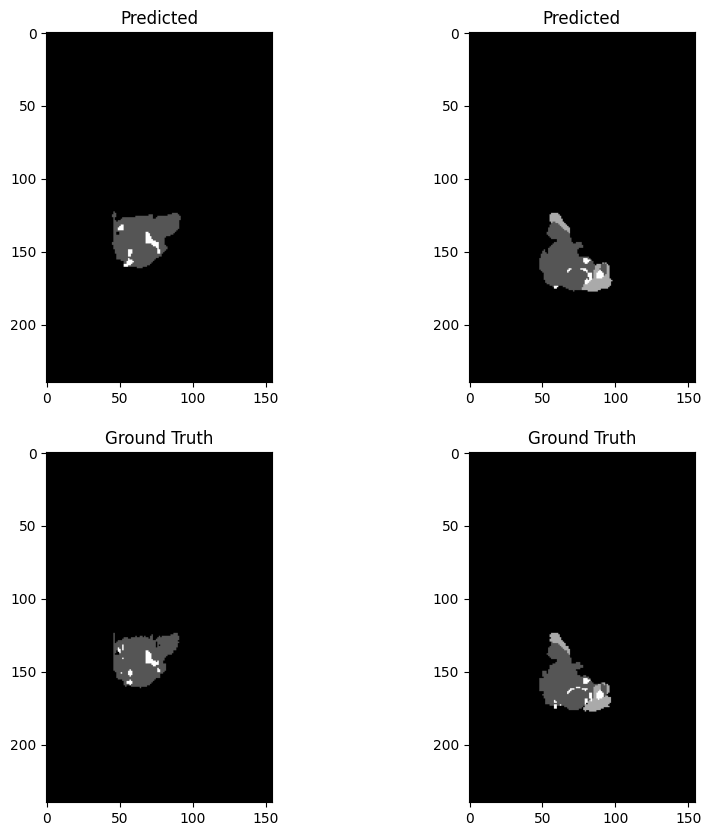

100%|██████████| 39/39 [01:08<00:00,  1.77s/it]


Average Validation Loss: 0.011843650315243464

Average Validation DSC: [0.99918983 0.90693374 0.94035169 0.82118888]
Average Validation ASSD: [ 0.0772934  16.59439943  9.21534647 12.83230669]
Epoch 98/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


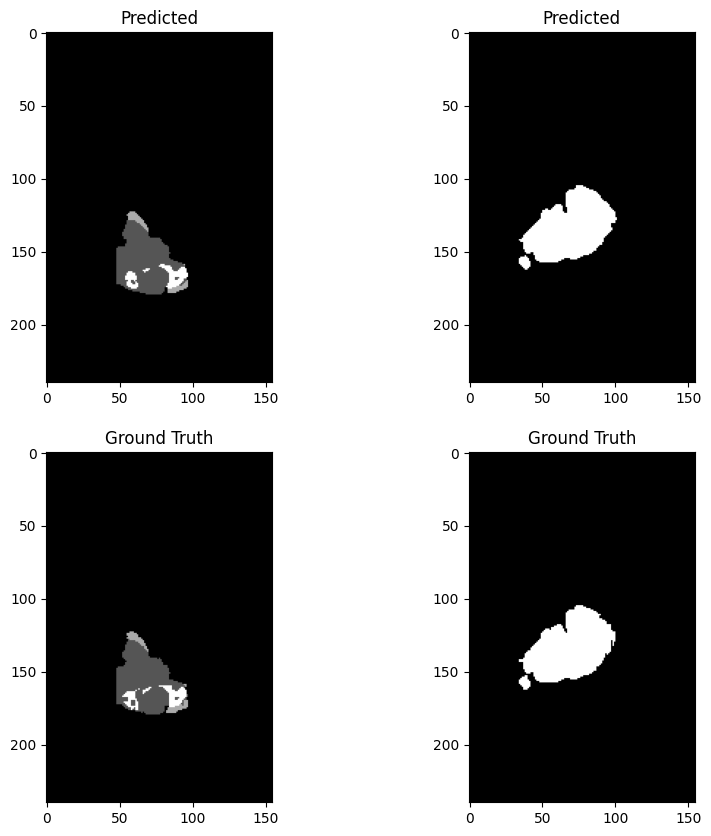

100%|██████████| 156/156 [05:17<00:00,  2.03s/it]



Average Training Loss: 0.004026495468002768

Average Training DSC: [0.99954801 0.96095502 0.96268381 0.86865587]
Average Training ASSD: [ 0.03879937  2.21895239  4.82680985 14.87907915]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


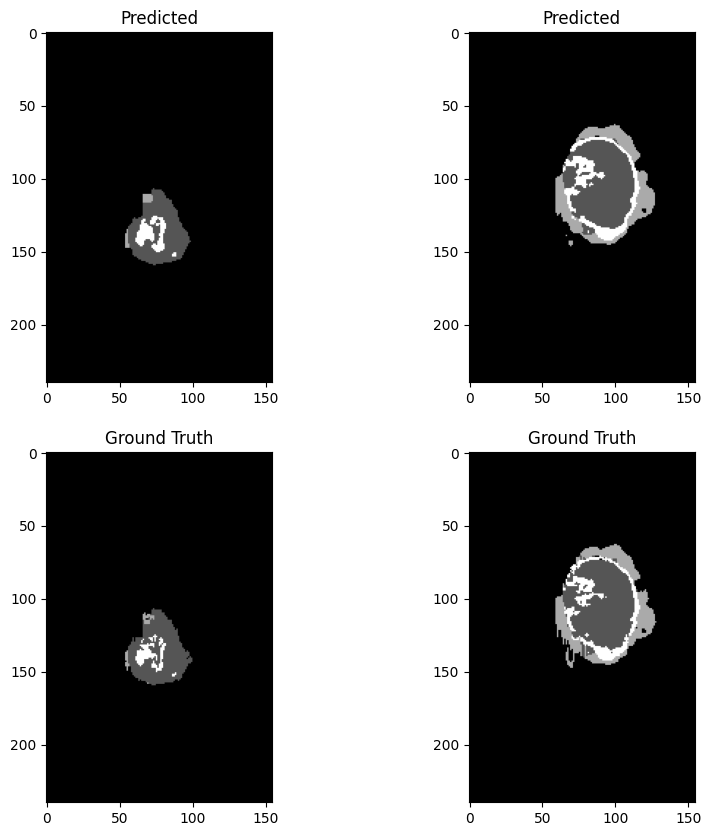

100%|██████████| 39/39 [01:11<00:00,  1.84s/it]


Average Validation Loss: 0.011718560368395768

Average Validation DSC: [0.99923838 0.90715133 0.94334197 0.81802908]
Average Validation ASSD: [ 0.07292741 17.11996008  9.19630087 14.43761558]
Epoch 99/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


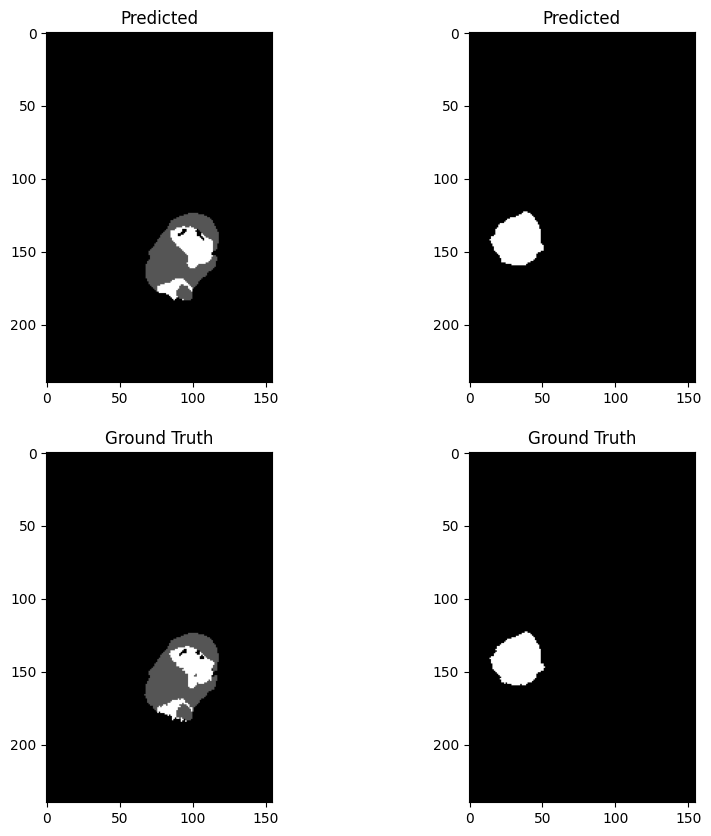

100%|██████████| 156/156 [05:18<00:00,  2.04s/it]



Average Training Loss: 0.003968425154781494

Average Training DSC: [0.99955246 0.960674   0.96280342 0.86763472]
Average Training ASSD: [ 0.03881258  2.43239723  4.91175888 16.19882782]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


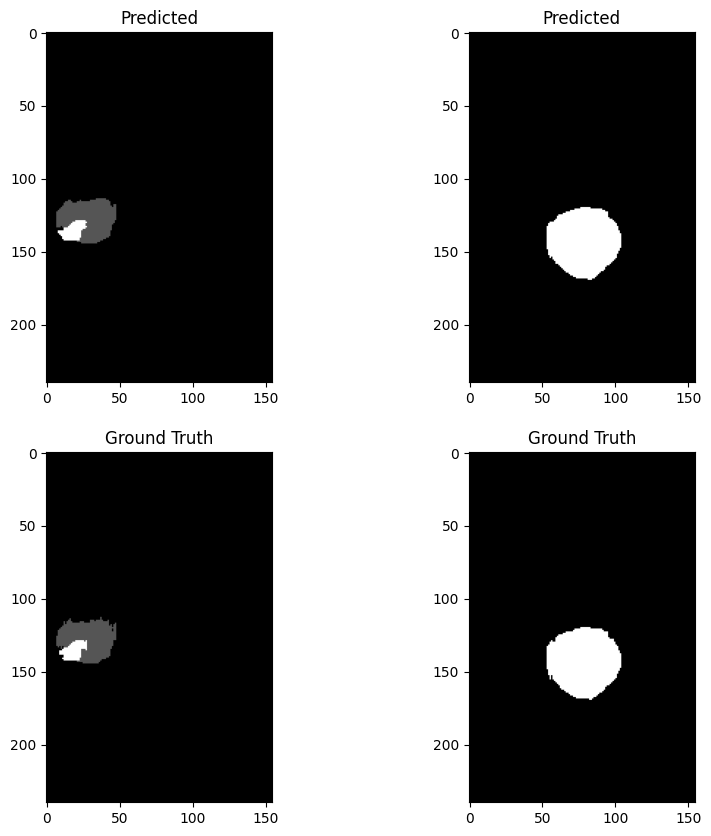

100%|██████████| 39/39 [01:13<00:00,  1.89s/it]


Average Validation Loss: 0.012046171758228388

Average Validation DSC: [0.99921588 0.90629334 0.93414575 0.81054651]
Average Validation ASSD: [ 0.07553227 17.16977557 11.57591215 16.70906001]
Epoch 100/100
-------------------------


  0%|          | 0/156 [00:00<?, ?it/s]

Training Prediction Visualization:


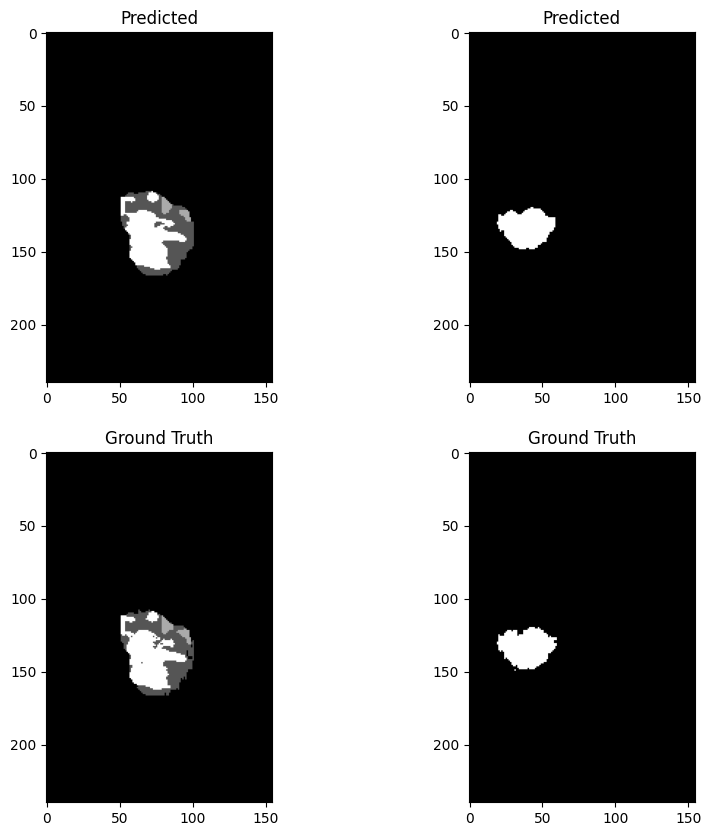

100%|██████████| 156/156 [05:18<00:00,  2.04s/it]



Average Training Loss: 0.0038933429601363456

Average Training DSC: [0.9995617  0.96170203 0.96358259 0.87184966]
Average Training ASSD: [ 0.03812905  2.35724411  4.40084975 16.14096667]


  0%|          | 0/39 [00:00<?, ?it/s]

Validation Prediction Visualization:


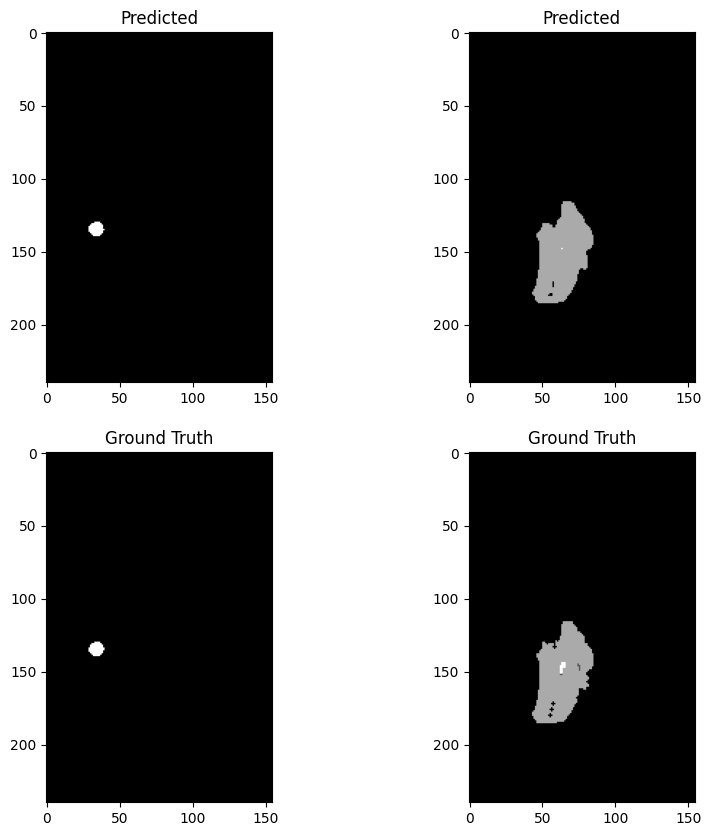

100%|██████████| 39/39 [01:12<00:00,  1.87s/it]


Average Validation Loss: 0.012400286964690074

Average Validation DSC: [0.99923383 0.90218758 0.93340622 0.80746099]
Average Validation ASSD: [ 0.07648954 18.33802461 12.33519551 16.96816892]


In [11]:
model = train_model(num_epochs = 100)